In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import re
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from statsmodels.tsa.api import VAR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_curve, auc
import warnings
warnings.filterwarnings("ignore")

# Pre-defined Functions

##Importing Data Sets

In [ ]:
def read_satellite_data(file_path, index_col=0, parse_dates=True):
  df = pd.read_csv(file_path, index_col=index_col, parse_dates=parse_dates)
  return df

In [ ]:
#Function to extract start and endates from manoeuvre files.

def extract_start_end_dates(file_path):

  def extract_date(line, start):
    year = int(line[start:start+4])
    day_of_year = int(line[start+5:start+8])
    hour = int(line[start+9:start+11])
    minute = int(line[start+12:start+14])
    return pd.to_datetime(f"{year}-01-01") + pd.Timedelta(days=day_of_year-1, hours=hour, minutes=minute)

  data = []
  with open(file_path, 'r') as f:
    for line in f:
      start_date = extract_date(line, 6)
      end_date = extract_date(line, 21)
      data.append({'start_date': start_date, 'end_date': end_date})

  return pd.DataFrame(data)

## Formatting the columns

In [ ]:
def format_cols(data):
  special_chars = r'[?|$|#|@|#|%|!|*|(|)|{|}|^|,|-|.|/|>|<|;|:]'
  # lower-case and replace any white-space '_' for every column name
  data.columns = list(map(lambda x:re.sub(special_chars,r'',x.lower().replace(' ','_').replace("'","").replace("|","_").replace('-','_')), data.columns))

## Checking for Duplicates

In [ ]:
def check_duplicates(data):
  # collect duplicate using 'last'
  data_duplicate_avoid_one_val = data[data.duplicated(keep='last')]

  # collect all the duplicates
  data_duplicate_all = data[data.duplicated(keep=False)]

  # get unique count of duplicates
  len_data_duplicate_avoid_one_val = len(data_duplicate_avoid_one_val)
  len_data_duplicate_all = len(data_duplicate_all)
  count_unique_val_with_duplicates = len_data_duplicate_all - len_data_duplicate_avoid_one_val

  if count_unique_val_with_duplicates == 0:
    print("No duplicates")
  else:
    print("Duplicates are spotted")

## Missing Values

In [ ]:
def missing_values(data):
   percent_msng_val = (data.isnull().sum().sum()/(data.shape[0]*data.shape[1]))*100
   print('Percentage of missing value in entire dataset is: {}%'.format(round(percent_msng_val,4)))

## ACF and PACF plots

In [ ]:
def acf_pacf(data):
  variables = cs2_tle.columns
  num_vars = len(variables)

  fig, axes = plt.subplots(nrows=num_vars, ncols=2, figsize=(15, 3 * num_vars))

  for i, var in enumerate(variables):
    plot_acf(cs2_tle[var], ax=axes[i, 0], title=f'ACF of {var}')
    plot_pacf(cs2_tle[var], ax=axes[i, 1], title=f'PACF of {var}')

  plt.tight_layout()
  plt.show()

## Stationary Test: ADF Test

In [ ]:
def adf_test_scores(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    print('')

def adf_test(data):
  for column in data.columns:
    adf_test_scores(data[column], title=column)

## Exploratory Data Analysis

In [ ]:
def eda(data, man_data):
  # basic information about the dataset
  print(data.info())
  print(data.describe())
  # time series charts for each variable
  variables = data.columns
  num_vars = len(variables)

  fig, axes = plt.subplots(nrows=num_vars, ncols=1, figsize=(10, 2 * num_vars), sharex=True)
  legend_handles = [plt.plot([], [], color='black', linestyle='--', label='Manoeuvre Start Date')[0]]
  for i, var in enumerate(variables):
    axes[i].plot(data.index, data[var])
    axes[i].set_title(var)
    axes[i].set_ylabel(var)
    axes[i].tick_params(axis='x', rotation=45)

    # manoeuvre dates
    for start_date in man_data['start_date']:
        axes[i].axvline(x=start_date, color='black', linestyle='--', linewidth=0.8)

    axes[i].legend(handles=legend_handles)

  axes[-1].set_xlabel('Date')
  plt.tight_layout()
  plt.show()

## Exploratory Data Analysis Filtered

In [ ]:
def eda_filtered(data, man_data, start, end):
  data = data[(data.index >= pd.Timestamp(start)) & (data.index < pd.Timestamp(end))]
  man_data = man_data[(man_data['start_date'] >= pd.Timestamp(start)) &(man_data['start_date'] < pd.Timestamp(end))]

  # time series charts for each variable
  variables = data.columns
  num_vars = len(variables)

  fig, axes = plt.subplots(nrows=num_vars, ncols=1, figsize=(10, 2 * num_vars), sharex=True)
  legend_handles = [plt.plot([], [], color='black', linestyle='--', label='Manoeuvre Start Date')[0]]
  for i, var in enumerate(variables):
    axes[i].plot(data.index, data[var])
    axes[i].set_title(var)
    axes[i].set_ylabel(var)
    axes[i].tick_params(axis='x', rotation=45)

    # manoeuvre dates
    for start_date in man_data['start_date']:
        axes[i].axvline(x=start_date, color='black', linestyle='--', linewidth=0.8)

    axes[i].legend(handles=legend_handles)

  axes[-1].set_xlabel('Date')
  plt.tight_layout()
  plt.show()

## ARIMA Model

In [ ]:
def best_arima_fit(series):
  best_model = None
  best_mse = float('inf')
  best_order = None
  for p in range(1, 4):  # lags 1, 2, 3
      for d in range(0, 3):  # differencing 0, 1, 2
          for q in range(0, 3):  # MA terms 0, 1, 2
              try:
                  model = ARIMA(series, order=(p, d, q))
                  model_fit = model.fit()
                  residuals = model_fit.resid
                  mse = mean_squared_error(series[d:], residuals[d:])
                  if mse < best_mse:
                      best_mse = mse
                      best_model = model_fit
                      best_order = (p, d, q)
              except:
                  continue
  print(f'Best ARIMA order: {best_order} with MSE: {best_mse}')
  return best_model

## Plotting ARIMA Residuals with Manoeuvre Timestamps

In [ ]:
def plot_residuals(best_model, man_data, start, end):
  residuals = best_model.resid

  residuals = residuals[(residuals.index >= pd.Timestamp(start)) & (residuals.index < pd.Timestamp(end))]
  man_data = man_data[(man_data['start_date'] >= pd.Timestamp(start)) &(man_data['start_date'] < pd.Timestamp(end))]

  plt.figure(figsize=(12, 6))
  plt.plot(residuals, label='Residuals')
  plt.ylabel('Brower Mean Motion Residuals')
  plt.xlabel('Date')
  plt.title('Residuals Plot')

  for start_date in man_data['start_date']:
      plt.axvline(x=start_date, color='black', linestyle='--', linewidth=0.8)

  legend_handles = [plt.plot([], [], color='black', linestyle='--', label='Manoeuvre Start Date')[0]]
  plt.legend(handles=legend_handles)
  plt.show()

## xGBoost

In [ ]:
def xgboost_with_grid_search(data, target_column, lag=3, test_size=0.2):
    """
    Train an XGBoost model with grid search on a time series dataset with lagged features to detect anomalies.

    :param data: DataFrame containing time series data
    :param target_column: The name of the target column in data
    :param lag: Number of lagged features to use
    :param test_size: Proportion of the data to use for testing
    :return: (best_model, test_data, predictions, residuals, anomaly_indices) -
             Best XGBoost model, test data, predictions, residuals, and anomaly indices
    """
    # Create lagged features
    df = data.copy()
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df[target_column].shift(i)

    # Drop rows with NaN values (due to lagging)
    df.dropna(inplace=True)

    # Split data into features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Define parameter grid for grid search
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    # XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror')

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
    grid_search.fit(X_train, y_train)

    # Get the best model from grid search
    best_model = grid_search.best_estimator_

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)
    residuals = np.abs(y_test - y_pred)

    # Determine anomaly threshold (e.g., using the mean or a multiple of the standard deviation)
    anomaly_threshold = residuals.mean() + 2 * residuals.std()

    # Identify anomalies
    anomalies = residuals > anomaly_threshold
    anomaly_indices = X_test.index[anomalies]

    # Return the best model and relevant results
    print(f"Best Parameters: {grid_search.best_params_}")
    return best_model, y_test, y_pred, residuals, anomaly_indices

In [ ]:
def train_xgboost_for_anomaly_detection(data, target_column, lag = 3, test_size = 0.2):
    """
    Train an XGBoost model on a time series dataset with lagged features to detect anomalies.

    :param data: DataFrame containing time series data
    :param target_column: The name of the target column in data
    :param lag: Number of lagged features to use
    :param test_size: Proportion of the data to use for testing
    :return: (model, test_data, predictions) - Trained XGBoost model, test data, and predictions
    """

    # Create lagged features
    df = data.copy()
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df[target_column].shift(i)

    # Drop rows with NaN values (due to lagging)
    df.dropna(inplace=True)

    # Split data into features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Train the XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    residuals = np.abs(y_test - y_pred)

    # Determine anomaly threshold (e.g., using the mean or a multiple of the standard deviation)
    anomaly_threshold = residuals.mean() + 2 * residuals.std()

    # Identify anomalies
    anomalies = residuals > anomaly_threshold
    anomaly_indices = X_test.index[anomalies]

    # Return model and relevant information for further analysis
    return model, y_test, y_pred, residuals, anomaly_indices

## CATBoost

In [ ]:
def catboost_with_grid_search(data, target_column, lag=3, test_size=0.2):
    """
    Train a CatBoost model with grid search on a time series dataset with lagged features to detect anomalies.

    :param data: DataFrame containing time series data
    :param target_column: The name of the target column in data
    :param lag: Number of lagged features to use
    :param test_size: Proportion of the data to use for testing
    :return: (best_model, test_data, predictions, residuals, anomaly_indices) -
             Best CatBoost model, test data, predictions, residuals, and anomaly indices
    """
    # Create lagged features
    df = data.copy()
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df[target_column].shift(i)

    # Drop rows with NaN values (due to lagging)
    df.dropna(inplace=True)

    # Split data into features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Define parameter grid for grid search
    param_grid = {
        'iterations': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5]
    }

    # Perform grid search
    model = CatBoostRegressor(verbose=0)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=3,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)
    residuals = np.abs(y_test - y_pred)

    # Determine anomaly threshold (e.g., using the mean or a multiple of the standard deviation)
    anomaly_threshold = residuals.mean() + 2 * residuals.std()

    # Identify anomalies
    anomalies = residuals > anomaly_threshold
    anomaly_indices = X_test.index[anomalies]

    # Print the best parameters
    print(f"Best Parameters: {grid_search.best_params_}")

    # Return the best model and relevant results
    return best_model, y_test, y_pred, residuals, anomaly_indices

In [ ]:
def train_catboost_for_anomaly_detection(data, target_column, lag=3, test_size=0.2):
    """
    Train a CatBoost model on a time series dataset with lagged features to detect anomalies.

    :param data: DataFrame containing time series data
    :param target_column: The name of the target column in data
    :param lag: Number of lagged features to use
    :param test_size: Proportion of the data to use for testing
    :return: (model, test_data, predictions) - Trained CatBoost model, test data, and predictions
    """

    # Create lagged features
    df = data.copy()
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df[target_column].shift(i)

    # Drop rows with NaN values (due to lagging)
    df.dropna(inplace=True)

    # Split data into features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Train the CatBoost model
    model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, verbose=0)  # Set verbose=1 to see training info
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    residuals = np.abs(y_test - y_pred)

    # Determine anomaly threshold (e.g., using the mean or a multiple of the standard deviation)
    anomaly_threshold = residuals.mean() + 2 * residuals.std()

    # Identify anomalies
    anomalies = residuals > anomaly_threshold
    anomaly_indices = X_test.index[anomalies]

    # Return model and relevant information for further analysis
    return model, y_test, y_pred, residuals, anomaly_indices


## xGBoost and CatBoost Residuals Plot

In [ ]:
def plot_xgboost_residuals(y_test, y_pred, man_data, start, end):
    """
    Plot the residuals of the XGBoost model with maneuver timestamps overlaid.

    :param y_test: Actual values from the test set
    :param y_pred: Predicted values from the XGBoost model
    :param man_data: DataFrame containing maneuver start dates
    :param start: Start date for the plot
    :param end: End date for the plot
    """
    # Calculate residuals
    residuals = np.abs(y_test - y_pred)

    # Create a date range for the residuals index
    residuals_index = y_test.index

    # Filter residuals and maneuver data based on the specified date range
    residuals = residuals[(residuals_index >= pd.Timestamp(start)) & (residuals_index < pd.Timestamp(end))]
    man_data_filtered = man_data[(man_data['start_date'] >= pd.Timestamp(start)) & (man_data['start_date'] < pd.Timestamp(end))]

    plt.figure(figsize=(12, 6))
    plt.plot(residuals.index, residuals, label='Residuals')
    plt.ylabel('Residuals')
    plt.xlabel('Date')
    plt.title('Residuals Plot')

    # Overlay maneuver start dates
    for start_date in man_data_filtered['start_date']:
        plt.axvline(x=start_date, color='black', linestyle='--', linewidth=0.8)

    # Create legend handles
    legend_handles = [plt.plot([], [], color='black', linestyle='--', label='Maneuver Start Date')[0]]
    plt.legend(handles=legend_handles)
    plt.show()

## Multivariate ARIMA Model

In [ ]:
def best_var_fit(data, target_variable='brouwer_mean_motion', maneuver_dates=None, max_lag=3, start_date=None, end_date=None):
    """
    Finds the best VAR model and plots residuals with maneuver dates within a specified time range.

    :param data: DataFrame containing the time series data
    :param target_variable: The name of the target variable
    :param maneuver_dates: List or Series of actual maneuver dates (datetime format)
    :param max_lag: Maximum lag order to test
    :param start_date: Start date for plotting (inclusive)
    :param end_date: End date for plotting (inclusive)
    :return: Best VAR model and its lag order
    """
    best_model = None
    best_mse = float('inf')
    best_lag_order = None
    residuals = None

    for lag_order in range(1, max_lag + 1):
        try:
            # Fit the VAR model
            model = VAR(data)
            model_fit = model.fit(lag_order)

            # Forecast the target variable
            forecast_values = model_fit.fittedvalues[target_variable]

            # Compute residuals
            actual_values = data[target_variable][lag_order:]  # Align actual values
            residuals = actual_values - forecast_values

            # Compute MSE
            mse = mean_squared_error(actual_values, forecast_values)

            # Update best model if the current one is better
            if mse < best_mse:
                best_mse = mse
                best_model = model_fit
                best_lag_order = lag_order
        except Exception as e:
            print(f"Error with lag order {lag_order}: {e}")
            continue

    # Filter residuals and maneuver dates by date range
    if residuals is not None:
        if start_date is not None:
            start_date = pd.to_datetime(start_date)
            residuals = residuals[residuals.index >= start_date]
        if end_date is not None:
            end_date = pd.to_datetime(end_date)
            residuals = residuals[residuals.index <= end_date]

        plt.figure(figsize=(12, 6))
        plt.plot(residuals.index, residuals, label='Residuals', alpha=0.7)
        plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)

        # Highlight maneuver dates
        if maneuver_dates is not None:
            for date in maneuver_dates:
                maneuver_date = pd.to_datetime(date)
                if start_date <= maneuver_date <= end_date:
                    plt.axvline(maneuver_date, color='black', linestyle='--', label='Maneuver' if 'Maneuver' not in plt.gca().get_legend_handles_labels()[1] else "")

        plt.title(f'Residuals of VAR Model (Lag Order {best_lag_order})')
        plt.xlabel('Date')
        plt.ylabel('Residual')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    print(f"Best VAR lag order: {best_lag_order} with MSE: {best_mse}")
    return best_model, best_lag_order


## Model Evaluation

In [ ]:
def evaluate_model_performance(
    float_matching_max_days,
    float_threshold,
    pd_series_ground_truth_manoeuvre_timestamps,
    pd_series_predictions
):
    """
    Computes the precision and recall at one anomaly threshold using an implementation of
    the framework proposed by Zhao (2021). Matches each maneuver prediction with the closest
    ground-truth maneuver, if it is within a specified time window.

    :param float_matching_max_days: Maximum allowable days for matching predictions to ground truth
    :param float_threshold: Anomaly threshold above which predictions are considered positive
    :param pd_series_ground_truth_manoeuvre_timestamps: Series containing ground truth maneuver timestamps
    :param pd_series_predictions: Series with timestamps as the index and prediction values

    :return: (precision, recall)
    """
    matching_max_distance_seconds = pd.Timedelta(days=float_matching_max_days).total_seconds()

    def convert_timestamp_series_to_epoch(series):
        return (
            (series - pd.Timestamp(year=1970, month=1, day=1)) // pd.Timedelta(seconds=1)
        ).values

    dict_predictions_to_ground_truth = {}
    dict_ground_truth_to_predictions = {}

    np_manoeuvre_timestamps_seconds = convert_timestamp_series_to_epoch(pd_series_ground_truth_manoeuvre_timestamps)
    np_pred_time_stamps_seconds = convert_timestamp_series_to_epoch(pd_series_predictions.index)
    np_predictions = pd_series_predictions.to_numpy()

    for i in range(np_predictions.shape[0]):
        if np_predictions[i] >= float_threshold:
            left_index = np.searchsorted(
                np_manoeuvre_timestamps_seconds, np_pred_time_stamps_seconds[i]
            )

            if left_index != 0:
                left_index -= 1

            index_of_closest = left_index

            if (left_index < pd_series_ground_truth_manoeuvre_timestamps.shape[0] - 1) and (
                abs(np_manoeuvre_timestamps_seconds[left_index] - np_pred_time_stamps_seconds[i])
                > abs(np_manoeuvre_timestamps_seconds[left_index + 1] - np_pred_time_stamps_seconds[i])
            ):
                index_of_closest = left_index + 1

            diff = abs(np_manoeuvre_timestamps_seconds[index_of_closest] - np_pred_time_stamps_seconds[i])

            if diff < matching_max_distance_seconds:
                dict_predictions_to_ground_truth[i] = (
                    index_of_closest,
                    diff,
                )
                if index_of_closest in dict_ground_truth_to_predictions:
                    dict_ground_truth_to_predictions[index_of_closest].append(i)
                else:
                    dict_ground_truth_to_predictions[index_of_closest] = [i]

    np_positive_prediction_indices = np.argwhere(np_predictions >= float_threshold)[:, 0]
    list_false_positives = [
        pred_ind for pred_ind in np_positive_prediction_indices if pred_ind not in dict_predictions_to_ground_truth.keys()
    ]
    list_false_negatives = [
        true_ind for true_ind in np.arange(0, len(pd_series_ground_truth_manoeuvre_timestamps))
        if true_ind not in dict_ground_truth_to_predictions.keys()
    ]

    # Compute precision and recall, handling division by zero
    if len(dict_ground_truth_to_predictions) + len(list_false_positives) > 0:
        precision = len(dict_ground_truth_to_predictions) / (len(dict_ground_truth_to_predictions) + len(list_false_positives))
    else:
        precision = 0.0  # No predictions, set precision to 0

    if len(dict_ground_truth_to_predictions) + len(list_false_negatives) > 0:
        recall = len(dict_ground_truth_to_predictions) / (len(dict_ground_truth_to_predictions) + len(list_false_negatives))
    else:
        recall = 0.0  # No ground truth maneuvers, set recall to 0

    return (precision, recall)

## Precision Recall Curve

In [ ]:
def plot_precision_recall_curve_from_model(
    float_matching_max_days,
    pd_series_ground_truth_manoeuvre_timestamps,
    pd_series_predictions,
    thresholds=None,
    title="Precision-Recall Curve"
):
    """
    Plots a Precision-Recall Curve by varying the anomaly threshold.

    :param float_matching_max_days: Maximum allowable days for matching predictions to ground truth
    :param pd_series_ground_truth_manoeuvre_timestamps: Series containing ground truth maneuver timestamps
    :param pd_series_predictions: Series with timestamps as the index and prediction values
    :param thresholds: Array-like of thresholds to evaluate. If None, automatically generated
    :param title: Title for the plot
    """
    if thresholds is None:
        thresholds = np.linspace(min(pd_series_predictions), max(pd_series_predictions), 100)

    precisions = []
    recalls = []

    for threshold in thresholds:
        precision, recall = evaluate_model_performance(
            float_matching_max_days,
            threshold,
            pd_series_ground_truth_manoeuvre_timestamps,
            pd_series_predictions
        )
        precisions.append(precision)
        recalls.append(recall)

    # Plot Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, label="PR Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()


# CryoSat-2

## Importing Datasets

In [ ]:
cs2_tle = read_satellite_data('unpropagated_elements_CryoSat-2.csv')
cs2_tle.head()

eccentricity  argument of perigee  inclination  \
2010-04-25 12:13:31.467936      0.001190             3.773156     1.606104   
2010-04-26 13:01:57.579456      0.001207             3.697660     1.606110   
2010-04-27 22:06:32.422176      0.001224             3.603564     1.606097   
2010-04-28 12:59:36.035519      0.001233             3.566036     1.606094   
2010-04-29 00:34:12.213407      0.001252             3.529150     1.606097   

                            mean anomaly  Brouwer mean motion  right ascension  
2010-04-25 12:13:31.467936     -3.772437             0.063403         5.077397  
2010-04-26 13:01:57.579456     -3.696826             0.063403         5.081760  
2010-04-27 22:06:32.422176     -3.602503             0.063403         5.087575  
2010-04-28 12:59:36.035519     -3.564917             0.063403         5.090192  
2010-04-29 00:34:12.213407     -3.527920             0.063403         5.092225

In [ ]:
cs2man = extract_start_end_dates('cs2man.txt')
cs2man.head()

start_date            end_date
0 2010-04-15 17:47:00 2010-04-15 17:48:00
1 2010-05-03 17:55:00 2010-05-04 00:35:00
2 2010-05-04 18:38:00 2010-05-04 18:48:00
3 2010-05-05 17:44:00 2010-05-05 17:59:00
4 2010-05-06 18:26:00 2010-05-06 18:51:00

## Formatting the Columns

In [ ]:
format_cols(cs2_tle)
cs2_tle.head()

eccentricity  argument_of_perigee  inclination  \
2010-04-25 12:13:31.467936      0.001190             3.773156     1.606104   
2010-04-26 13:01:57.579456      0.001207             3.697660     1.606110   
2010-04-27 22:06:32.422176      0.001224             3.603564     1.606097   
2010-04-28 12:59:36.035519      0.001233             3.566036     1.606094   
2010-04-29 00:34:12.213407      0.001252             3.529150     1.606097   

                            mean_anomaly  brouwer_mean_motion  right_ascension  
2010-04-25 12:13:31.467936     -3.772437             0.063403         5.077397  
2010-04-26 13:01:57.579456     -3.696826             0.063403         5.081760  
2010-04-27 22:06:32.422176     -3.602503             0.063403         5.087575  
2010-04-28 12:59:36.035519     -3.564917             0.063403         5.090192  
2010-04-29 00:34:12.213407     -3.527920             0.063403         5.092225

## Checking for Duplicates

In [ ]:
check_duplicates(cs2_tle)

No duplicates


## Missing Values

In [ ]:
missing_values(cs2_tle)

Percentage of missing value in entire dataset is: 0.0%


## ACF and PACF Plots

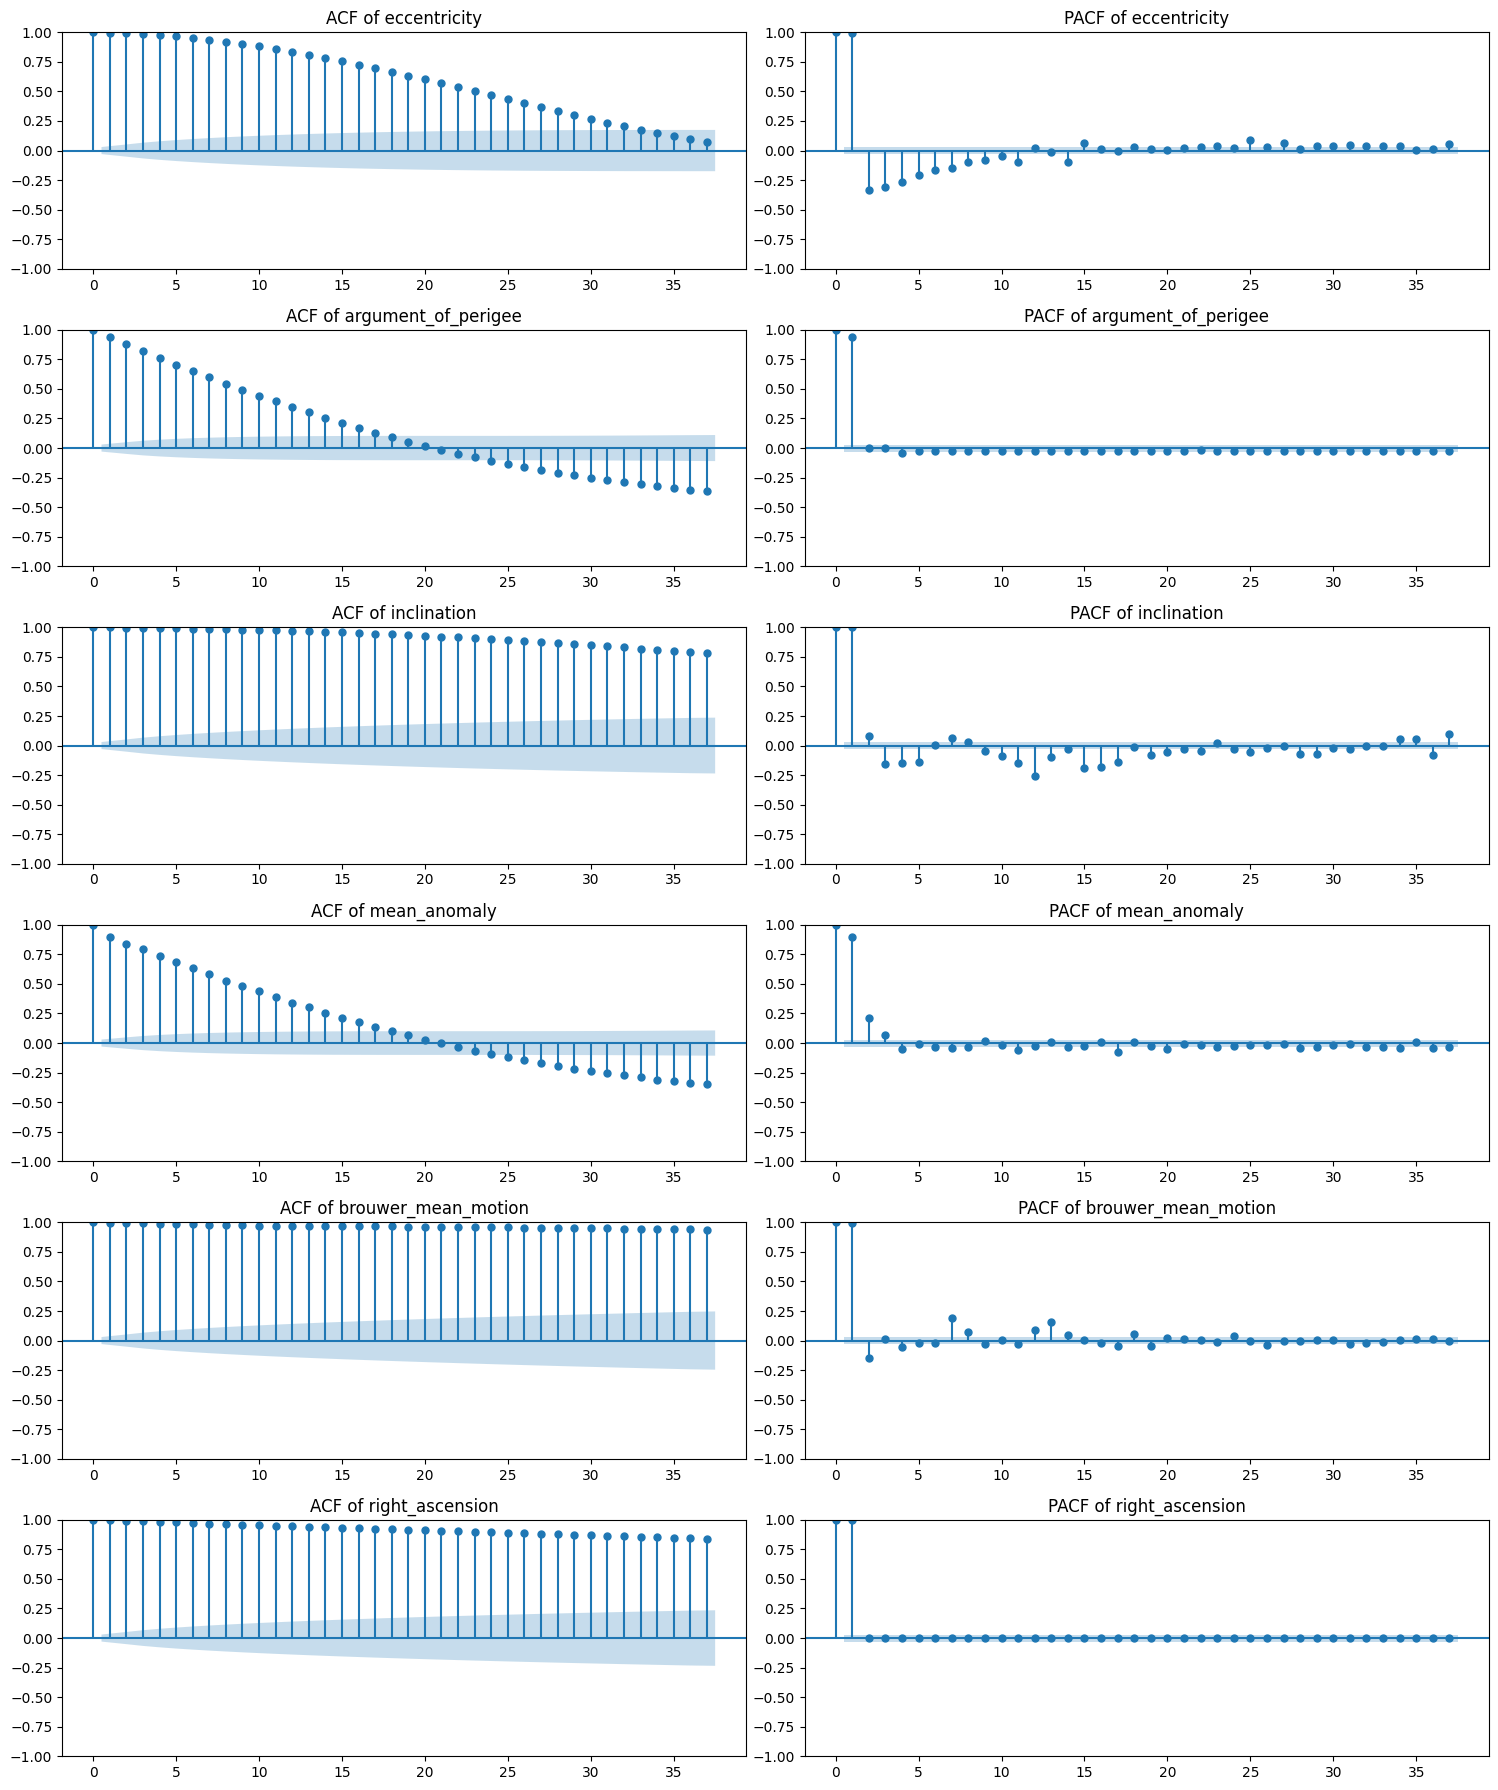

In [ ]:
acf_pacf(cs2_tle)

## Stationary Test: ADF Test

In [ ]:
adf_test(cs2_tle)

Augmented Dickey-Fuller Test: eccentricity
ADF Test Statistic               -4.149340
p-value                           0.000802
#Lags Used                       29.000000
Number of Observations Used    4278.000000
Critical Value (1%)              -3.431880
Critical Value (5%)              -2.862216
Critical Value (10%)             -2.567130

Augmented Dickey-Fuller Test: argument_of_perigee
ADF Test Statistic            -1.340420e+01
p-value                        4.503985e-25
#Lags Used                     3.100000e+01
Number of Observations Used    4.276000e+03
Critical Value (1%)           -3.431880e+00
Critical Value (5%)           -2.862216e+00
Critical Value (10%)          -2.567130e+00

Augmented Dickey-Fuller Test: inclination
ADF Test Statistic            -1.132975e+01
p-value                        1.120330e-20
#Lags Used                     3.000000e+01
Number of Observations Used    4.277000e+03
Critical Value (1%)           -3.431880e+00
Critical Value (5%)           -2.8

## Exploratory Data Analysis

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4308 entries, 2010-04-25 12:13:31.467936 to 2022-09-28 13:32:45.927743
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   eccentricity         4308 non-null   float64
 1   argument_of_perigee  4308 non-null   float64
 2   inclination          4308 non-null   float64
 3   mean_anomaly         4308 non-null   float64
 4   brouwer_mean_motion  4308 non-null   float64
 5   right_ascension      4308 non-null   float64
dtypes: float64(6)
memory usage: 235.6 KB
None
       eccentricity  argument_of_perigee  inclination  mean_anomaly  \
count   4308.000000          4308.000000  4308.000000   4308.000000   
mean       0.000823             2.812684     1.606134     -2.818992   
std        0.000233             1.789181     0.000105      1.806961   
min        0.000224             0.003416     1.605876     -6.279445   
25%        0.000650             1.310100  

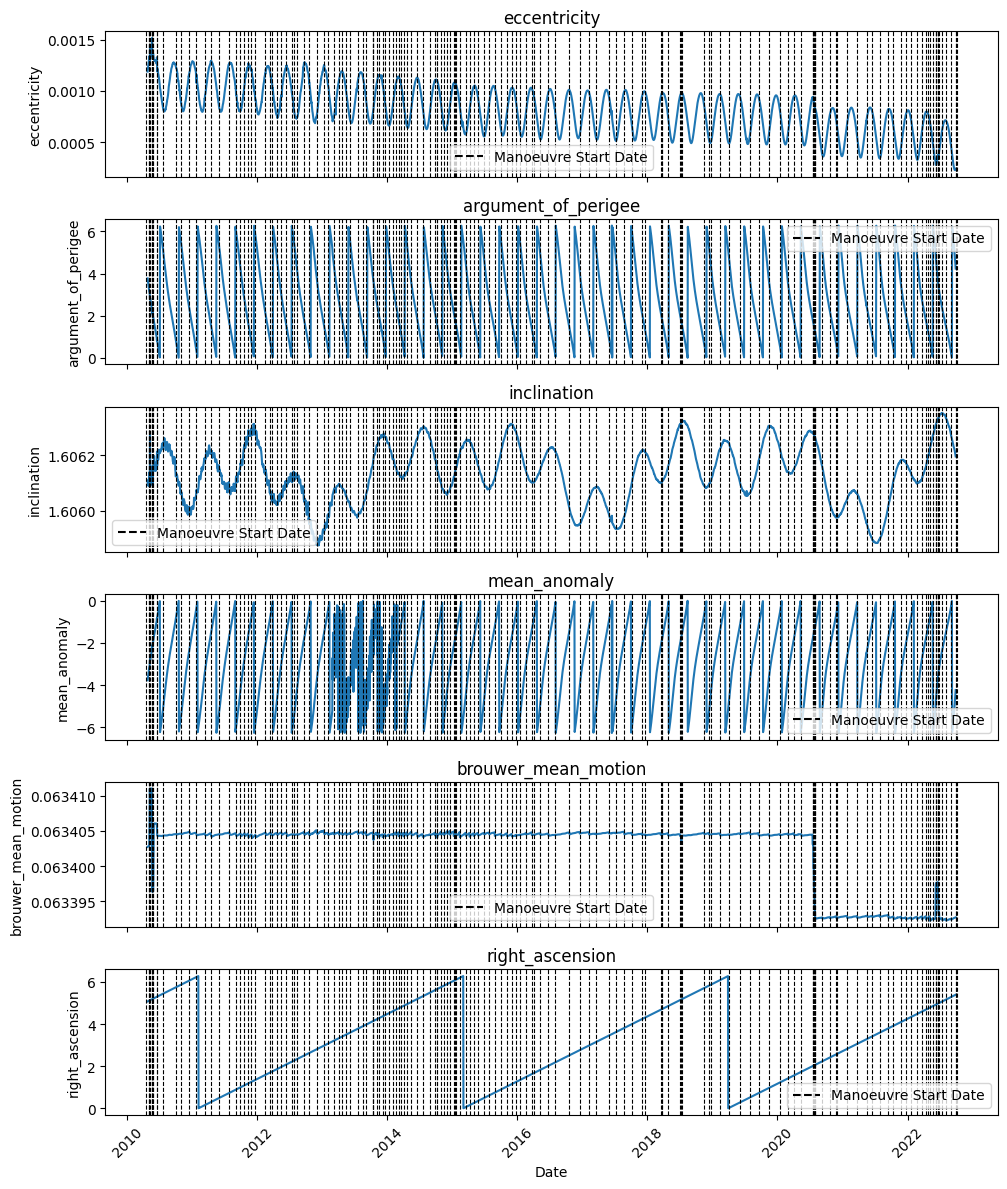

In [ ]:
eda(cs2_tle, cs2man)

## Exploratory Data Analysis Filtered

In [ ]:
cs2man_filtered = cs2man[(cs2man['start_date'] >= pd.Timestamp('2022-01-01')) &
                                   (cs2man['start_date'] < pd.Timestamp('2022-06-01'))]['start_date']

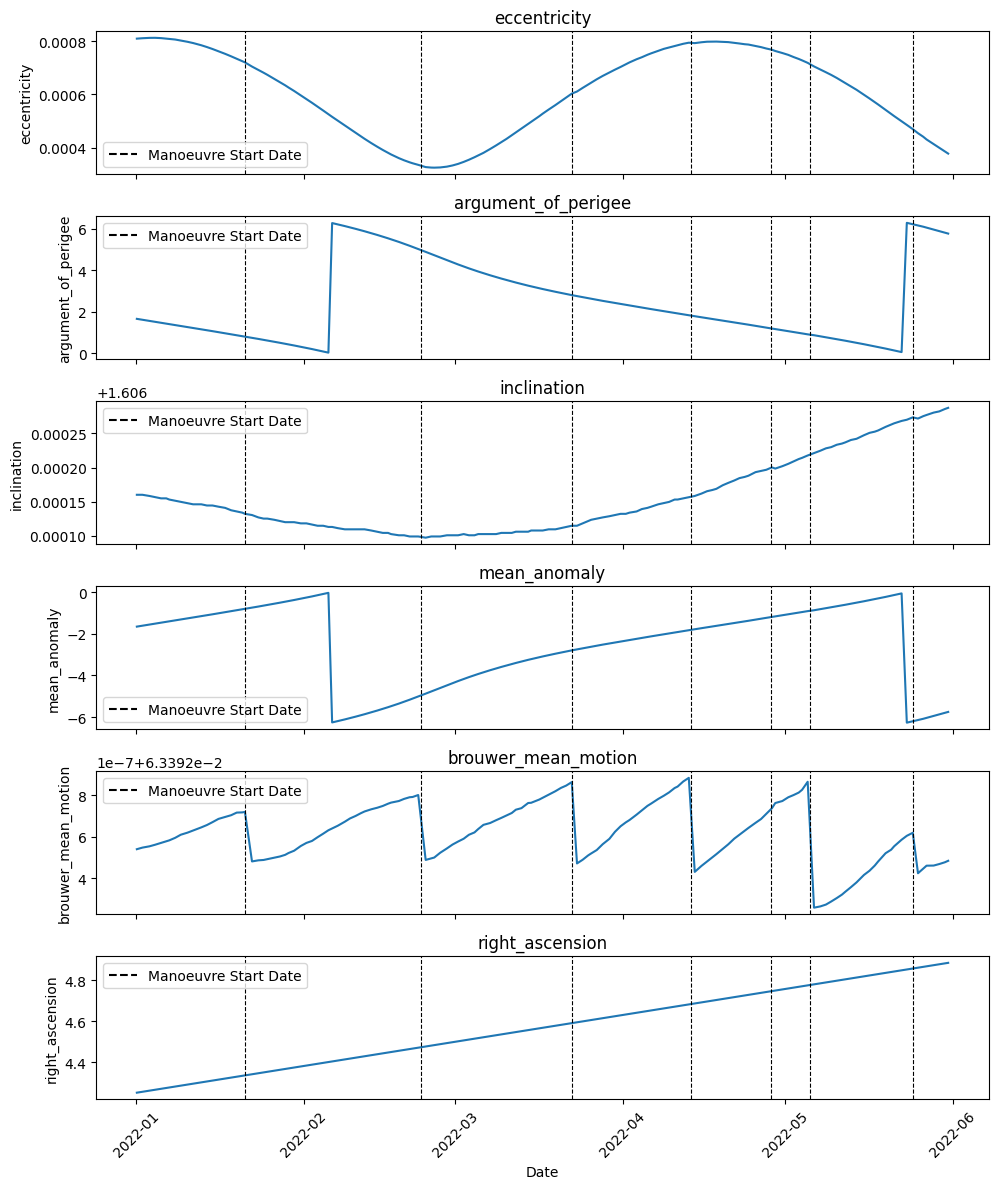

In [ ]:
eda_filtered(cs2_tle, cs2man, '2022-01-01', '2022-06-01')

## ARIMA Model and Plotting Residuals

### Eccentricity

Best ARIMA order: (3, 0, 2) with MSE: 6.692662062390087e-07


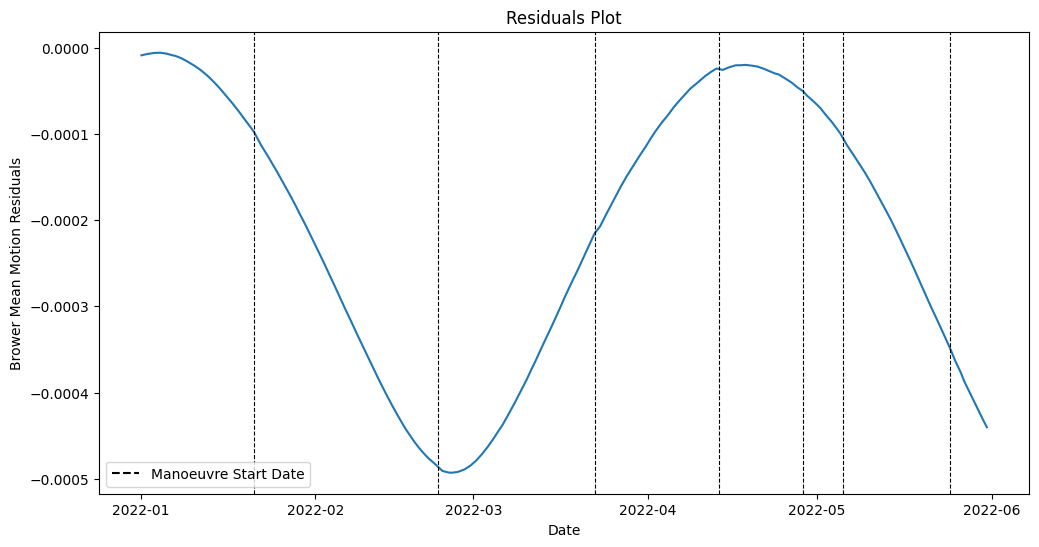

In [ ]:
cs2ecc_best_model = best_arima_fit(cs2_tle['eccentricity'])

plot_residuals(cs2ecc_best_model,cs2man, '2022-01-01', '2022-06-01')

### Argument of Perigee

Best ARIMA order: (3, 0, 0) with MSE: 10.716441002486638


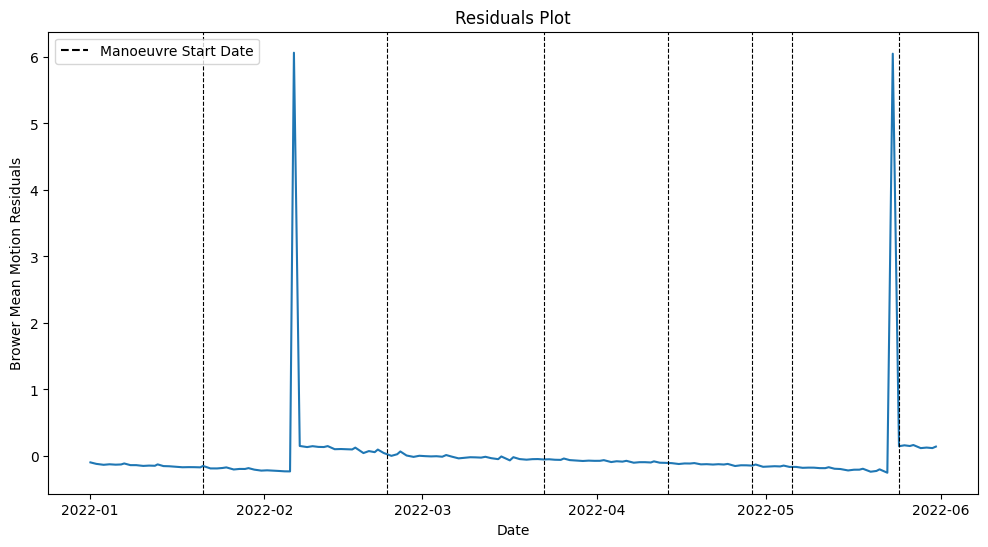

In [ ]:
cs2aop_best_model = best_arima_fit(cs2_tle['argument_of_perigee'])

plot_residuals(cs2aop_best_model,cs2man, '2022-01-01', '2022-06-01')

### Inclination

Best ARIMA order: (3, 0, 2) with MSE: 2.5791100223747856


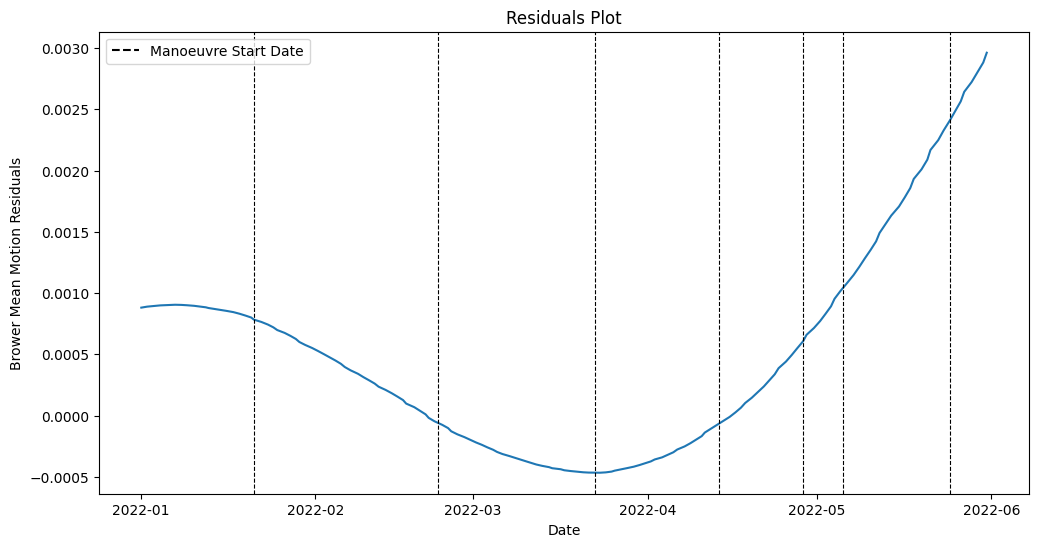

In [ ]:
cs2inc_best_model = best_arima_fit(cs2_tle['inclination'])

plot_residuals(cs2inc_best_model,cs2man, '2022-01-01', '2022-06-01')

### Mean Anomaly

Best ARIMA order: (1, 0, 0) with MSE: 10.55213158150363


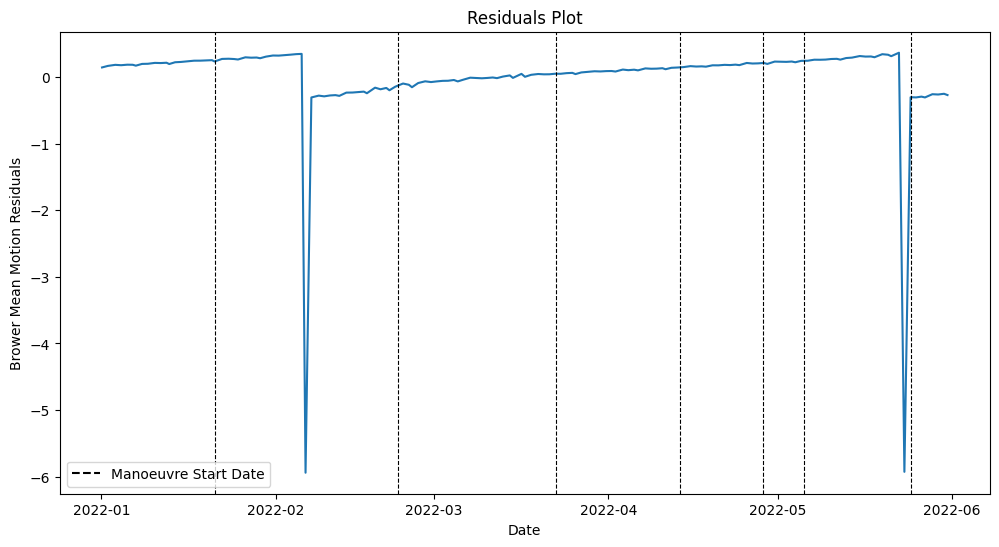

In [ ]:
cs2ma_best_model = best_arima_fit(cs2_tle['mean_anomaly'])

plot_residuals(cs2ma_best_model,cs2man, '2022-01-01', '2022-06-01')

### Brouwer Mean Motion

Best ARIMA order: (2, 2, 2) with MSE: 0.004019860111543771


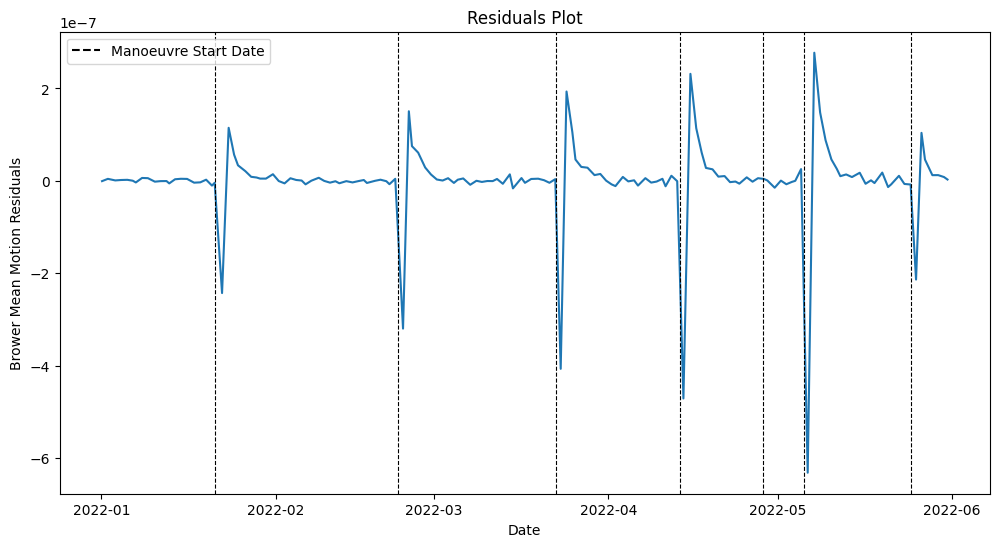

In [ ]:
cs2bmm_best_model = best_arima_fit(cs2_tle['brouwer_mean_motion'])

plot_residuals(cs2bmm_best_model,cs2man, '2022-01-01', '2022-06-01')

### Right Ascension

Best ARIMA order: (1, 0, 2) with MSE: 13.143844952025523


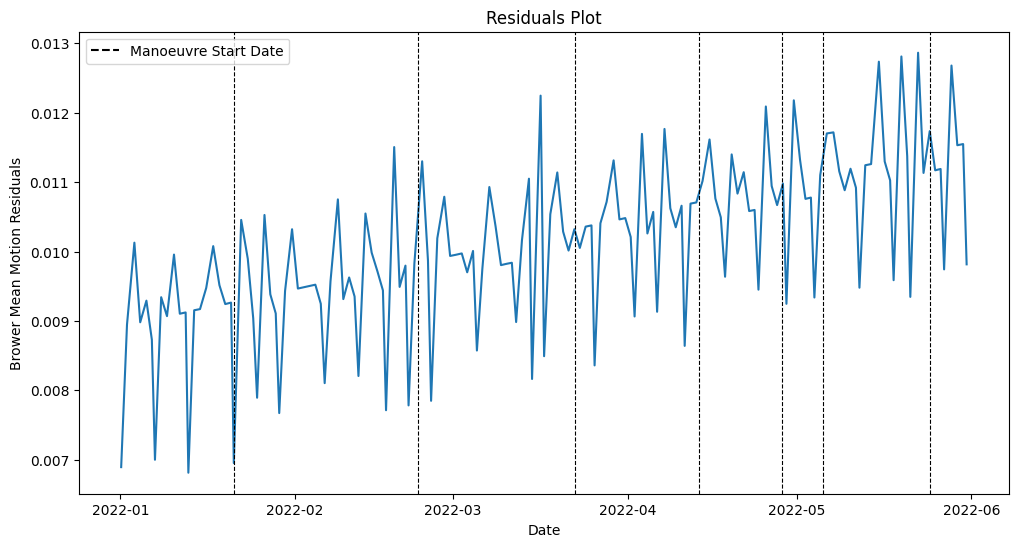

In [ ]:
cs2ra_best_model = best_arima_fit(cs2_tle['right_ascension'])

plot_residuals(cs2ra_best_model,cs2man, '2022-01-01', '2022-06-01')

### ARIMA Precision Recall Curve

Precision at Best F1: 0.8947368421052632
Recall at Best F1: 0.8095238095238095
Best F1 Score: 0.8499999999501251


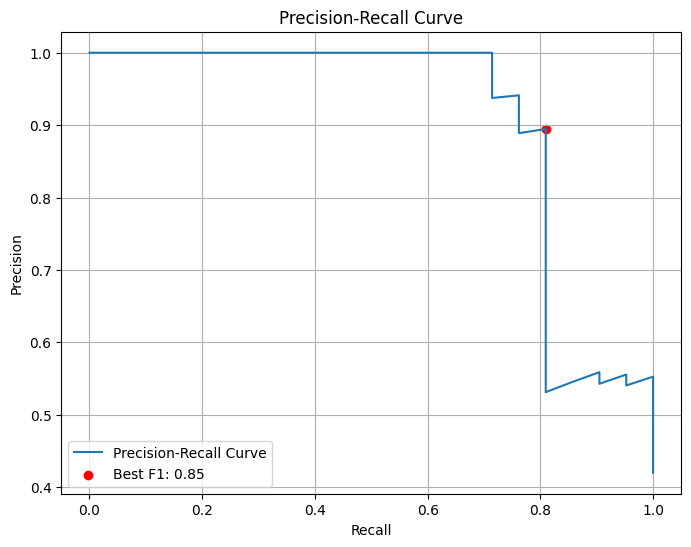

In [ ]:
# Filtered residuals and maneuver timestamps,
cs2_arima_bmm_filtered_pred = cs2bmm_best_model.fittedvalues[(cs2bmm_best_model.resid.index >= pd.Timestamp('2022-01-01')) &
                                      (cs2bmm_best_model.resid.index < pd.Timestamp('2022-06-01'))]

# Define parameters for evaluate_model_performance
float_matching_max_days = 5
float_threshold = 0.001

# Calculate precision and recall
cs2_ar_precision, cs2_ar_recall = evaluate_model_performance(
    float_matching_max_days,
    float_threshold,
    cs2man,
    cs2_arima_bmm_filtered_pred
)

plot_precision_recall_curve_from_model(
    float_matching_max_days=5,
    pd_series_ground_truth_manoeuvre_timestamps=cs2man,
    pd_series_predictions=cs2_arima_bmm_filtered_pred
)

## XGBoost

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


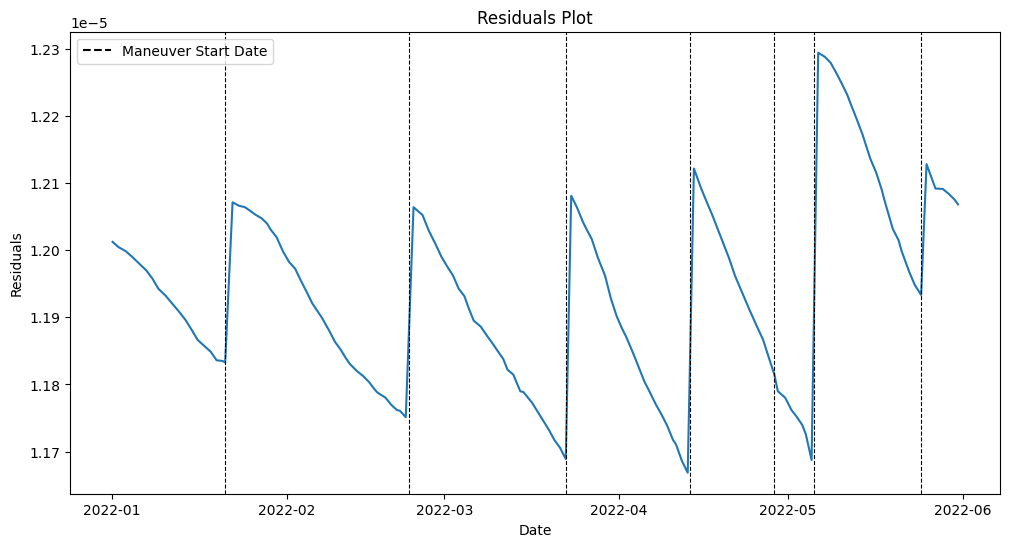

In [ ]:
cs2_bmm_xgb, cs2_bmm_xgb_y_test, cs2_bmm_xgb_y_pred, cs2_bmm_xgb_residuals, cs2_bmm_xgb_anomaly_indices = xgboost_with_grid_search(
    data = cs2_tle,
    target_column='brouwer_mean_motion',
    lag = 3
)

plot_xgboost_residuals(cs2_bmm_xgb_y_test, cs2_bmm_xgb_y_pred, cs2man, '2022-01-01', '2022-06-01')

Precision at Best F1: 0.8421052631578947
Recall at Best F1: 0.6666666666666666
Best F1 Score: 0.744186046462304


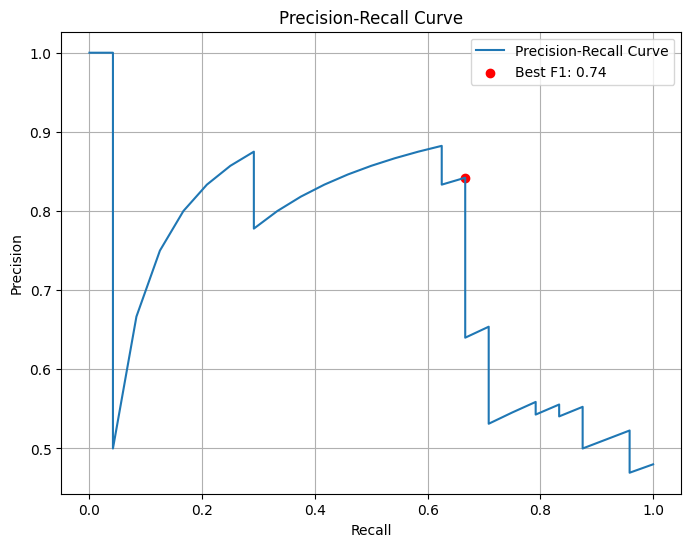

In [ ]:
# Filtered residuals and maneuver timestamps
cs2_xgb_bmm_predictions_series = pd.Series(
    cs2_bmm_xgb_y_pred,
    index=cs2_bmm_xgb_y_test.index
)

# Define parameters for evaluate_model_performance
float_matching_max_days = 5
float_threshold = 0.001

# Calculate precision and recall
precision, recall = evaluate_model_performance(
    float_matching_max_days,
    float_threshold,
    cs2man_filtered,
    cs2_xgb_bmm_predictions_series
)

plot_precision_recall_curve_from_model(
    float_matching_max_days=5,
    pd_series_ground_truth_manoeuvre_timestamps=cs2man,
    pd_series_predictions=cs2_xgb_bmm_predictions_series
)

## CatBoost

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'depth': 4, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.01}


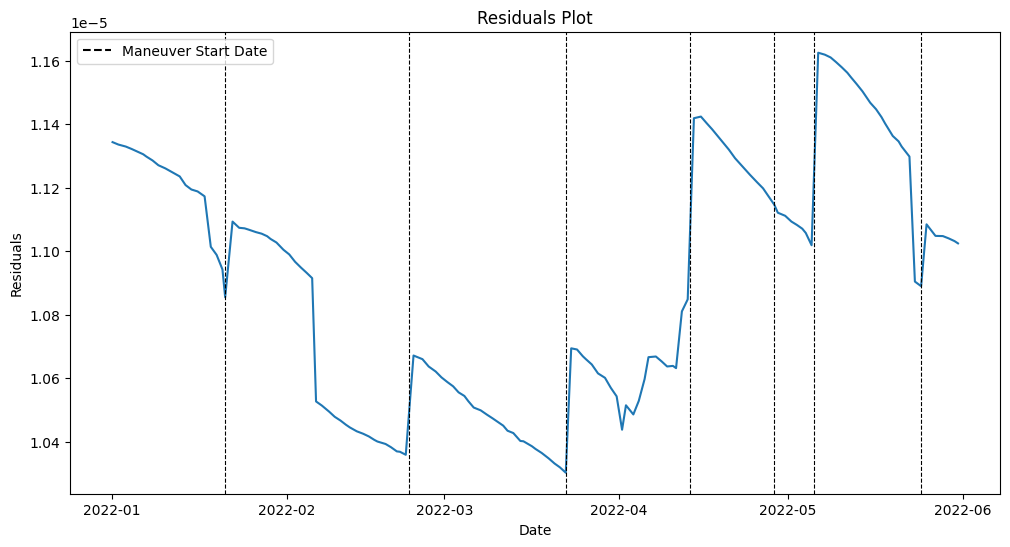

In [ ]:
cs2_bmm_cab, cs2_bmm_cab_y_test, cs2_bmm_cab_y_pred, cs2_bmm_cab_residuals, cs2_bmm_cab_anomaly_indices = catboost_with_grid_search(
    data = cs2_tle,
    target_column='brouwer_mean_motion',
    lag = 3
)

plot_xgboost_residuals(cs2_bmm_cab_y_test, cs2_bmm_cab_y_pred, cs2man, '2022-01-01', '2022-06-01')

Precision at Best F1: 0.54
Recall at Best F1: 1.0
Best F1 Score: 0.7012987012531624


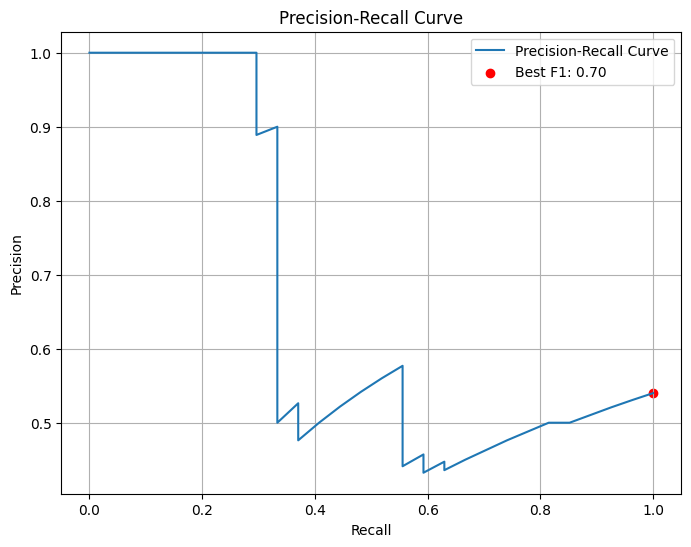

In [ ]:
# Filtered residuals and maneuver timestamps
cs2_cab_bmm_predictions_series = pd.Series(
    cs2_bmm_cab_y_pred,
    index=cs2_bmm_cab_y_test.index  # Using the same index as the ground truth for alignment
)

# Define parameters for evaluate_model_performance
float_matching_max_days = 5  # set the max days to match predictions to ground truth
float_threshold = 0.01        # set a threshold for considering anomalies

# Calculate precision and recall
precision, recall = evaluate_model_performance(
    float_matching_max_days,
    float_threshold,
    cs2man,
    cs2_cab_bmm_predictions_series
)

plot_precision_recall_curve_from_model(
    float_matching_max_days=5,
    pd_series_ground_truth_manoeuvre_timestamps=cs2man_filtered,
    pd_series_predictions=cs2_cab_bmm_predictions_series
)

## Multivariate ARIMA

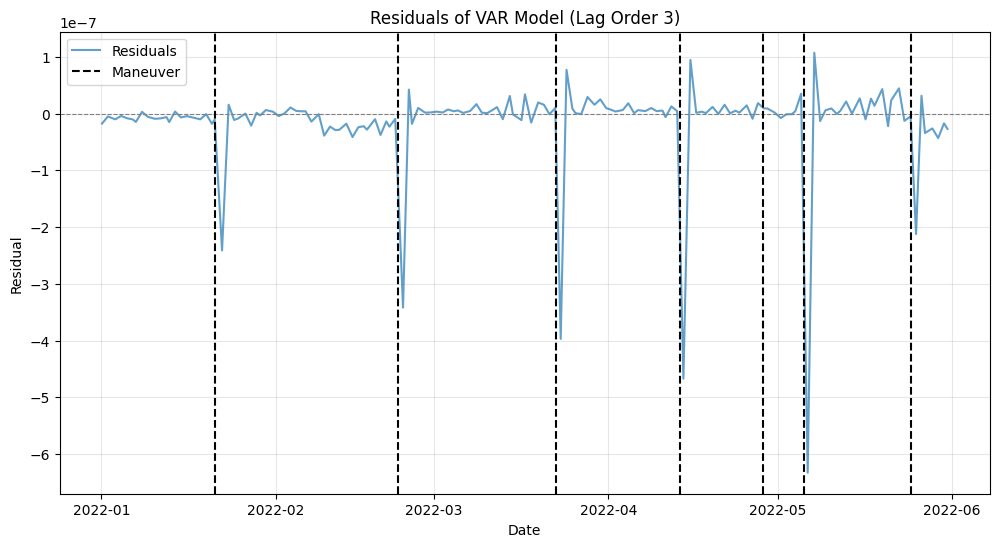

Best VAR lag order: 3 with MSE: 7.088969246633271e-14


In [ ]:
cs2_varima_best_model, best_lag_order = best_var_fit(cs2_tle, target_variable='brouwer_mean_motion', maneuver_dates = cs2man['start_date'], max_lag = 3, start_date = '2022-01-01', end_date = '2022-06-01')

Precision at Best F1: 0.7105263157894737
Recall at Best F1: 0.9642857142857143
Best F1 Score: 0.8181818181329661


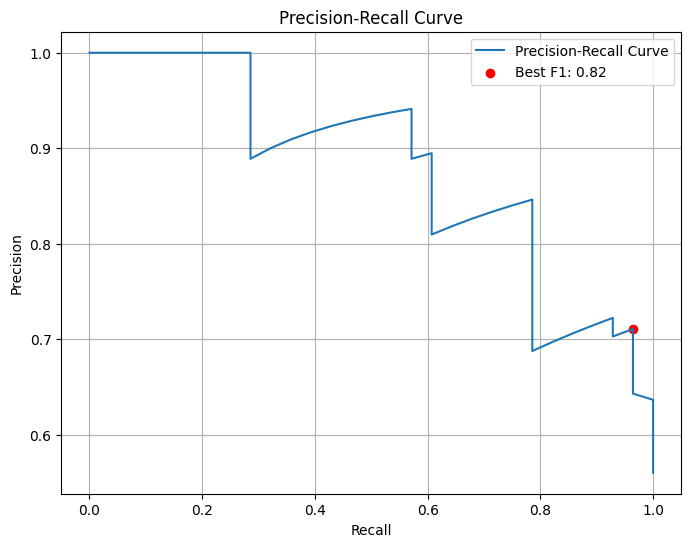

In [ ]:
# Filtered residuals and maneuver timestamps,
cs2_varima_bmm_filtered_pred = cs2_varima_best_model.fittedvalues[(cs2_varima_best_model.resid.index >= pd.Timestamp('2022-01-01')) &
                                      (cs2_varima_best_model.resid.index < pd.Timestamp('2022-06-01'))]

# Define parameters for evaluate_model_performance
float_matching_max_days = 5 # set the max days to match predictions to ground truth
float_threshold = 0.001        # set a threshold for considering anomalies

# Calculate precision and recall
cs2_var_precision, cs2_var_recall = evaluate_model_performance(
    float_matching_max_days,
    float_threshold,
    cs2man,
    cs2_varima_bmm_filtered_pred
)

plot_precision_recall_curve_from_model(
    float_matching_max_days=5,
    pd_series_ground_truth_manoeuvre_timestamps=cs2man,
    pd_series_predictions=cs2_varima_bmm_filtered_pred
)

# Haiyang-2A

## Importing Datasets

In [ ]:
h2a_tle = read_satellite_data('unpropagated_elements_Haiyang-2A.csv')
h2a_tle.head()

eccentricity  argument of perigee  inclination  \
2011-10-08 03:08:31.065504      0.000158             1.456236     1.734299   
2011-10-09 01:46:27.454367      0.000158             1.412851     1.734299   
2011-10-10 03:53:18.699936      0.000149             1.414537     1.734285   
2011-10-11 02:31:15.109536      0.000147             1.360987     1.734292   
2011-10-12 02:53:38.975135      0.000150             1.457867     1.734280   

                            mean anomaly  Brouwer mean motion  right ascension  
2011-10-08 03:08:31.065504     -1.453913             0.060217         5.018305  
2011-10-09 01:46:27.454367     -1.410530             0.060217         5.034573  
2011-10-10 03:53:18.699936     -1.412231             0.060217         5.053360  
2011-10-11 02:31:15.109536     -1.358690             0.060217         5.069649  
2011-10-12 02:53:38.975135     -1.455514             0.060217         5.087160

In [ ]:
h2aman = extract_start_end_dates('h2aman.txt')
h2aman.head()

start_date            end_date
0 2011-09-28 16:20:00 2011-09-28 16:20:00
1 2012-02-14 03:05:00 2012-02-14 03:05:00
2 2012-02-24 03:20:00 2012-02-24 03:20:00
3 2012-04-20 03:20:00 2012-04-20 03:20:00
4 2012-06-08 02:35:00 2012-06-08 02:35:00

## Formatting the Columns

In [ ]:
format_cols(h2a_tle)
h2a_tle.head()

eccentricity  argument_of_perigee  inclination  \
2011-10-08 03:08:31.065504      0.000158             1.456236     1.734299   
2011-10-09 01:46:27.454367      0.000158             1.412851     1.734299   
2011-10-10 03:53:18.699936      0.000149             1.414537     1.734285   
2011-10-11 02:31:15.109536      0.000147             1.360987     1.734292   
2011-10-12 02:53:38.975135      0.000150             1.457867     1.734280   

                            mean_anomaly  brouwer_mean_motion  right_ascension  
2011-10-08 03:08:31.065504     -1.453913             0.060217         5.018305  
2011-10-09 01:46:27.454367     -1.410530             0.060217         5.034573  
2011-10-10 03:53:18.699936     -1.412231             0.060217         5.053360  
2011-10-11 02:31:15.109536     -1.358690             0.060217         5.069649  
2011-10-12 02:53:38.975135     -1.455514             0.060217         5.087160

## Checking for Duplicates

In [ ]:
check_duplicates(h2a_tle)

No duplicates


## Missing Values

In [ ]:
missing_values(h2a_tle)

Percentage of missing value in entire dataset is: 0.0%


## ACF and PACF Plots

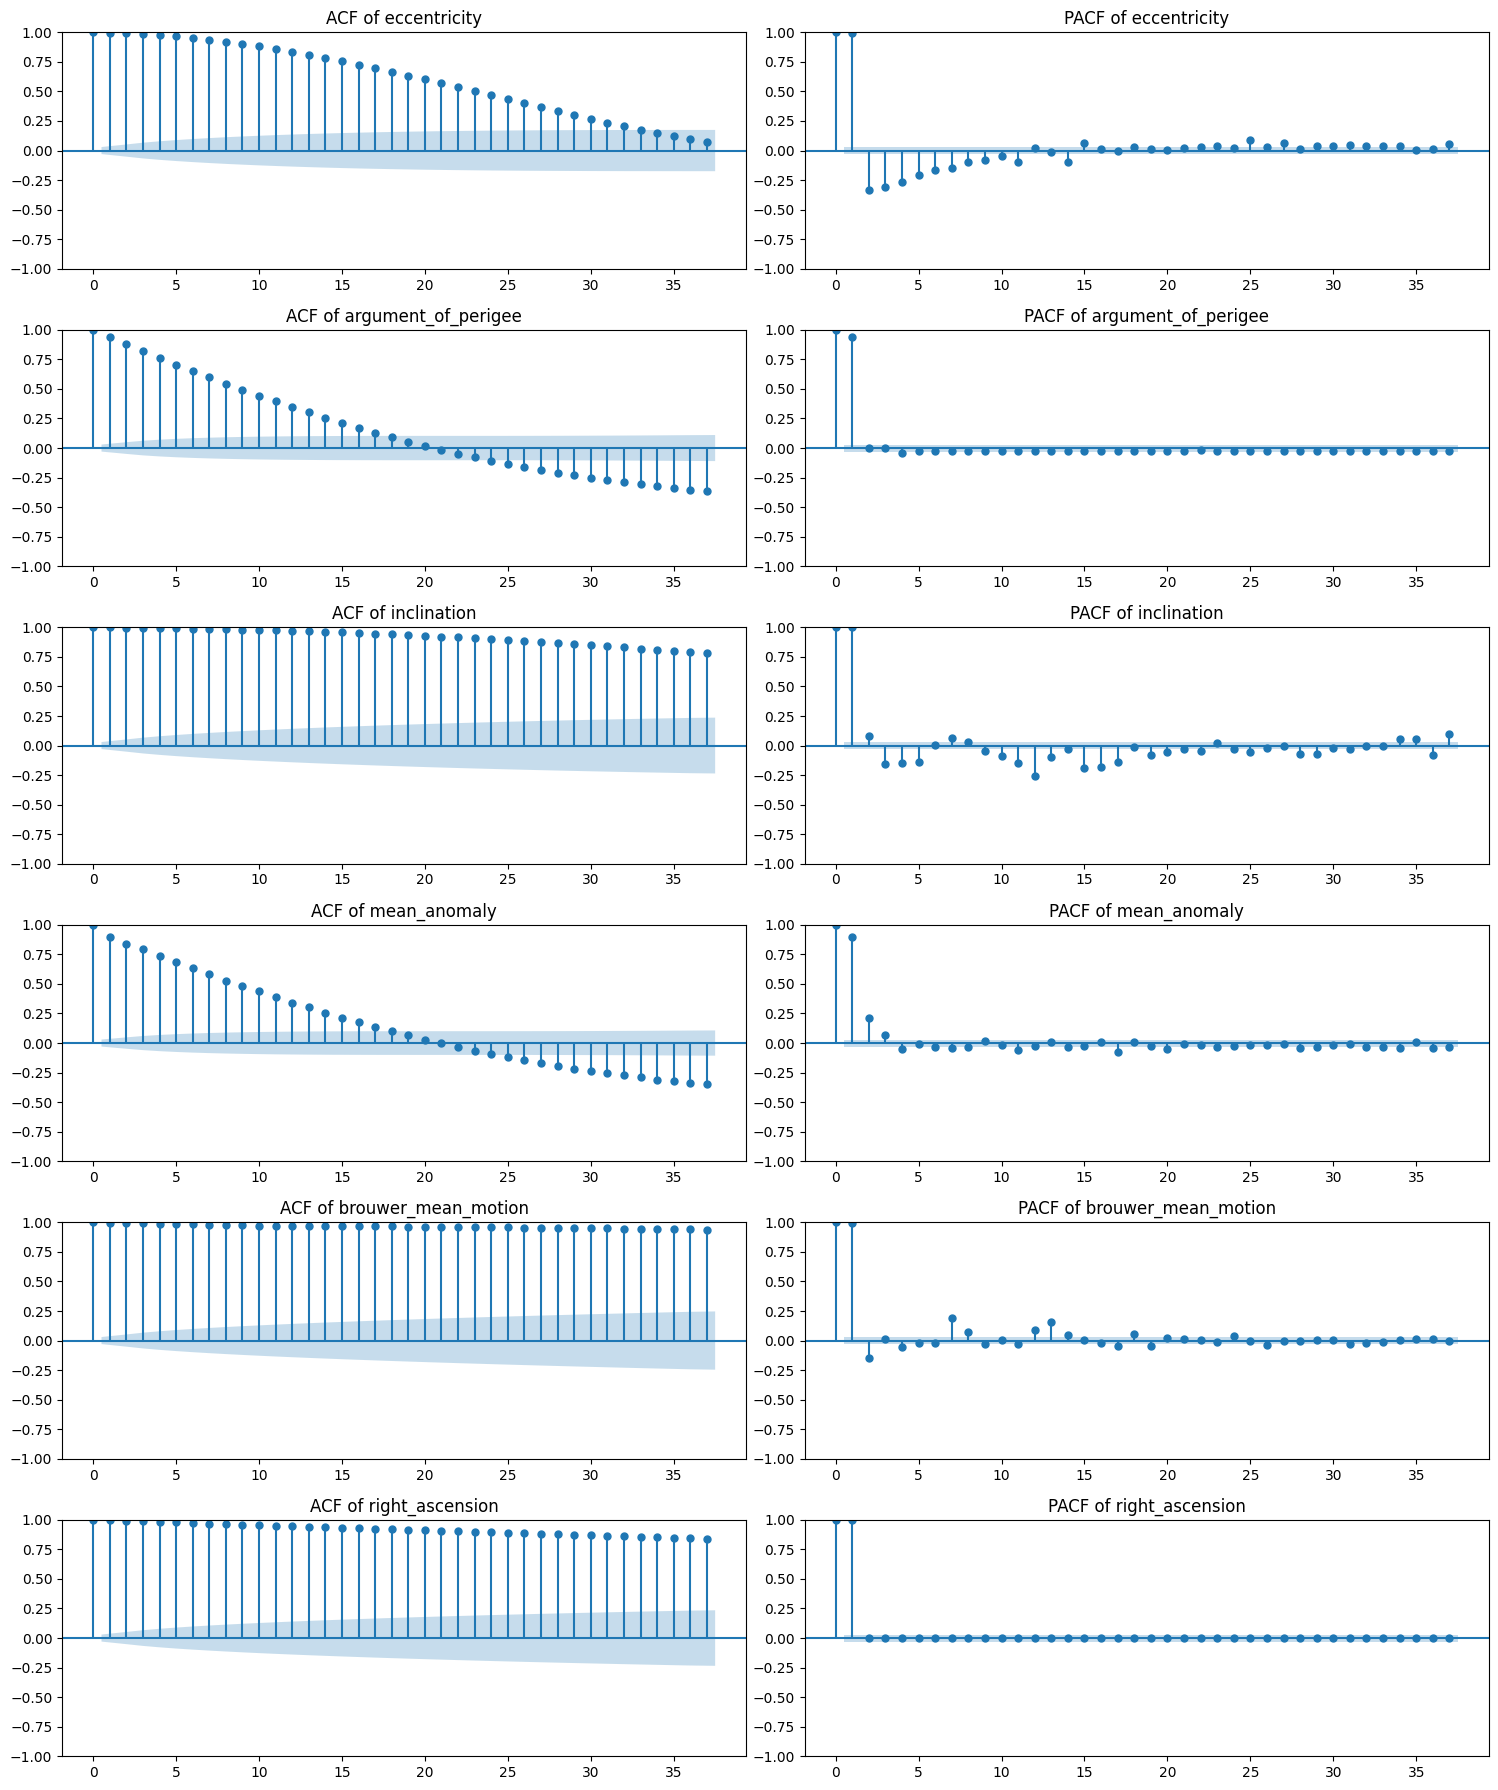

In [ ]:
acf_pacf(h2a_tle)

## Stationary Test: ADF Test

In [ ]:
adf_test(h2a_tle)

Augmented Dickey-Fuller Test: eccentricity
ADF Test Statistic            -1.197919e+01
p-value                        3.739411e-22
#Lags Used                     2.900000e+01
Number of Observations Used    2.968000e+03
Critical Value (1%)           -3.432555e+00
Critical Value (5%)           -2.862514e+00
Critical Value (10%)          -2.567289e+00

Augmented Dickey-Fuller Test: argument_of_perigee
ADF Test Statistic            -9.278674e+00
p-value                        1.268450e-15
#Lags Used                     2.800000e+01
Number of Observations Used    2.969000e+03
Critical Value (1%)           -3.432554e+00
Critical Value (5%)           -2.862514e+00
Critical Value (10%)          -2.567288e+00

Augmented Dickey-Fuller Test: inclination
ADF Test Statistic               -0.252252
p-value                           0.932000
#Lags Used                       19.000000
Number of Observations Used    2978.000000
Critical Value (1%)              -3.432548
Critical Value (5%)             

## Exploratory Data Analysis

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2998 entries, 2011-10-08 03:08:31.065504 to 2020-06-02 01:53:24.932255
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   eccentricity         2998 non-null   float64
 1   argument_of_perigee  2998 non-null   float64
 2   inclination          2998 non-null   float64
 3   mean_anomaly         2998 non-null   float64
 4   brouwer_mean_motion  2998 non-null   float64
 5   right_ascension      2998 non-null   float64
dtypes: float64(6)
memory usage: 164.0 KB
None
       eccentricity  argument_of_perigee  inclination  mean_anomaly  \
count   2998.000000          2998.000000  2998.000000   2998.000000   
mean       0.000118             1.562484     1.733842     -1.566304   
std        0.000058             0.806231     0.000276      0.822871   
min        0.000002             0.014502     1.733355     -6.256930   
25%        0.000073             0.999030  

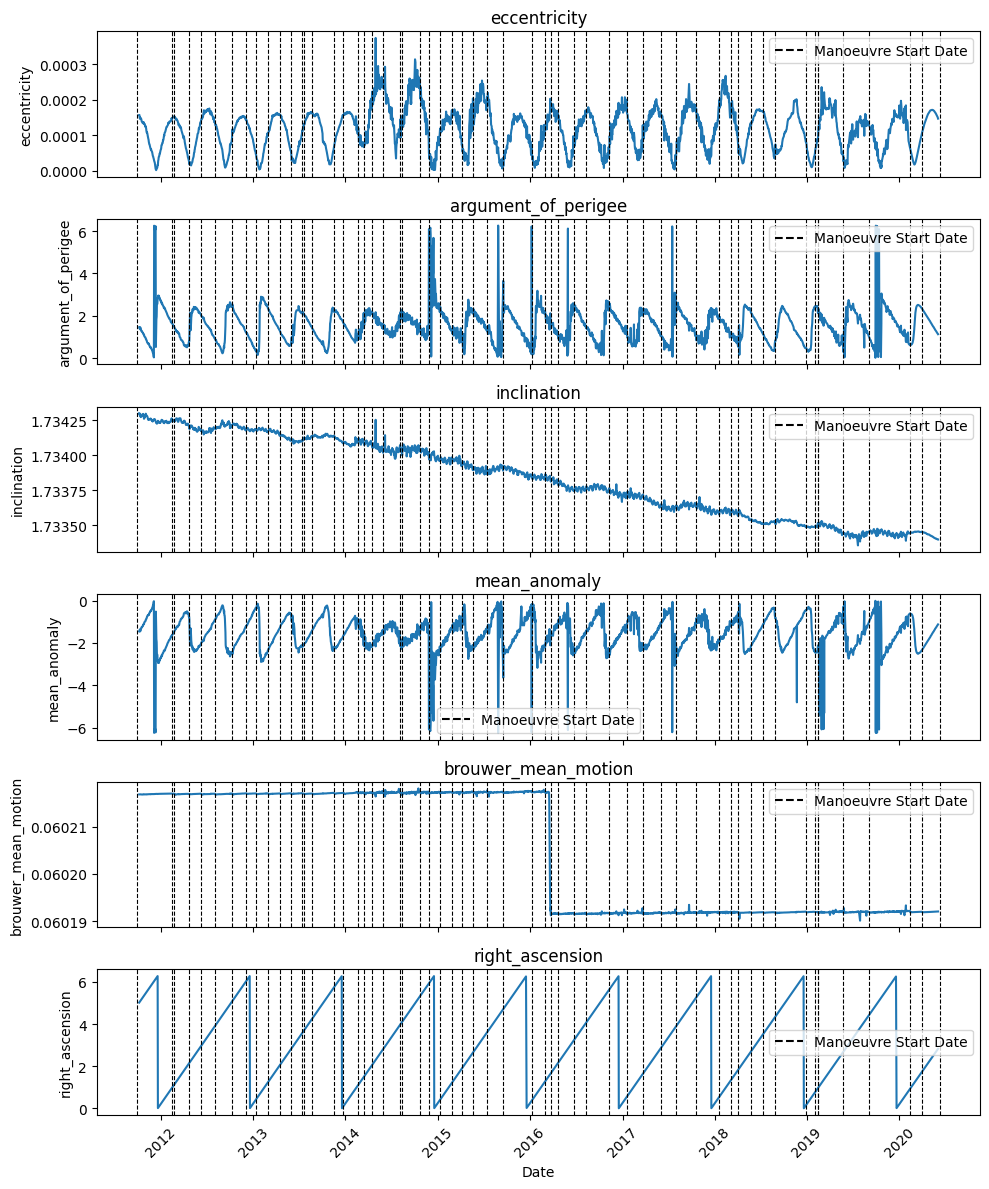

In [ ]:
eda(h2a_tle, h2aman)

## Exploratory Data Analysis Filtered

In [ ]:
h2aman_filtered = h2aman[(h2aman['start_date'] >= pd.Timestamp('2017-01-01')) &
                                   (h2aman['start_date'] < pd.Timestamp('2018-01-01'))]['start_date']

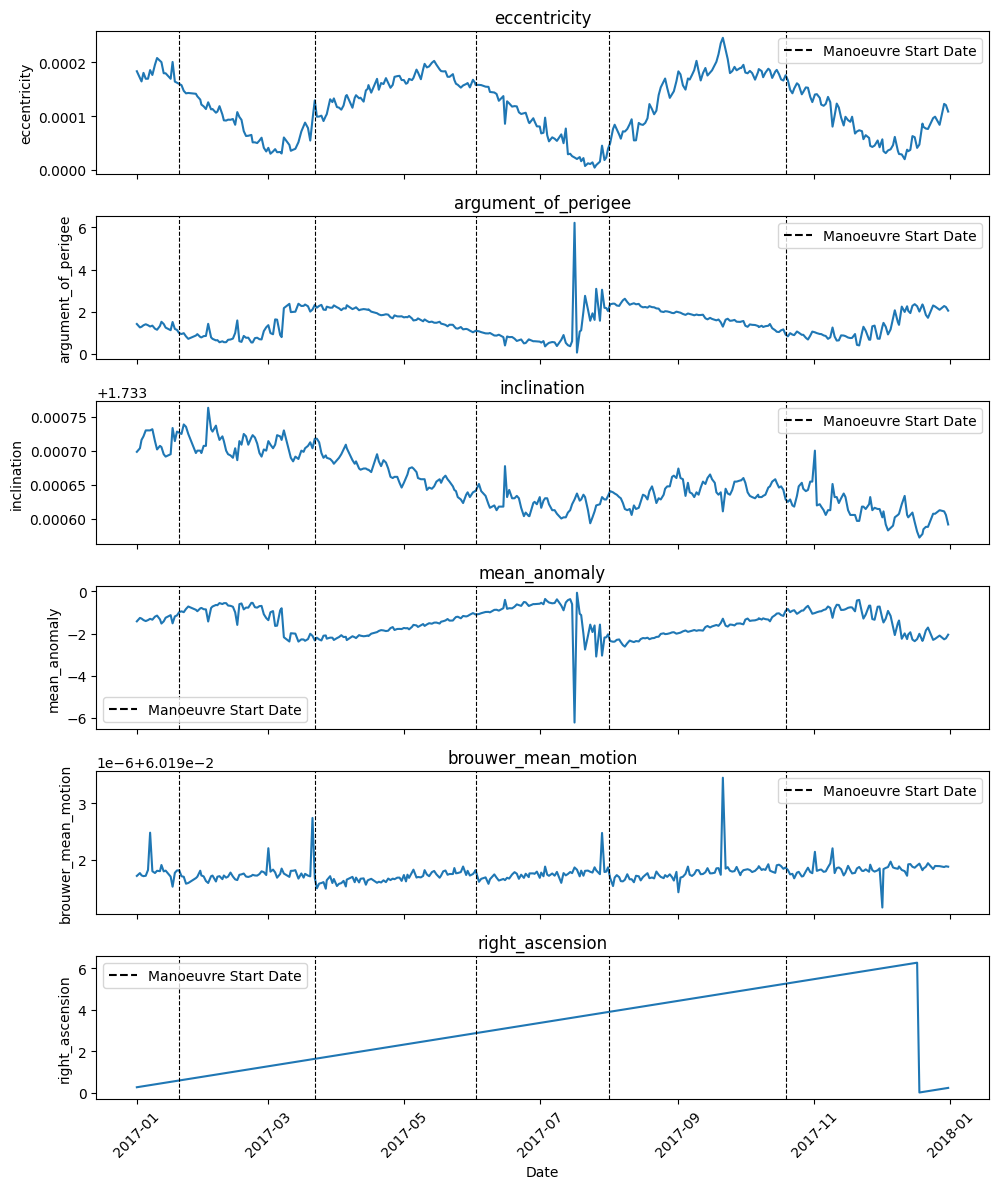

In [ ]:
eda_filtered(h2a_tle, h2aman, '2017-01-01', '2018-01-01')

## ARIMA Model and Plotting Residuals

### Eccentricity

Best ARIMA order: (1, 1, 1) with MSE: 1.6943796943697413e-08


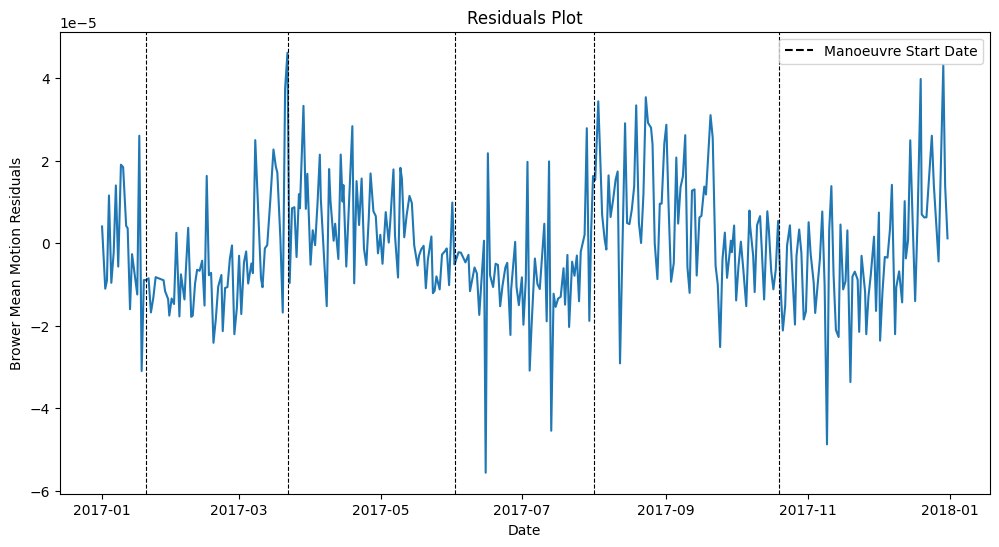

In [ ]:
h2aecc_best_model = best_arima_fit(h2a_tle['eccentricity'])

plot_residuals(h2aecc_best_model,h2aman, '2017-01-01', '2018-01-01')

### Argument of Perigee

Best ARIMA order: (1, 0, 0) with MSE: 2.86376792382794


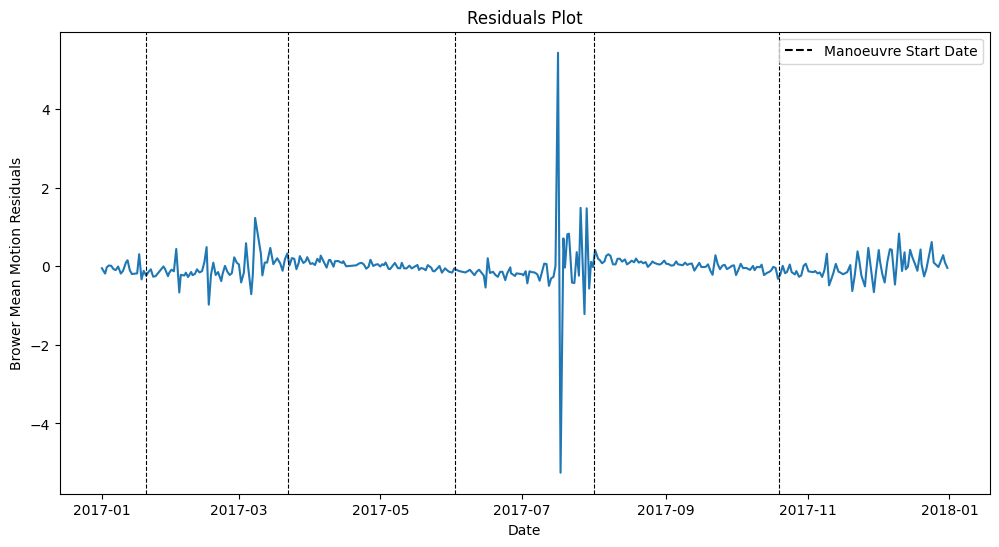

In [ ]:
h2aaop_best_model = best_arima_fit(h2a_tle['argument_of_perigee'])

plot_residuals(h2aaop_best_model,h2aman, '2017-01-01', '2018-01-01')

### Inclination

Best ARIMA order: (2, 2, 2) with MSE: 3.006206600354546


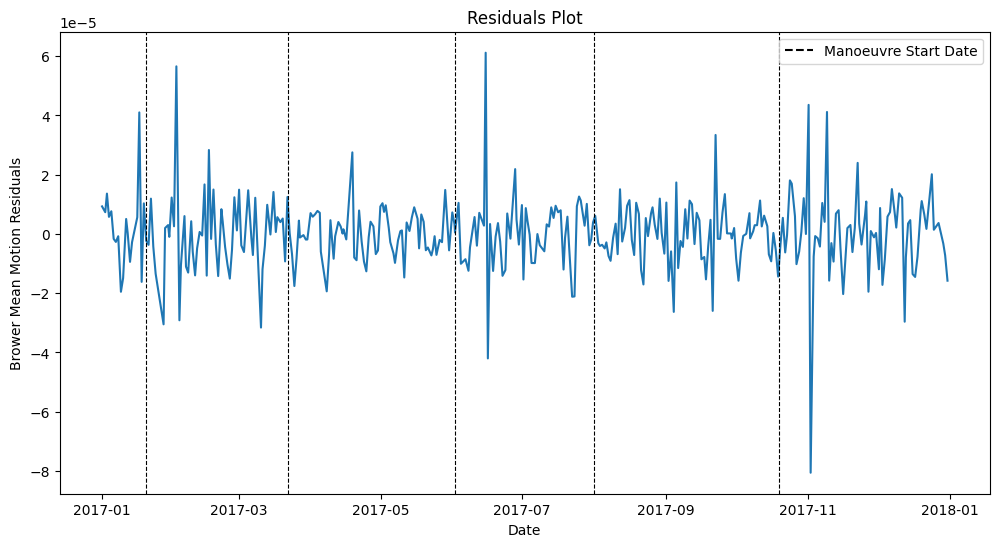

In [ ]:
h2ainc_best_model = best_arima_fit(h2a_tle['inclination'])

plot_residuals(h2ainc_best_model,h2aman, '2017-01-01', '2018-01-01')

### Mean Anomaly

Best ARIMA order: (1, 0, 0) with MSE: 2.863599950605933


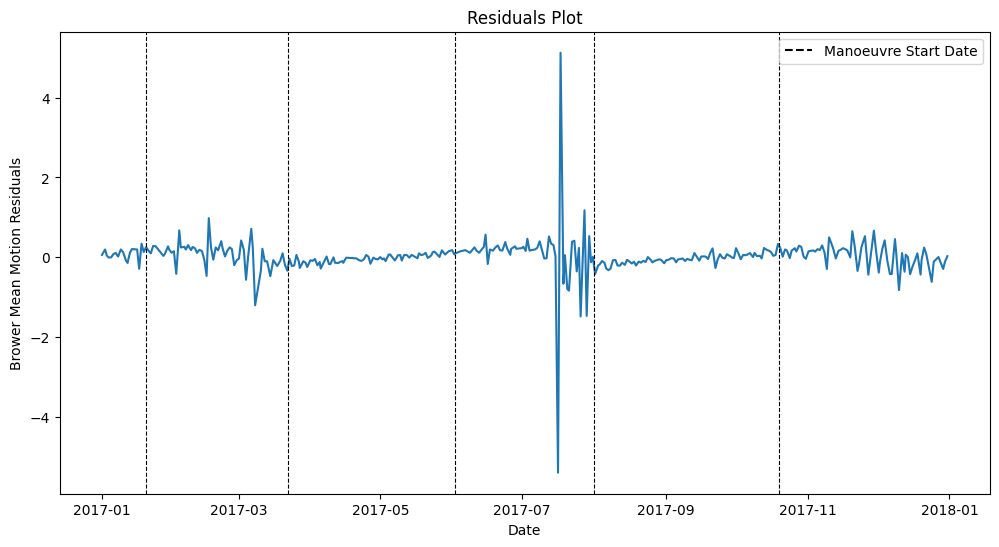

In [ ]:
h2ama_best_model = best_arima_fit(h2a_tle['mean_anomaly'])

plot_residuals(h2ama_best_model,h2aman, '2017-01-01', '2018-01-01')

### Brouwer Mean Motion

Best ARIMA order: (2, 2, 0) with MSE: 0.0036246467624824236


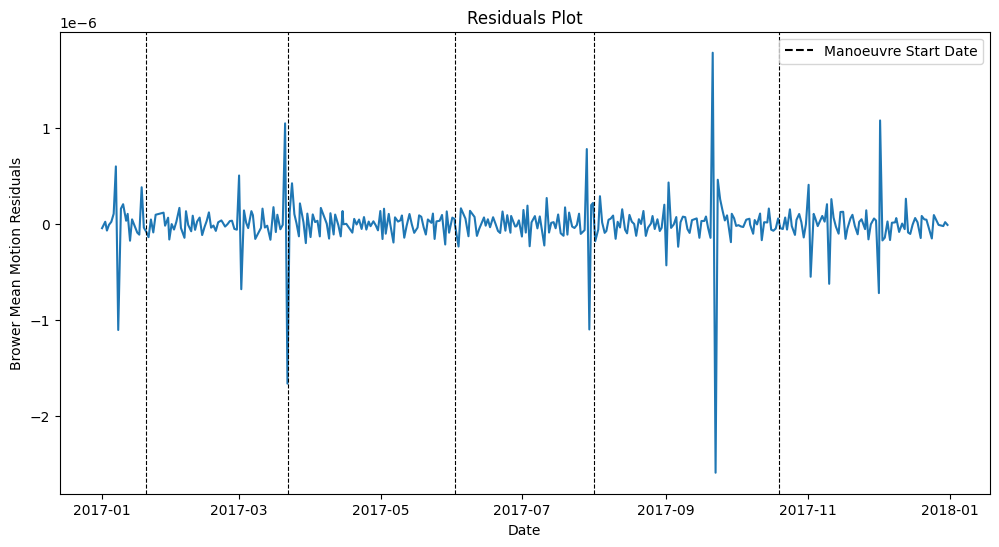

In [ ]:
h2abmm_best_model = best_arima_fit(h2a_tle['brouwer_mean_motion'])

plot_residuals(h2abmm_best_model,h2aman, '2017-01-01', '2018-01-01')

### Right Ascension

Best ARIMA order: (1, 0, 2) with MSE: 12.790177039790292


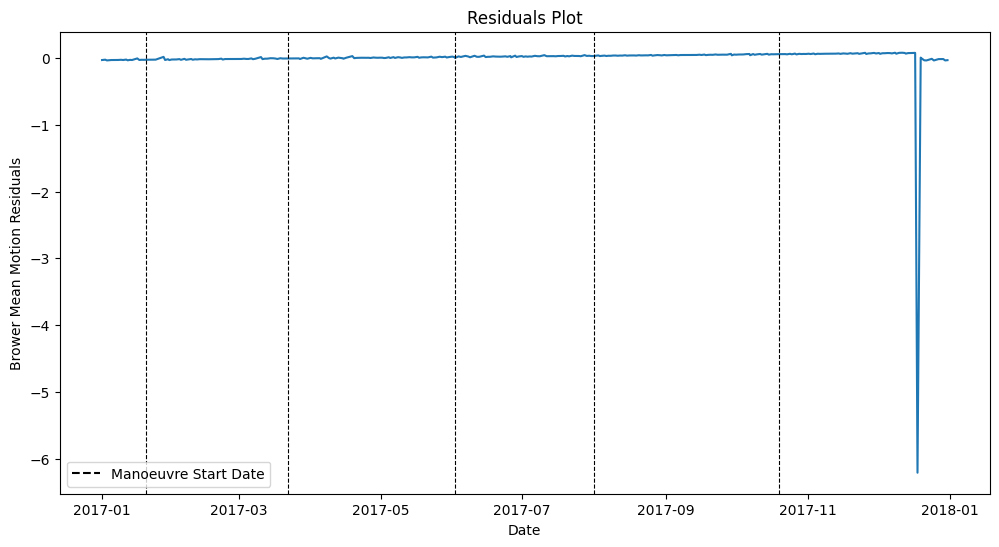

In [ ]:
h2ara_best_model = best_arima_fit(h2a_tle['right_ascension'])

plot_residuals(h2ara_best_model,h2aman, '2017-01-01', '2018-01-01')

### ARIMA PR Curve

Precision at Best F1: 0.8947368421052632
Recall at Best F1: 0.7727272727272727
Best F1 Score: 0.8292682926331946


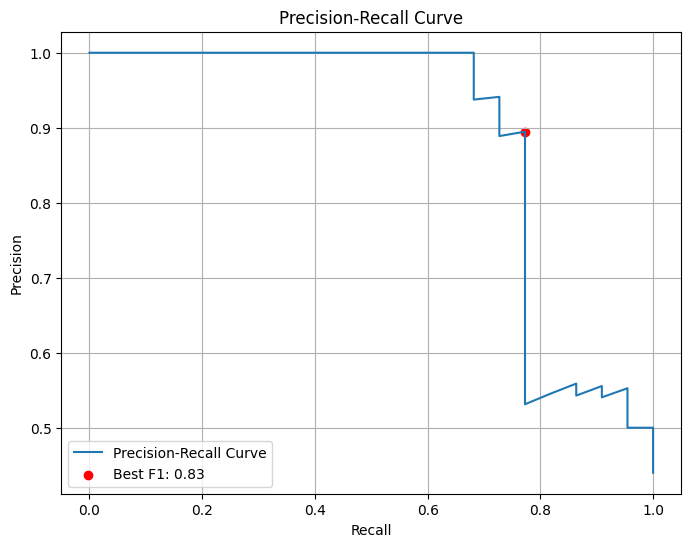

In [ ]:
# Filtered residuals and maneuver timestamps,
h2a_arima_bmm_filtered_pred = h2abmm_best_model.fittedvalues[(h2abmm_best_model.resid.index >= pd.Timestamp('2022-01-01')) &
                                      (h2abmm_best_model.resid.index < pd.Timestamp('2022-06-01'))]

# Define parameters for evaluate_model_performance
float_matching_max_days = 5 # set the max days to match predictions to ground truth
float_threshold = 0.001        # set a threshold for considering anomalies

# Calculate precision and recall
h2a_ar_precision, h2a_ar_recall = evaluate_model_performance(
    float_matching_max_days,
    float_threshold,
    h2aman,
    h2a_arima_bmm_filtered_pred
)

plot_precision_recall_curve_from_model(
    float_matching_max_days=5,
    pd_series_ground_truth_manoeuvre_timestamps=h2a_man,
    pd_series_predictions=h2a_arima_bmm_filtered_pred
)

## XGBoost

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


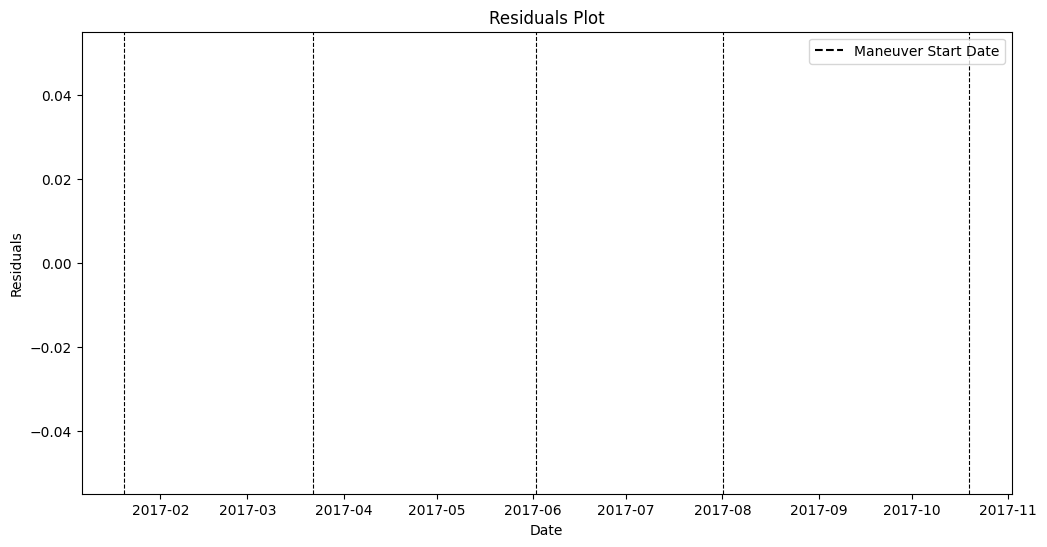

In [ ]:
h2a_bmm_xgb, h2a_bmm_xgb_y_test, h2a_bmm_xgb_y_pred, h2a_bmm_xgb_residuals, h2a_bmm_xgb_anomaly_indices = xgboost_with_grid_search(
    data = h2a_tle,
    target_column='brouwer_mean_motion',
    lag = 3
)

plot_xgboost_residuals(h2a_bmm_xgb_y_test, h2a_bmm_xgb_y_pred, h2aman, '2017-01-01', '2018-01-01')

Precision at Best F1: 0.8421052631578947
Recall at Best F1: 0.64
Best F1 Score: 0.727272727223657


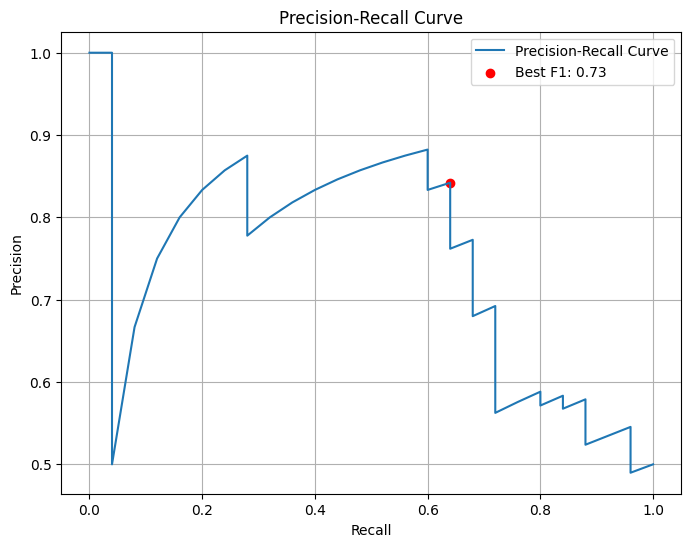

In [ ]:
# Filtered residuals and maneuver timestamps
h2a_xgb_bmm_predictions_series = pd.Series(
    h2a_bmm_xgb_y_pred,
    index=h2a_bmm_xgb_y_test.index  # Using the same index as the ground truth for alignment
)

# Define parameters for evaluate_model_performance
float_matching_max_days = 5  # set the max days to match predictions to ground truth
float_threshold = 0.001        # set a threshold for considering anomalies

# Calculate precision and recall
precision, recall = evaluate_model_performance(
    float_matching_max_days,
    float_threshold,
    h2aman,
    h2a_xgb_bmm_predictions_series
)

plot_precision_recall_curve_from_model(
    float_matching_max_days=5,
    pd_series_ground_truth_manoeuvre_timestamps=cs2man_filtered,
    pd_series_predictions=xgb_bmm_predictions_series
)

## CatBoost

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'depth': 4, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.1}


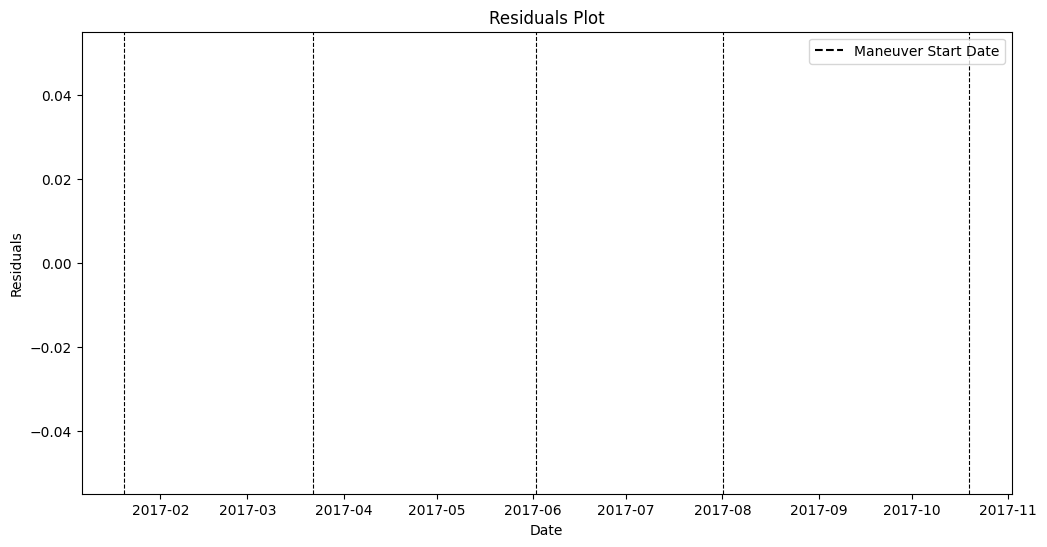

In [ ]:
h2a_bmm_cab, h2a_bmm_cab_y_test, h2a_bmm_cab_y_pred, h2a_bmm_cab_residuals, h2a_bmm_cab_anomaly_indices = catboost_with_grid_search(
    data = h2a_tle,
    target_column='brouwer_mean_motion',
    lag = 3
)

plot_xgboost_residuals(h2a_bmm_cab_y_test, h2a_bmm_cab_y_pred, h2aman, '2017-01-01', '2018-01-01')

In [ ]:
# Filtered residuals and maneuver timestamps
cab_bmm_predictions_series = pd.Series(
    cs2_bmm_cab_y_pred,
    index=cs2_bmm_cab_y_test.index  # Using the same index as the ground truth for alignment
)

# Define parameters for evaluate_model_performance
float_matching_max_days = 5  # set the max days to match predictions to ground truth
float_threshold = 0.00000000000000000000000001        # set a threshold for considering anomalies

# Calculate precision and recall
precision, recall = evaluate_model_performance(
    float_matching_max_days,
    float_threshold,
    cs2man_filtered,
    cab_bmm_predictions_series
)

plot_precision_recall_curve_from_model(
    float_matching_max_days=5,
    pd_series_ground_truth_manoeuvre_timestamps=cs2man_filtered,
    pd_series_predictions=xgb_bmm_predictions_series
)

## VARIMA

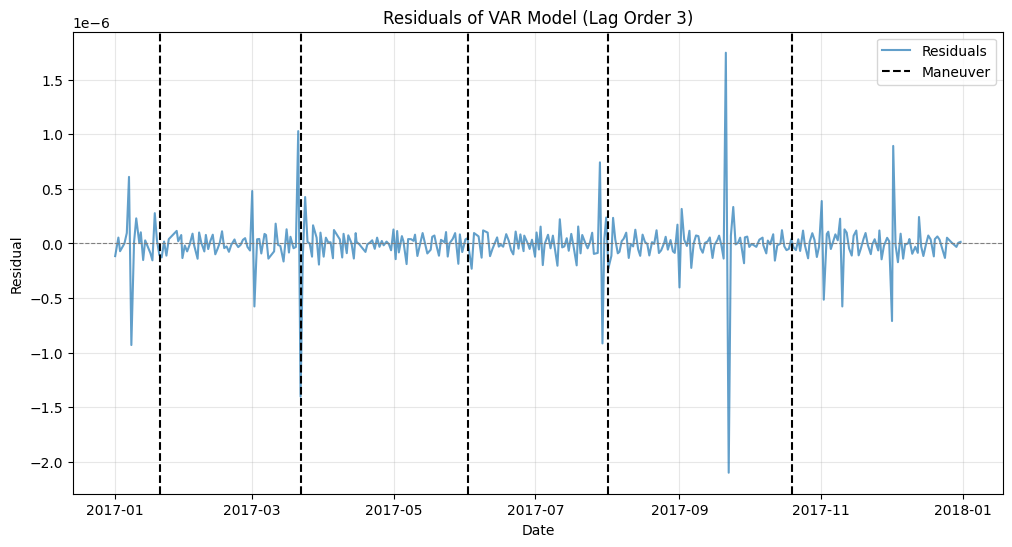

Best VAR lag order: 3 with MSE: 5.060800667593822e-14


In [ ]:
h2a_var_best_model, best_lag_order = best_var_fit(h2a_tle, target_variable='brouwer_mean_motion', maneuver_dates = h2aman['start_date'], max_lag = 3, start_date = '2017-01-01', end_date = '2018-01-01')

Precision at Best F1: 0.7105263157894737
Recall at Best F1: 0.9310344827586207
Best F1 Score: 0.8059701492046335


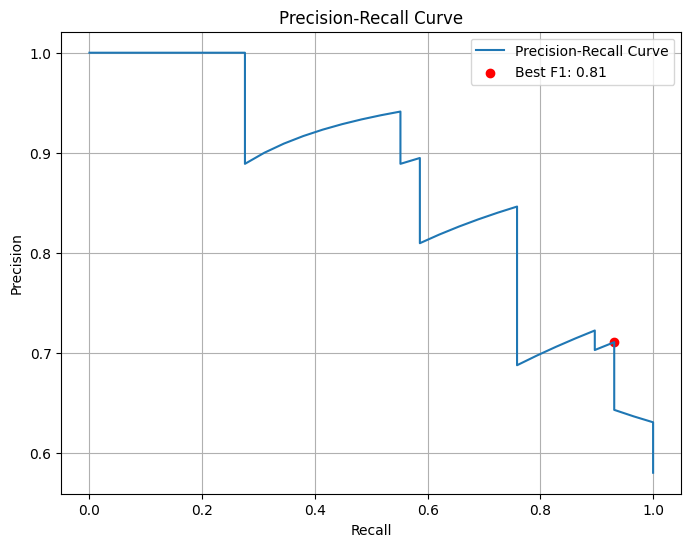

In [ ]:
# Filtered residuals and maneuver timestamps,
arima_bmm_filtered_pred = cs2bmm_best_model.fittedvalues[(cs2bmm_best_model.resid.index >= pd.Timestamp('2022-01-01')) &
                                      (cs2bmm_best_model.resid.index < pd.Timestamp('2022-06-01'))]

# Define parameters for evaluate_model_performance
float_matching_max_days = 5 # set the max days to match predictions to ground truth
float_threshold = 0.001        # set a threshold for considering anomalies

# Calculate precision and recall
cs2_ar_precision, cs2_ar_recall = evaluate_model_performance(
    float_matching_max_days,
    float_threshold,
    cs2man_filtered,
    arima_bmm_filtered_pred
)

plot_precision_recall_curve_from_model(
    float_matching_max_days=5,
    pd_series_ground_truth_manoeuvre_timestamps=cs2man_filtered,
    pd_series_predictions=xgb_bmm_predictions_series
)

# Jason-3

## Importing Datasets

In [ ]:
ja3_tle = read_satellite_data('unpropagated_elements_Jason-3.csv')
ja3_tle.head()

eccentricity  argument of perigee  inclination  \
2016-01-31 19:27:29.355551      0.000817             4.697711     1.152607   
2016-02-04 19:09:58.974336      0.000544             4.925965     1.152636   
2016-02-05 17:43:49.867103      0.000803             4.672899     1.152678   
2016-02-06 01:14:32.477856      0.000804             4.673404     1.152675   
2016-02-07 01:39:21.000384      0.000807             4.692616     1.152684   

                            mean anomaly  Brouwer mean motion  right ascension  
2016-01-31 19:27:29.355551     -5.138166             0.056076         1.493000  
2016-02-04 19:09:58.974336     -4.924886             0.055859         1.348476  
2016-02-05 17:43:49.867103     -4.672712             0.055784         1.314673  
2016-02-06 01:14:32.477856     -4.673201             0.055784         1.303398  
2016-02-07 01:39:21.000384     -4.692489             0.055784         1.266706

In [ ]:
ja3man = extract_start_end_dates('ja3man.txt')
ja3man.head()

start_date            end_date
0 2016-01-19 22:18:00 2016-01-20 01:06:00
1 2016-01-21 22:39:00 2016-01-22 01:28:00
2 2016-01-28 22:45:00 2016-01-29 02:05:00
3 2016-01-31 21:38:00 2016-02-01 00:32:00
4 2016-02-02 03:35:00 2016-02-02 06:30:00

## Formatting the Columns

In [ ]:
format_cols(ja3_tle)
ja3_tle.head()

eccentricity  argument_of_perigee  inclination  \
2016-01-31 19:27:29.355551      0.000817             4.697711     1.152607   
2016-02-04 19:09:58.974336      0.000544             4.925965     1.152636   
2016-02-05 17:43:49.867103      0.000803             4.672899     1.152678   
2016-02-06 01:14:32.477856      0.000804             4.673404     1.152675   
2016-02-07 01:39:21.000384      0.000807             4.692616     1.152684   

                            mean_anomaly  brouwer_mean_motion  right_ascension  
2016-01-31 19:27:29.355551     -5.138166             0.056076         1.493000  
2016-02-04 19:09:58.974336     -4.924886             0.055859         1.348476  
2016-02-05 17:43:49.867103     -4.672712             0.055784         1.314673  
2016-02-06 01:14:32.477856     -4.673201             0.055784         1.303398  
2016-02-07 01:39:21.000384     -4.692489             0.055784         1.266706

## Checking for Duplicates

In [ ]:
check_duplicates(ja3_tle)

No duplicates


## Missing Values

In [ ]:
missing_values(ja3_tle)

Percentage of missing value in entire dataset is: 0.0%


## ACF and PACF Plots

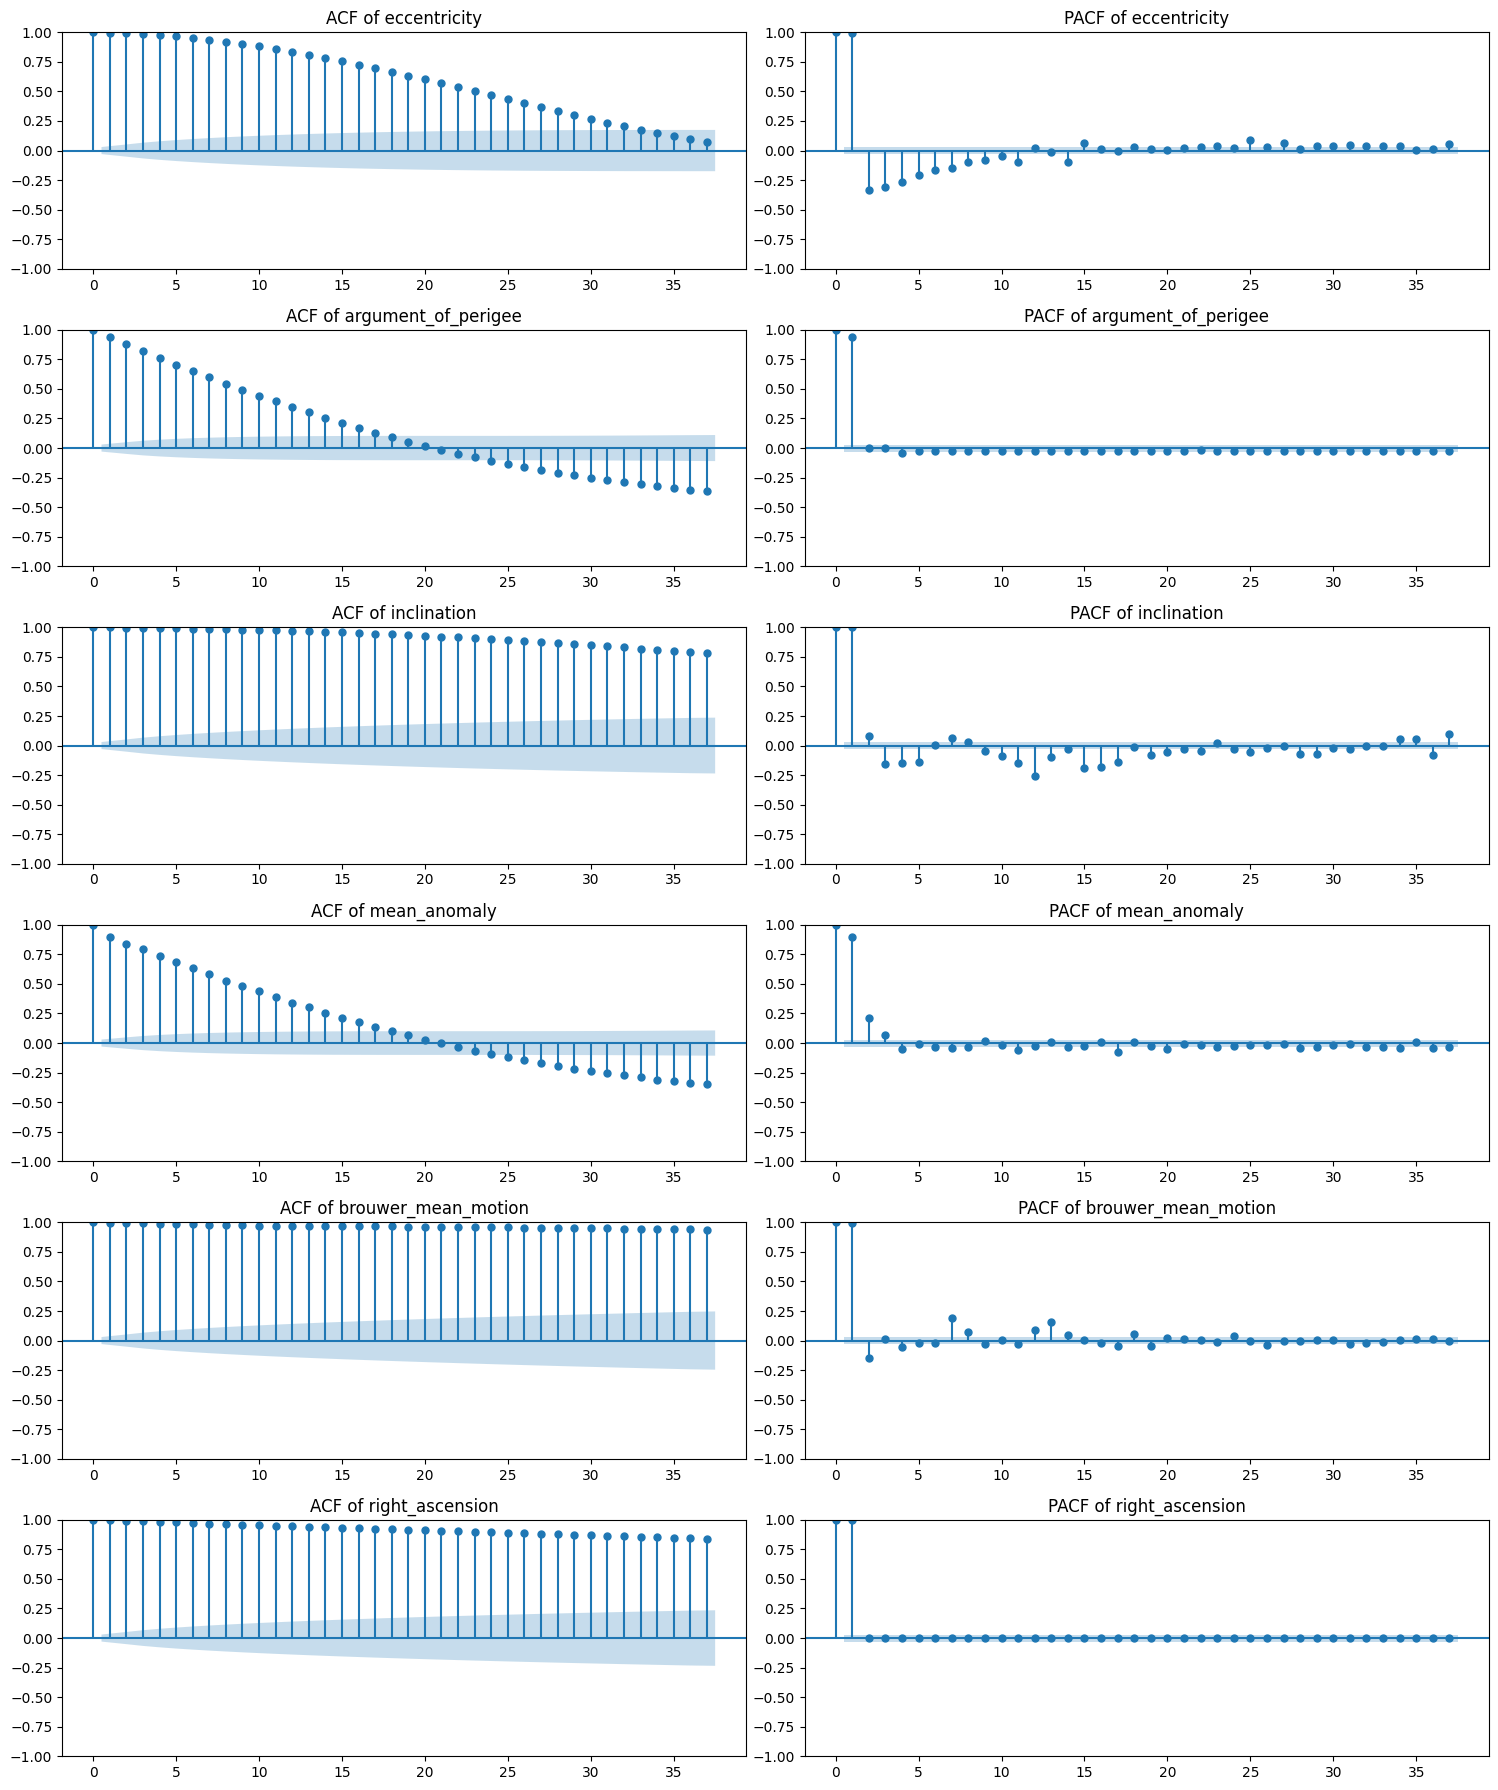

In [ ]:
acf_pacf(ja3_tle)

## Stationary Test: ADF Test

In [ ]:
adf_test(ja3_tle)

Augmented Dickey-Fuller Test: eccentricity
ADF Test Statistic            -8.298070e+00
p-value                        4.088556e-13
#Lags Used                     2.200000e+01
Number of Observations Used    2.387000e+03
Critical Value (1%)           -3.433092e+00
Critical Value (5%)           -2.862752e+00
Critical Value (10%)          -2.567415e+00

Augmented Dickey-Fuller Test: argument_of_perigee
ADF Test Statistic               -3.118712
p-value                           0.025199
#Lags Used                       22.000000
Number of Observations Used    2387.000000
Critical Value (1%)              -3.433092
Critical Value (5%)              -2.862752
Critical Value (10%)             -2.567415

Augmented Dickey-Fuller Test: inclination
ADF Test Statistic               -5.458106
p-value                           0.000003
#Lags Used                       26.000000
Number of Observations Used    2383.000000
Critical Value (1%)              -3.433097
Critical Value (5%)              -2.862

## Exploratory Data Analysis

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2410 entries, 2016-01-31 19:27:29.355551 to 2022-10-03 10:55:29.352575
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   eccentricity         2410 non-null   float64
 1   argument_of_perigee  2410 non-null   float64
 2   inclination          2410 non-null   float64
 3   mean_anomaly         2410 non-null   float64
 4   brouwer_mean_motion  2410 non-null   float64
 5   right_ascension      2410 non-null   float64
dtypes: float64(6)
memory usage: 131.8 KB
None
       eccentricity  argument_of_perigee  inclination  mean_anomaly  \
count   2410.000000          2410.000000  2410.000000   2410.000000   
mean       0.000789             4.713344     1.152634     -4.713325   
std        0.000039             0.048556     0.000029      0.049303   
min        0.000495             4.522810     1.152570     -5.138166   
25%        0.000767             4.676146  

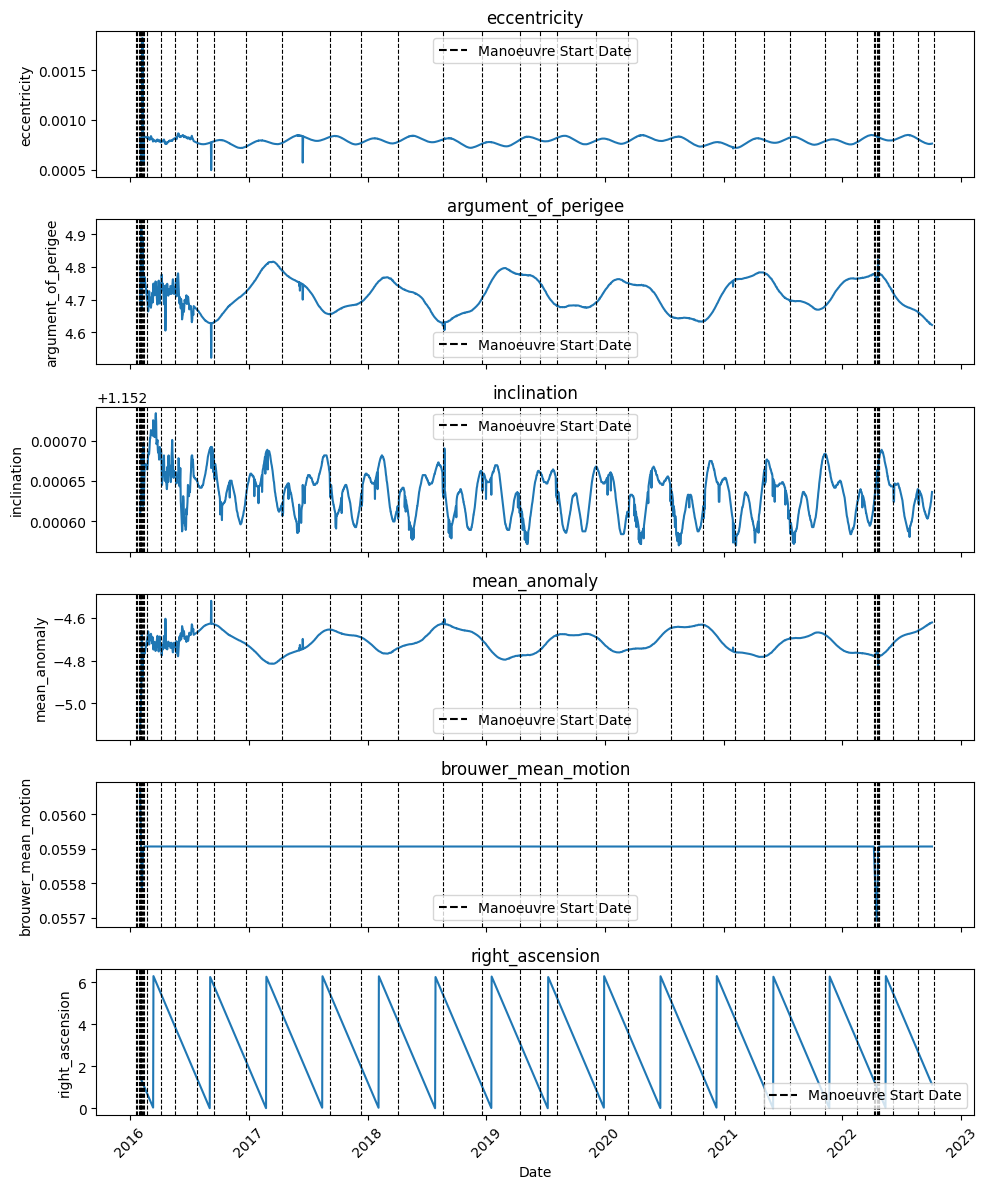

In [ ]:
eda(ja3_tle, ja3man)

## Exploratory Data Analysis Filtered

In [ ]:
ja3man_filtered = ja3man[(ja3man['start_date'] >= pd.Timestamp('2022-01-01')) &
                                   (ja3man['start_date'] < pd.Timestamp('2022-06-01'))]['start_date']

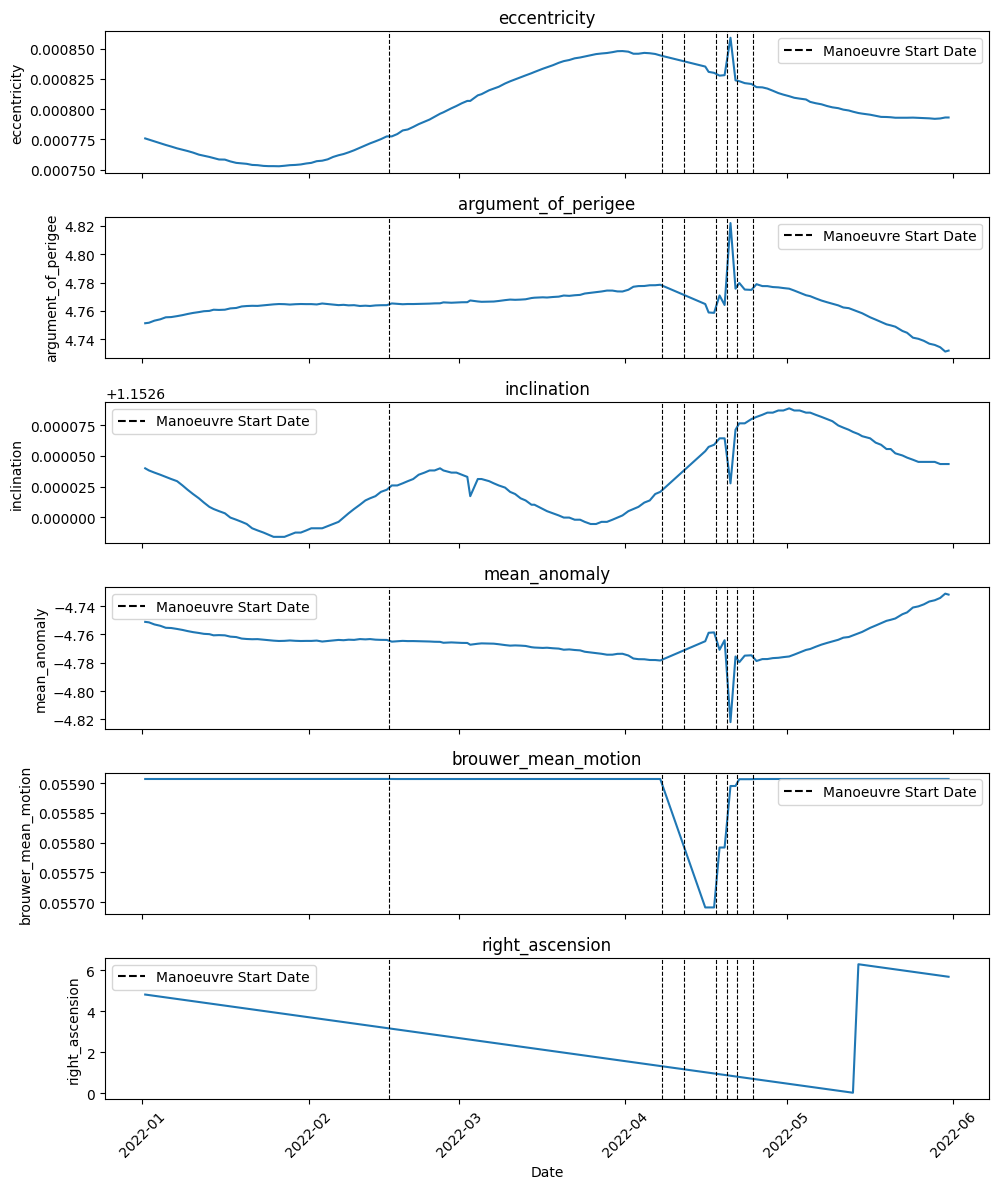

In [ ]:
eda_filtered(ja3_tle, ja3man, '2022-01-01', '2022-06-01')

## ARIMA Model and Plotting Residuals

### Eccentricity

Best ARIMA order: (3, 0, 2) with MSE: 6.033124274375597e-07


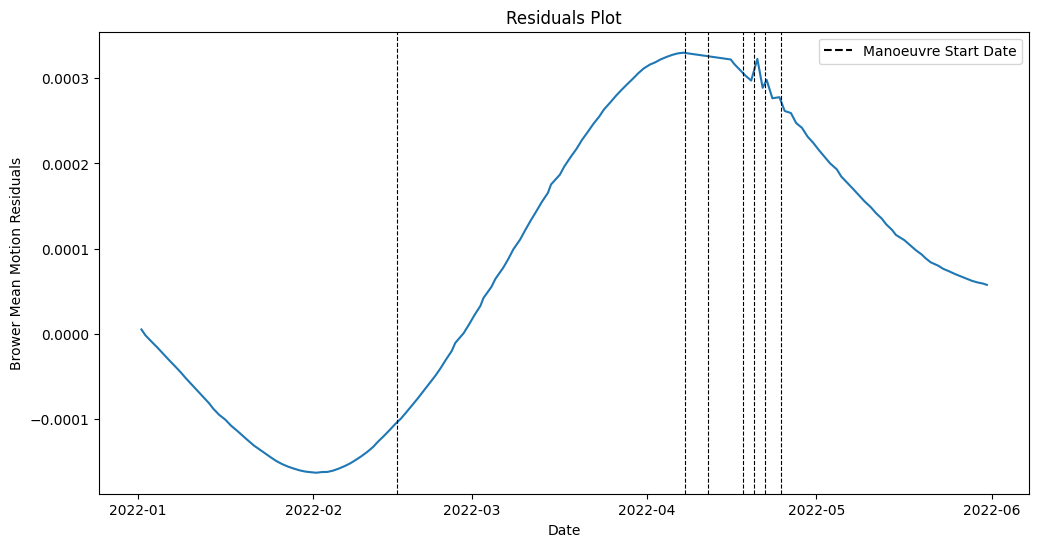

In [ ]:
ja3ecc_best_model = best_arima_fit(ja3_tle['eccentricity'])

plot_residuals(ja3ecc_best_model,ja3man, '2022-01-01', '2022-06-01')

### Argument of Perigee

Best ARIMA order: (3, 0, 1) with MSE: 22.216298245010563


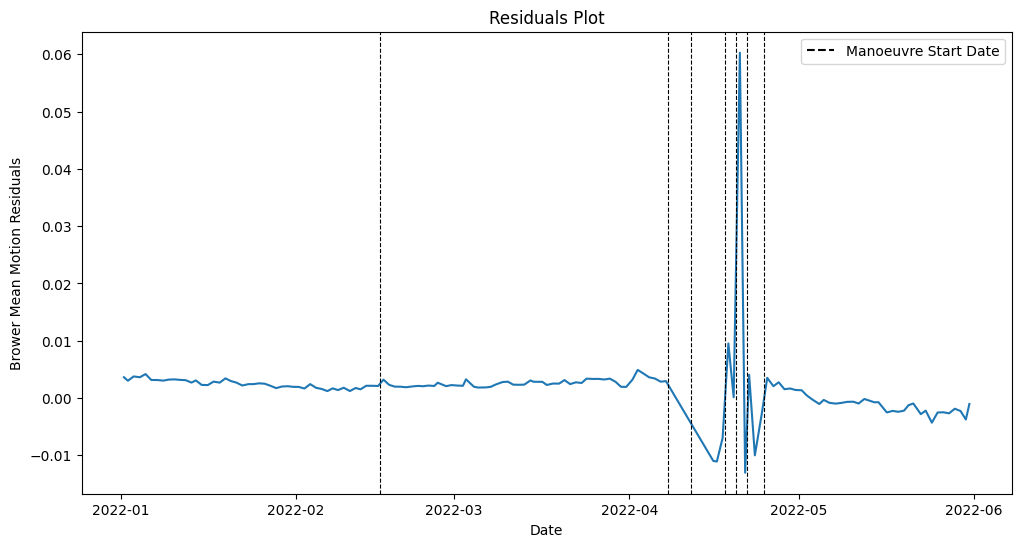

In [ ]:
ja3aop_best_model = best_arima_fit(ja3_tle['argument_of_perigee'])

plot_residuals(ja3aop_best_model,ja3man, '2022-01-01', '2022-06-01')

### Inclination


Best ARIMA order: (1, 1, 2) with MSE: 1.3285642464481529


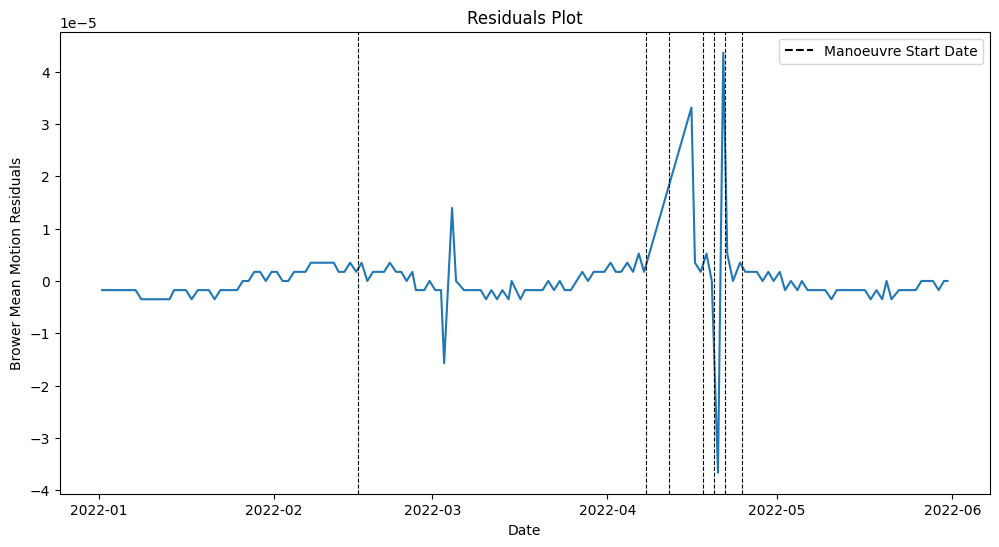

In [ ]:
ja3inc_best_model = best_arima_fit(ja3_tle['inclination'])

plot_residuals(ja3inc_best_model,ja3man, '2022-01-01', '2022-06-01')

### Mean Anomaly

Best ARIMA order: (2, 2, 2) with MSE: 22.209374968902257


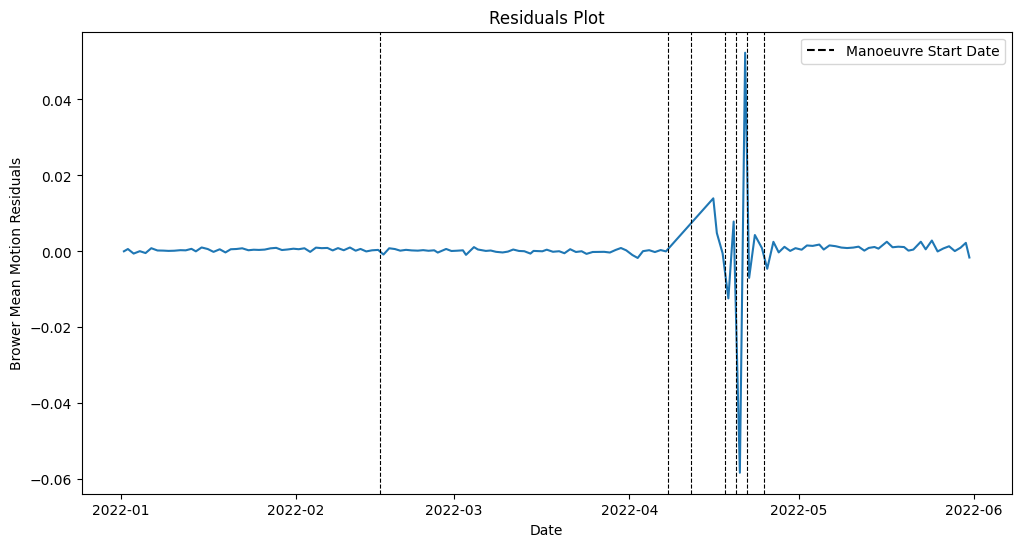

In [ ]:
ja3ma_best_model = best_arima_fit(ja3_tle['mean_anomaly'])

plot_residuals(ja3ma_best_model,ja3man, '2022-01-01', '2022-06-01')

### Brouwer Mean Motion

Best ARIMA order: (2, 0, 1) with MSE: 0.00312528064073036


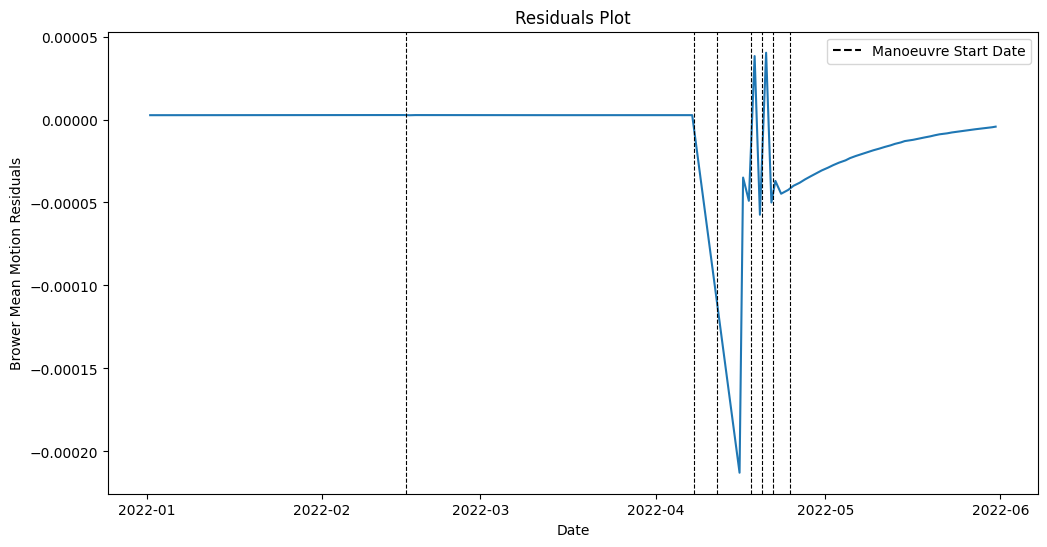

In [ ]:
ja3bmm_best_model = best_arima_fit(ja3_tle['brouwer_mean_motion'])

plot_residuals(ja3bmm_best_model,ja3man, '2022-01-01', '2022-06-01')

### Right Ascension

Best ARIMA order: (3, 0, 1) with MSE: 12.898834524587114


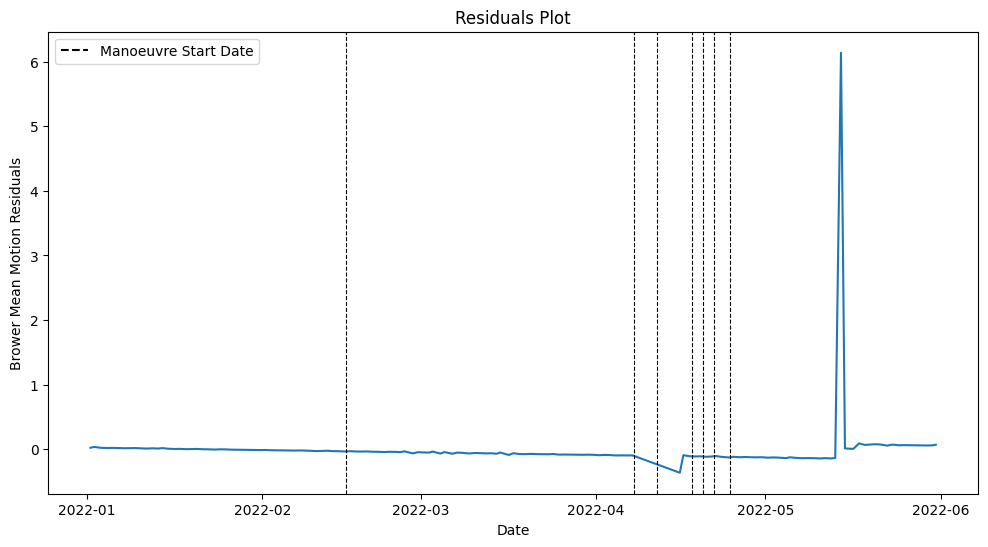

In [ ]:
ja3ra_best_model = best_arima_fit(ja3_tle['right_ascension'])

plot_residuals(ja3ra_best_model,ja3man, '2022-01-01', '2022-06-01')

### ARIMA PR Curve

Precision at Best F1: 0.9473684210526315
Recall at Best F1: 0.782608695652174
Best F1 Score: 0.8571428570933106


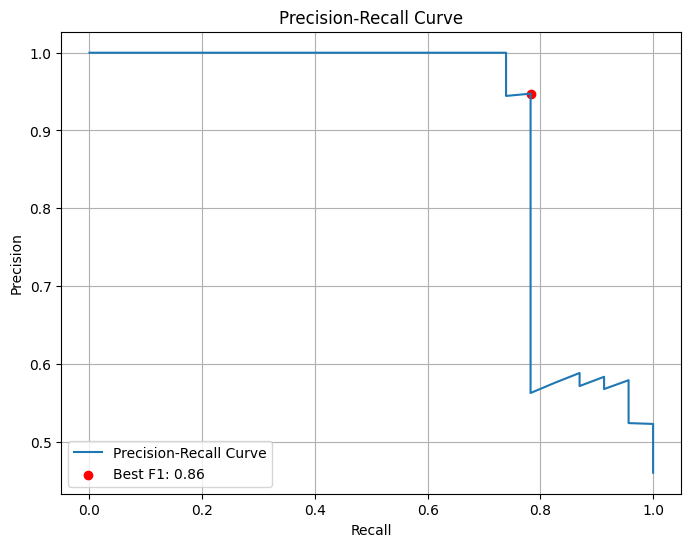

In [ ]:
# Filtered residuals and maneuver timestamps,
ja3arima_bmm_filtered_pred = ja3bmm_best_model.fittedvalues[(ja3bmm_best_model.resid.index >= pd.Timestamp('2022-01-01')) &
                                      (ja3bmm_best_model.resid.index < pd.Timestamp('2022-06-01'))]

# Define parameters for evaluate_model_performance
float_matching_max_days = 5 # set the max days to match predictions to ground truth
float_threshold = 0.001        # set a threshold for considering anomalies

# Calculate precision and recall
ja3_ar_precision, ja3_ar_recall = evaluate_model_performance(
    float_matching_max_days,
    float_threshold,
    ja3man,
    ja3arima_bmm_filtered_pred
)

plot_precision_recall_curve_from_model(
    float_matching_max_days=5,
    pd_series_ground_truth_manoeuvre_timestamps=cs2man_filtered,
    pd_series_predictions=xgb_bmm_predictions_series
)

## XGBoost

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


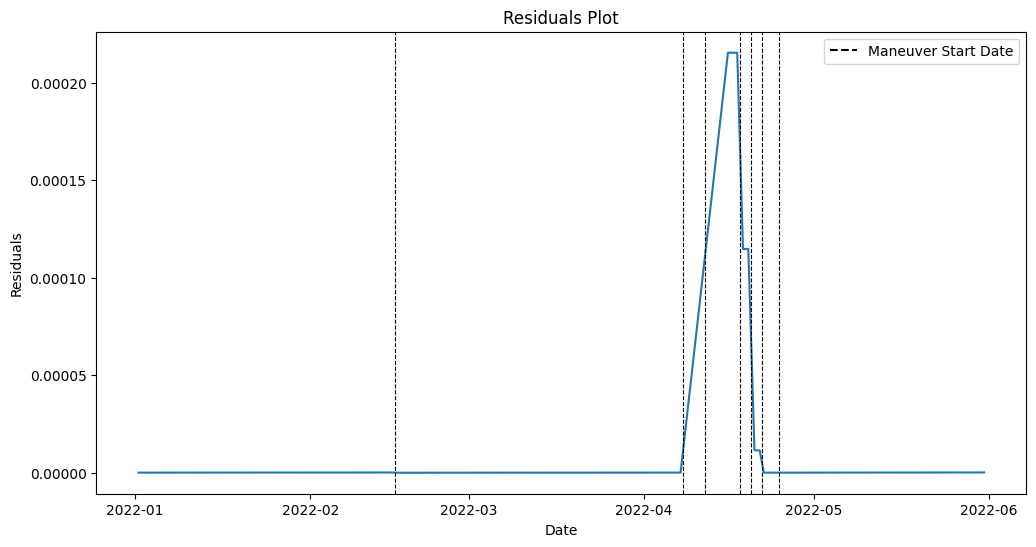

In [ ]:
ja3_bmm_xgb, ja3_bmm_xgb_y_test, ja3_bmm_xgb_y_pred, ja3_bmm_xgb_residuals, ja3_bmm_xgb_anomaly_indices = xgboost_with_grid_search(
    data = ja3_tle,
    target_column='brouwer_mean_motion',
    lag = 3
)

plot_xgboost_residuals(ja3_bmm_xgb_y_test, ja3_bmm_xgb_y_pred, ja3man, '2022-01-01', '2022-06-01')

Precision at Best F1: 0.8947368421052632
Recall at Best F1: 0.6538461538461539
Best F1 Score: 0.7555555555067655


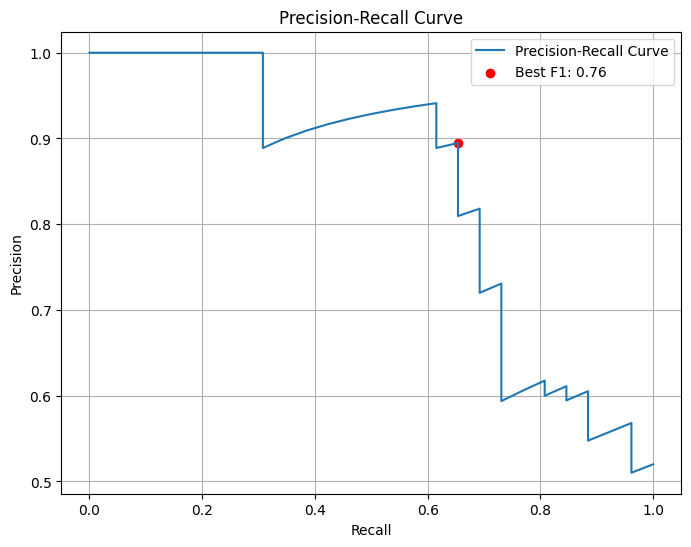

In [ ]:
# Filtered residuals and maneuver timestamps
ja3_xgb_bmm_predictions_series = pd.Series(
    ja3_bmm_xgb_y_pred,
    index=ja3_bmm_xgb_y_test.index  # Using the same index as the ground truth for alignment
)

# Define parameters for evaluate_model_performance
float_matching_max_days = 5  # set the max days to match predictions to ground truth
float_threshold = 0.001        # set a threshold for considering anomalies

# Calculate precision and recall
precision, recall = evaluate_model_performance(
    float_matching_max_days,
    float_threshold,
    cs2man_filtered,
    ja3_xgb_bmm_predictions_series
)

plot_precision_recall_curve_from_model(
    float_matching_max_days=5,
    pd_series_ground_truth_manoeuvre_timestamps=cs2man_filtered,
    pd_series_predictions=xgb_bmm_predictions_series
)

## CatBoost

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'depth': 4, 'iterations': 300, 'l2_leaf_reg': 5, 'learning_rate': 0.1}


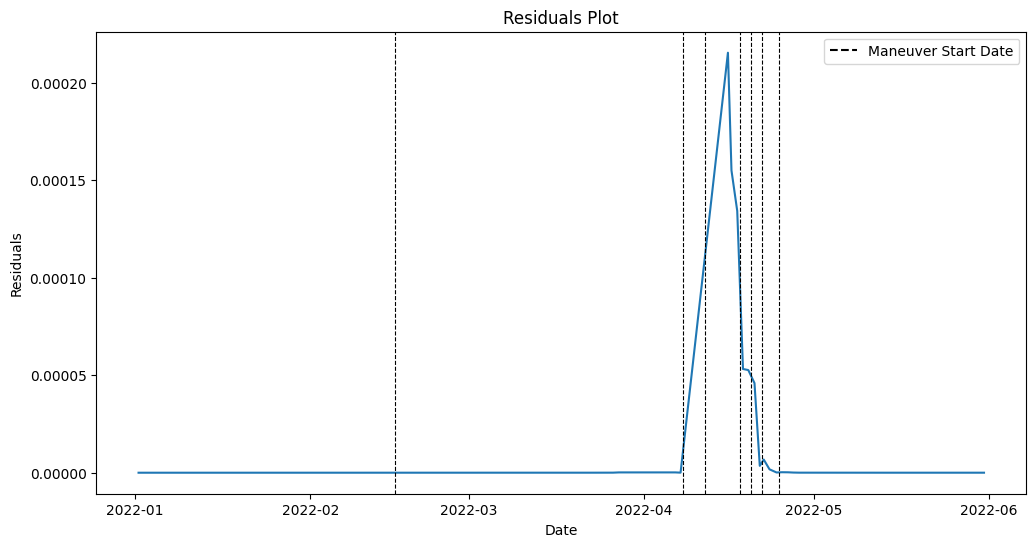

In [ ]:
ja3_bmm_cab, ja3_bmm_cab_y_test, ja3_bmm_cab_y_pred, ja3_bmm_cab_residuals, ja3_bmm_cab_anomaly_indices = catboost_with_grid_search(
    data = ja3_tle,
    target_column='brouwer_mean_motion',
    lag = 3
)

plot_xgboost_residuals(ja3_bmm_cab_y_test, ja3_bmm_cab_y_pred, ja3man, '2022-01-01', '2022-06-01')

In [ ]:
# Filtered residuals and maneuver timestamps
ja3_cab_bmm_predictions_series = pd.Series(
    ja3_tle_bmm_cab_y_pred,
    index=ja3_bmm_cab_y_test.index  # Using the same index as the ground truth for alignment
)

# Define parameters for evaluate_model_performance
float_matching_max_days = 5  # set the max days to match predictions to ground truth
float_threshold = 0.01        # set a threshold for considering anomalies

# Calculate precision and recall
precision, recall = evaluate_model_performance(
    float_matching_max_days,
    float_threshold,
    ja3man,
    ja3_cab_bmm_predictions_series
)

plot_precision_recall_curve_from_model(
    float_matching_max_days=5,
    pd_series_ground_truth_manoeuvre_timestamps=cs2man_filtered,
    pd_series_predictions=xgb_bmm_predictions_series
)

## VARIMA

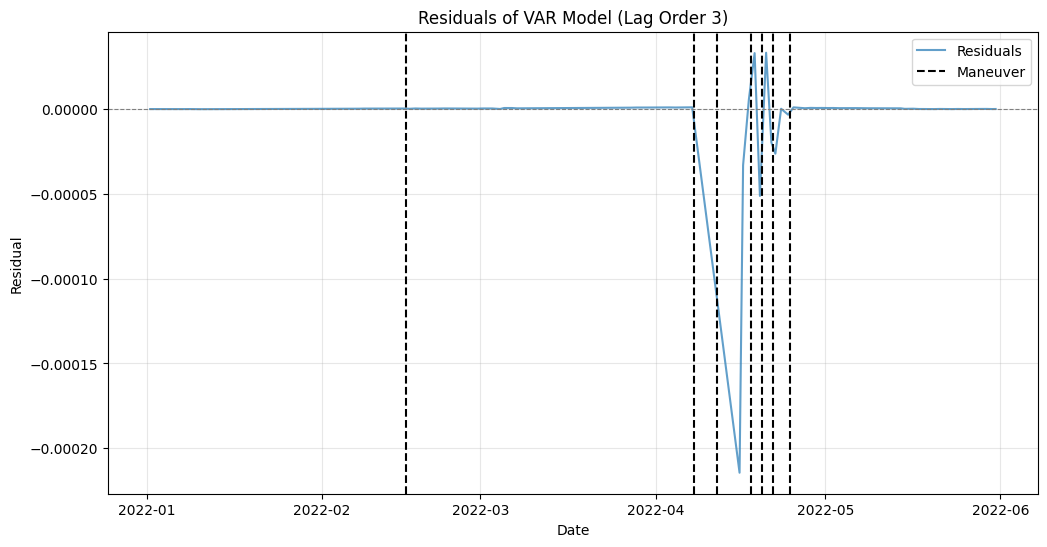

Best VAR lag order: 3 with MSE: 2.2408432794963394e-11


In [ ]:
ja3_best_model, best_lag_order = best_var_fit(ja3_tle, target_variable='brouwer_mean_motion', maneuver_dates = ja3man['start_date'], max_lag = 3, start_date = '2022-01-01', end_date = '2022-06-01')

Precision at Best F1: 0.8076923076923077
Recall at Best F1: 0.7777777777777778
Best F1 Score: 0.7924528301386969


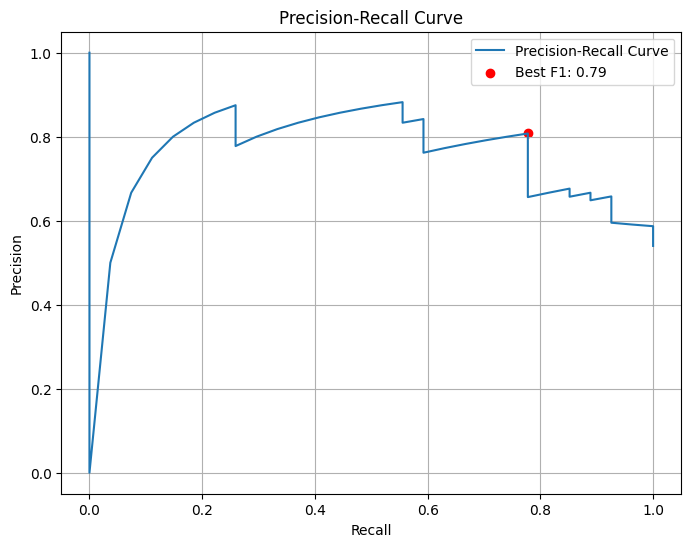

In [ ]:
# Filtered residuals and maneuver timestamps,
ja3_varima_bmm_filtered_pred = ja3bmm_best_model.fittedvalues[(ja3bmm_best_model.resid.index >= pd.Timestamp('2022-01-01')) &
                                      (ja3bmm_best_model.resid.index < pd.Timestamp('2022-06-01'))]

# Define parameters for evaluate_model_performance
float_matching_max_days = 5 # set the max days to match predictions to ground truth
float_threshold = 0.001        # set a threshold for considering anomalies

# Calculate precision and recall
ja3_ar_precision, ja3_ar_recall = evaluate_model_performance(
    float_matching_max_days,
    float_threshold,
    ja3man,
    ja3_varima_bmm_filtered_pred
)

plot_precision_recall_curve_from_model(
    float_matching_max_days=5,
    pd_series_ground_truth_manoeuvre_timestamps=cs2man_filtered,
    pd_series_predictions=xgb_bmm_predictions_series
)

# Sentinel-6A

## Importing Datasets

In [ ]:
s6a_tle = read_satellite_data('unpropagated_elements_Sentinel-6A.csv')
s6a_tle.head()

eccentricity  argument of perigee  inclination  \
2020-12-05 10:47:44.799647      0.000582             4.521071     1.152715   
2020-12-06 03:35:09.704831      0.000583             4.516135     1.152715   
2020-12-07 01:58:23.043359      0.000583             4.535687     1.152717   
2020-12-08 02:13:32.505312      0.000582             4.518034     1.152711   
2020-12-09 08:04:30.230399      0.000582             4.518357     1.152717   

                            mean anomaly  Brouwer mean motion  right ascension  
2020-12-05 10:47:44.799647     -4.520406             0.056154         0.179238  
2020-12-06 03:35:09.704831     -4.515516             0.056154         0.153622  
2020-12-07 01:58:23.043359     -4.535093             0.056154         0.119456  
2020-12-08 02:13:32.505312     -4.517410             0.056154         0.082404  
2020-12-09 08:04:30.230399     -4.517710             0.056154         0.036849

In [ ]:
s6aman = extract_start_end_dates('s6aman.txt')
s6aman.head()

start_date            end_date
0 2020-11-23 02:38:00 2020-11-23 02:38:00
1 2020-11-23 09:50:00 2020-11-23 09:58:00
2 2020-11-24 01:38:00 2020-11-24 01:42:00
3 2020-11-27 05:22:00 2020-11-27 05:25:00
4 2020-12-10 05:01:00 2020-12-10 05:08:00

## Formatting the Columns

In [ ]:
format_cols(s6a_tle)
s6a_tle.head()

eccentricity  argument_of_perigee  inclination  \
2020-12-05 10:47:44.799647      0.000582             4.521071     1.152715   
2020-12-06 03:35:09.704831      0.000583             4.516135     1.152715   
2020-12-07 01:58:23.043359      0.000583             4.535687     1.152717   
2020-12-08 02:13:32.505312      0.000582             4.518034     1.152711   
2020-12-09 08:04:30.230399      0.000582             4.518357     1.152717   

                            mean_anomaly  brouwer_mean_motion  right_ascension  
2020-12-05 10:47:44.799647     -4.520406             0.056154         0.179238  
2020-12-06 03:35:09.704831     -4.515516             0.056154         0.153622  
2020-12-07 01:58:23.043359     -4.535093             0.056154         0.119456  
2020-12-08 02:13:32.505312     -4.517410             0.056154         0.082404  
2020-12-09 08:04:30.230399     -4.517710             0.056154         0.036849

## Checking for Duplicates

In [ ]:
check_duplicates(s6a_tle)

No duplicates


## Missing Values

In [ ]:
missing_values(s6a_tle)

Percentage of missing value in entire dataset is: 0.0%


## ACF and PACF Plots

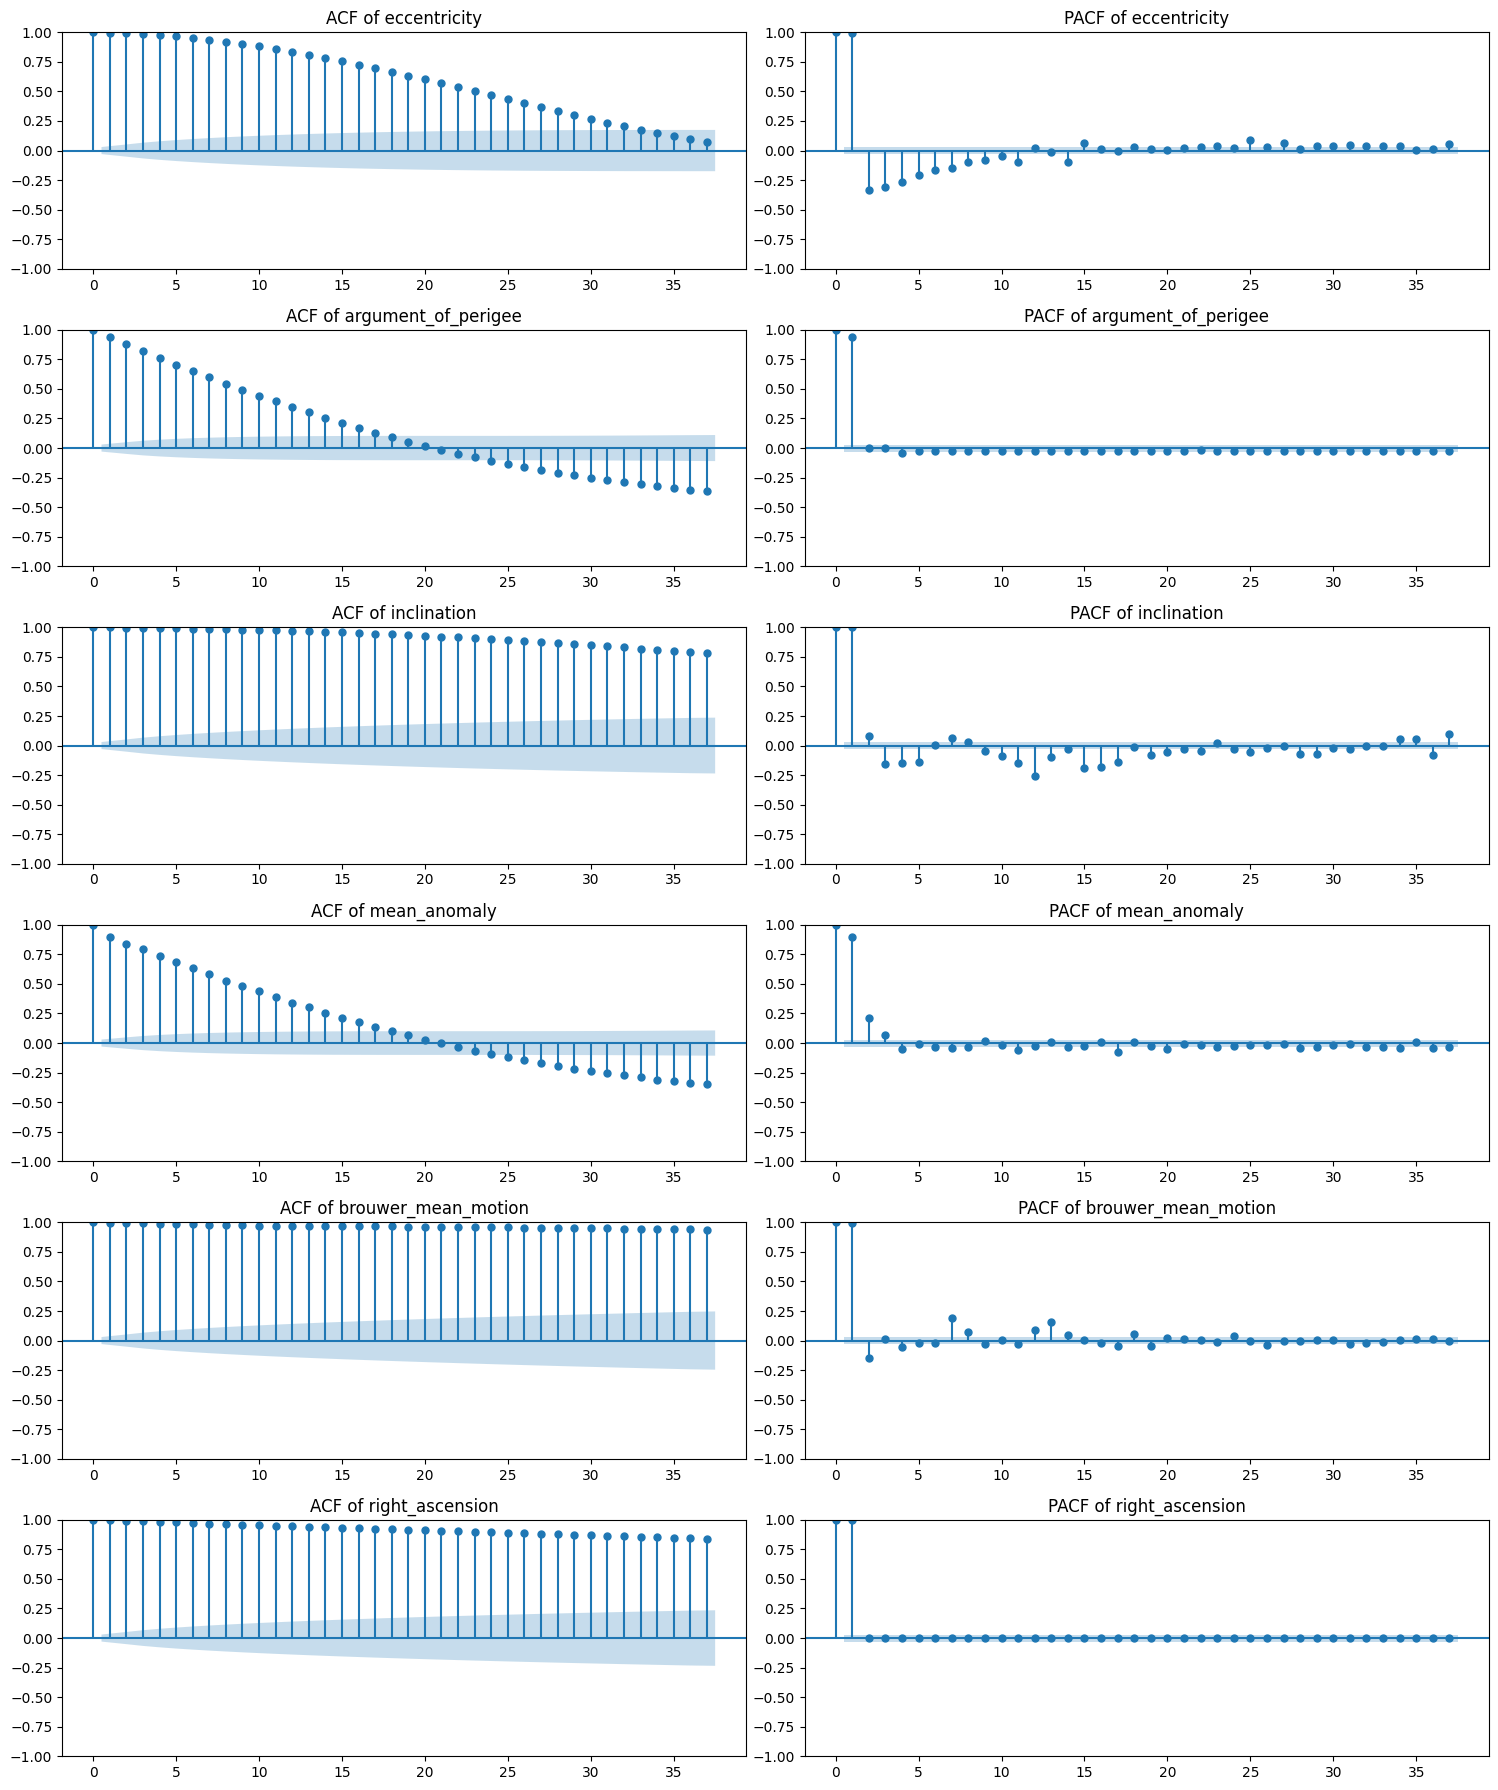

In [ ]:
acf_pacf(s6a_tle)

## Stationary Test: ADF Test

In [ ]:
adf_test(s6a_tle)

Augmented Dickey-Fuller Test: eccentricity
ADF Test Statistic            -1.119700e+01
p-value                        2.293303e-20
#Lags Used                     3.000000e+00
Number of Observations Used    6.590000e+02
Critical Value (1%)           -3.440312e+00
Critical Value (5%)           -2.865936e+00
Critical Value (10%)          -2.569111e+00

Augmented Dickey-Fuller Test: argument_of_perigee
ADF Test Statistic            -9.954102e+00
p-value                        2.470290e-17
#Lags Used                     5.000000e+00
Number of Observations Used    6.570000e+02
Critical Value (1%)           -3.440342e+00
Critical Value (5%)           -2.865949e+00
Critical Value (10%)          -2.569118e+00

Augmented Dickey-Fuller Test: inclination
ADF Test Statistic              -4.409115
p-value                          0.000286
#Lags Used                      11.000000
Number of Observations Used    651.000000
Critical Value (1%)             -3.440435
Critical Value (5%)             -2.86

## Exploratory Data Analysis

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 663 entries, 2020-12-05 10:47:44.799647 to 2022-10-06 09:16:58.628351
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   eccentricity         663 non-null    float64
 1   argument_of_perigee  663 non-null    float64
 2   inclination          663 non-null    float64
 3   mean_anomaly         663 non-null    float64
 4   brouwer_mean_motion  663 non-null    float64
 5   right_ascension      663 non-null    float64
dtypes: float64(6)
memory usage: 36.3 KB
None
       eccentricity  argument_of_perigee  inclination  mean_anomaly  \
count    663.000000           663.000000   663.000000    663.000000   
mean       0.000784             4.621659     1.152664     -4.621582   
std        0.000024             0.117674     0.000033      0.117840   
min        0.000575             1.673640     1.152567     -4.879614   
25%        0.000776             4.611174    

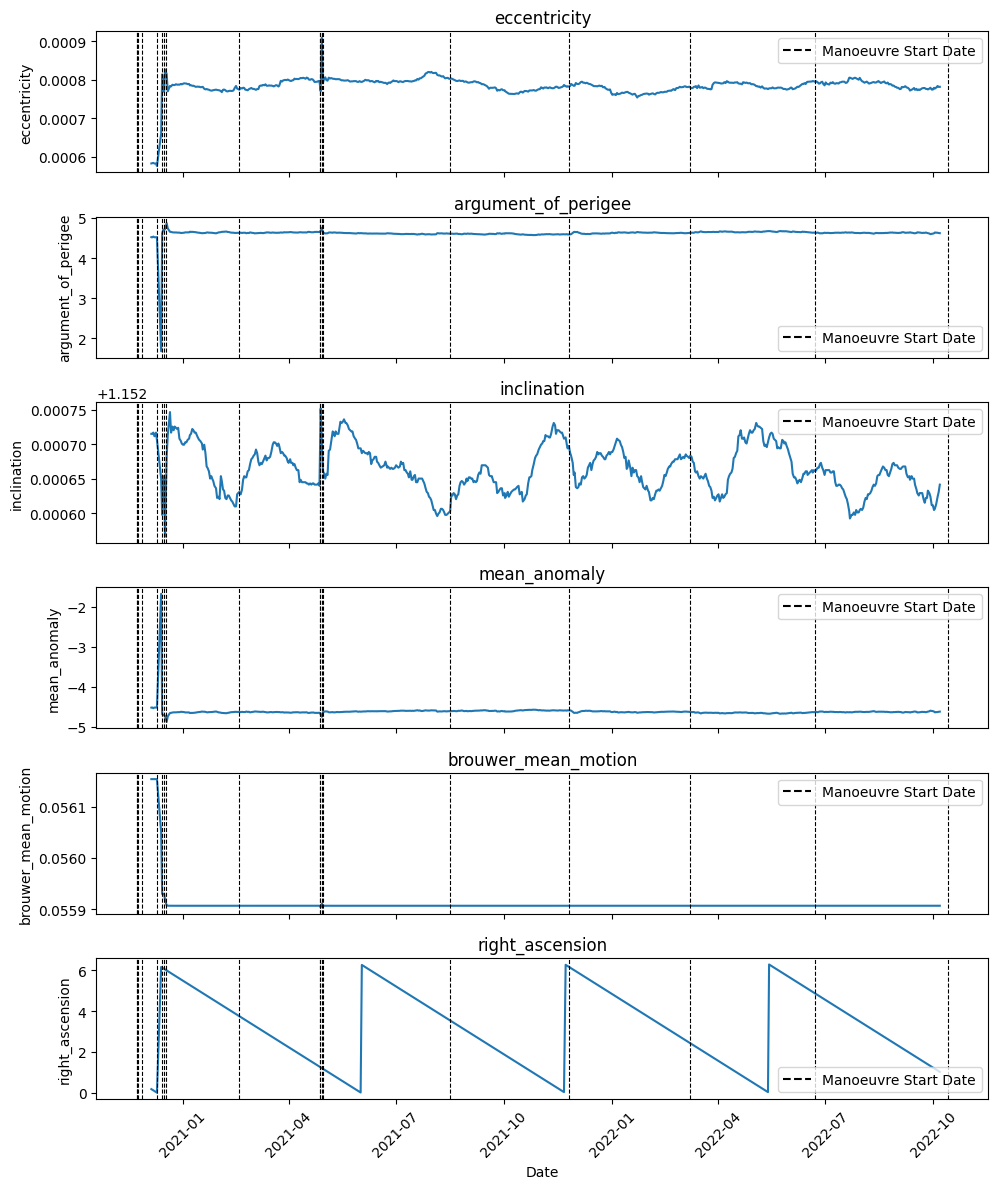

In [ ]:
eda(s6a_tle, s6aman)

## Exploratory Data Analysis Filtered

In [ ]:
s6aman_filtered = s6aman[(s6aman['start_date'] >= pd.Timestamp('2021-04-01')) &
                                   (s6aman['start_date'] < pd.Timestamp('2021-07-01'))]['start_date']

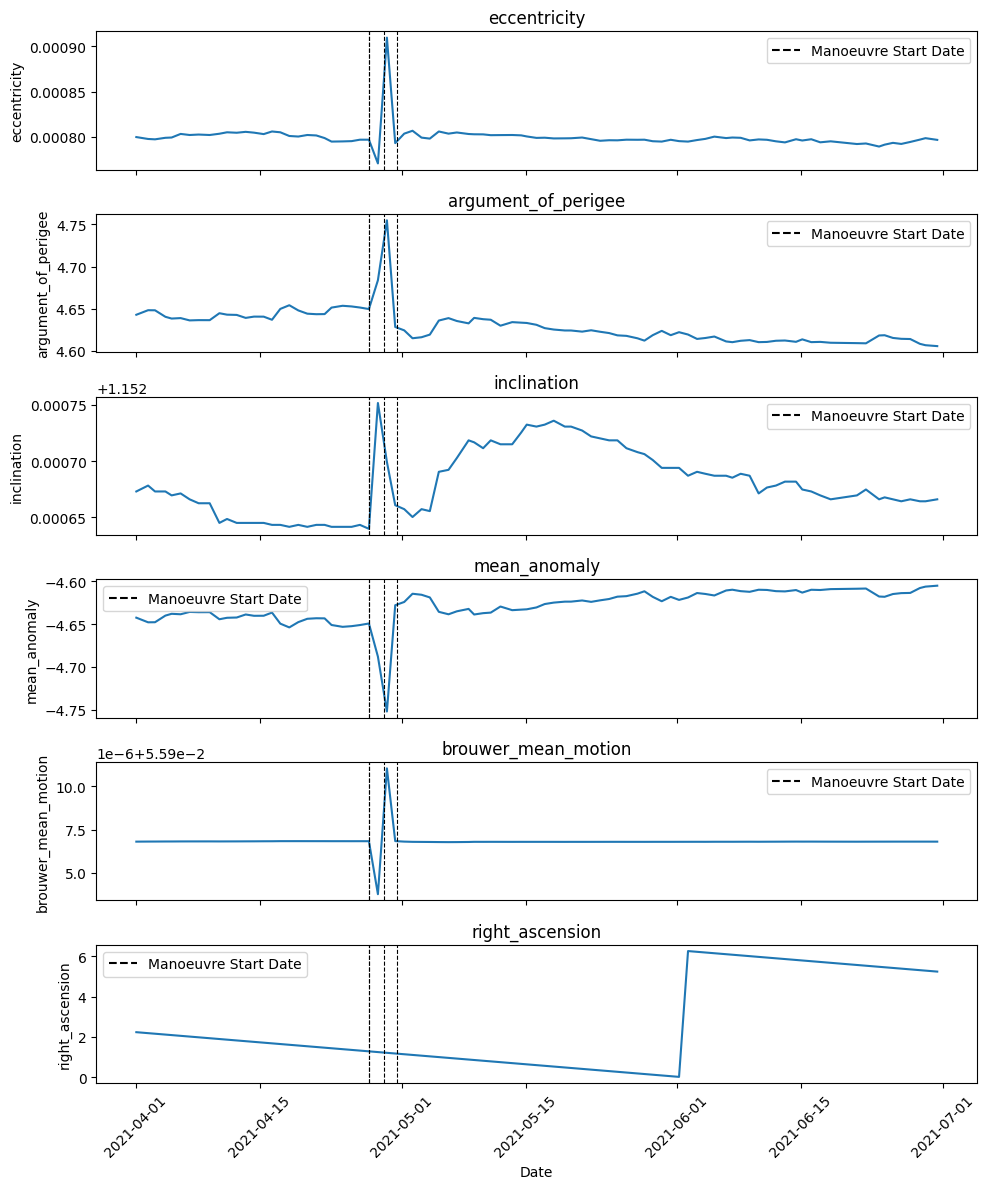

In [ ]:
eda_filtered(s6a_tle, s6aman, '2021-04-01', '2021-07-01')

## ARIMA Model and Plotting Residuals

### Eccentricity

Best ARIMA order: (2, 1, 0) with MSE: 6.147013768593229e-07


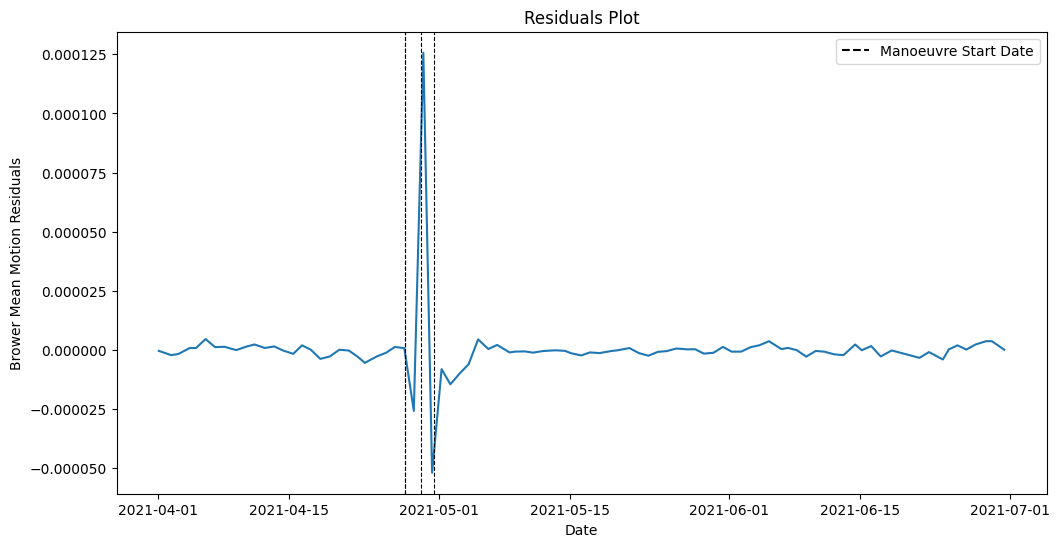

In [ ]:
s6aecc_best_model = best_arima_fit(s6a_tle['eccentricity'])

plot_residuals(s6aecc_best_model,s6aman, '2021-04-01', '2021-07-01')

### Argument of Perigee

Best ARIMA order: (2, 1, 0) with MSE: 6.147013768593229e-07


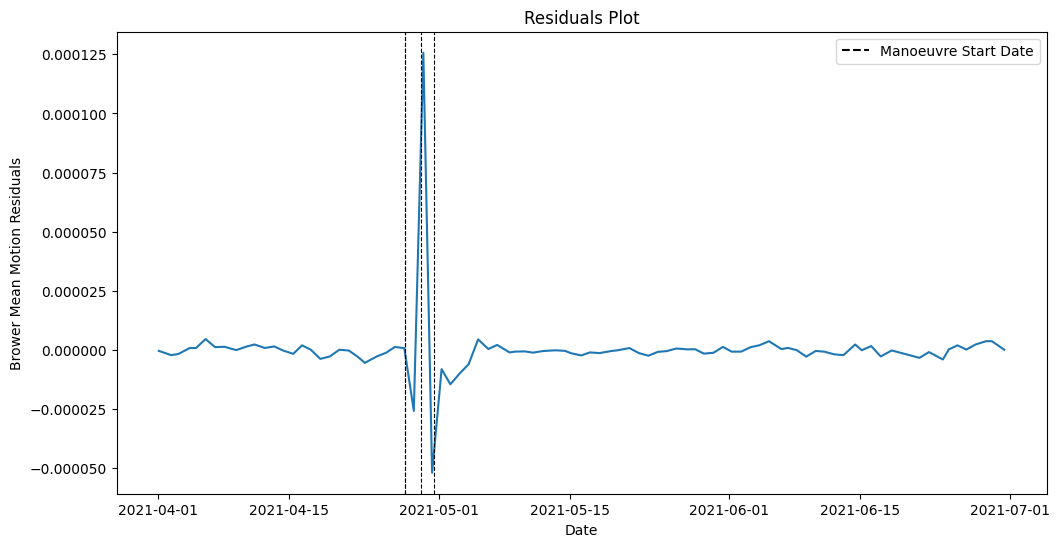

In [ ]:
s6aecc_best_model = best_arima_fit(s6a_tle['eccentricity'])

plot_residuals(s6aecc_best_model,s6aman, '2021-04-01', '2021-07-01')

### Inclination

Best ARIMA order: (2, 0, 1) with MSE: 1.3286204775794501


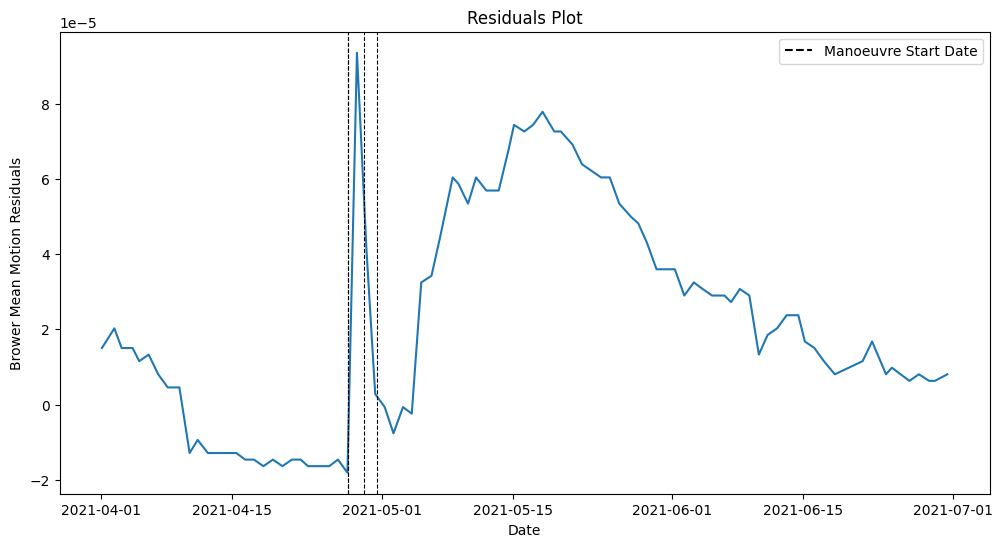

In [ ]:
s6ainc_best_model = best_arima_fit(s6a_tle['inclination'])

plot_residuals(s6ainc_best_model,s6aman, '2021-04-01', '2021-07-01')

### Mean Anomaly


Best ARIMA order: (3, 1, 1) with MSE: 21.295721189865247


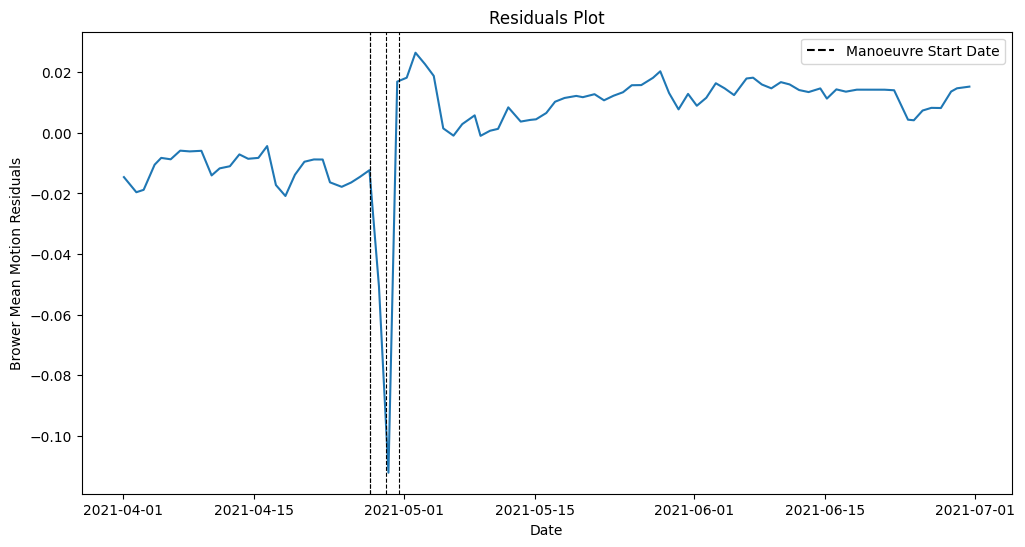

In [ ]:
s6ama_best_model = best_arima_fit(s6a_tle['mean_anomaly'])

plot_residuals(s6ama_best_model,s6aman, '2021-04-01', '2021-07-01')

### Brouwer Mean Motion


Best ARIMA order: (2, 2, 0) with MSE: 0.003125776367201901


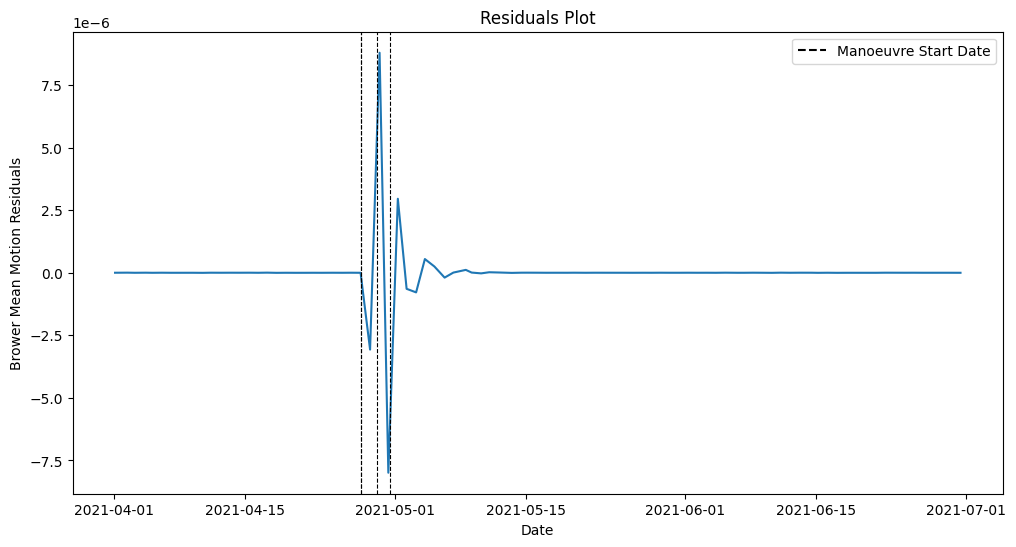

In [ ]:
s6abmm_best_model = best_arima_fit(s6a_tle['brouwer_mean_motion'])

plot_residuals(s6abmm_best_model,s6aman, '2021-04-01', '2021-07-01')

### Right Ascension

Best ARIMA order: (1, 0, 0) with MSE: 13.13671094081424


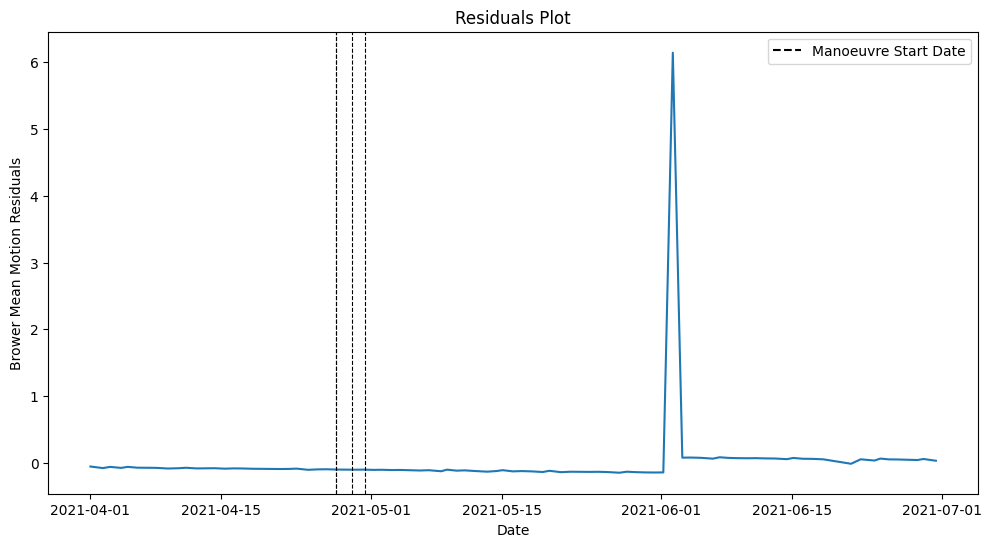

In [ ]:
s6ara_best_model = best_arima_fit(s6a_tle['right_ascension'])

plot_residuals(s6ara_best_model,s6aman, '2021-04-01', '2021-07-01')

### ARIMA PR Curve

Precision at Best F1: 0.9473684210526315
Recall at Best F1: 0.75
Best F1 Score: 0.8372093022762574


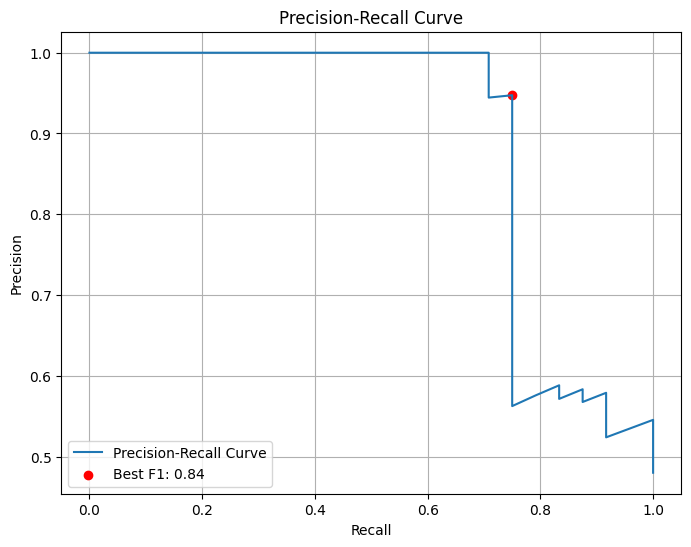

In [ ]:
# Filtered residuals and maneuver timestamps,
s6a_arima_bmm_filtered_pred = s6abmm_best_model.fittedvalues[(s6abmm_best_model.resid.index >= pd.Timestamp('2022-01-01')) &
                                      (s6abmm_best_model.resid.index < pd.Timestamp('2022-06-01'))]

# Define parameters for evaluate_model_performance
float_matching_max_days = 5 # set the max days to match predictions to ground truth
float_threshold = 0.001        # set a threshold for considering anomalies

# Calculate precision and recall
s6a_ar_precision, s6a_ar_recall = evaluate_model_performance(
    float_matching_max_days,
    float_threshold,
    s6aman,
    arima_bmm_filtered_pred
)

plot_precision_recall_curve_from_model(
    float_matching_max_days=5,
    pd_series_ground_truth_manoeuvre_timestamps=cs2man_filtered,
    pd_series_predictions=xgb_bmm_predictions_series
)

## XGBoost

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


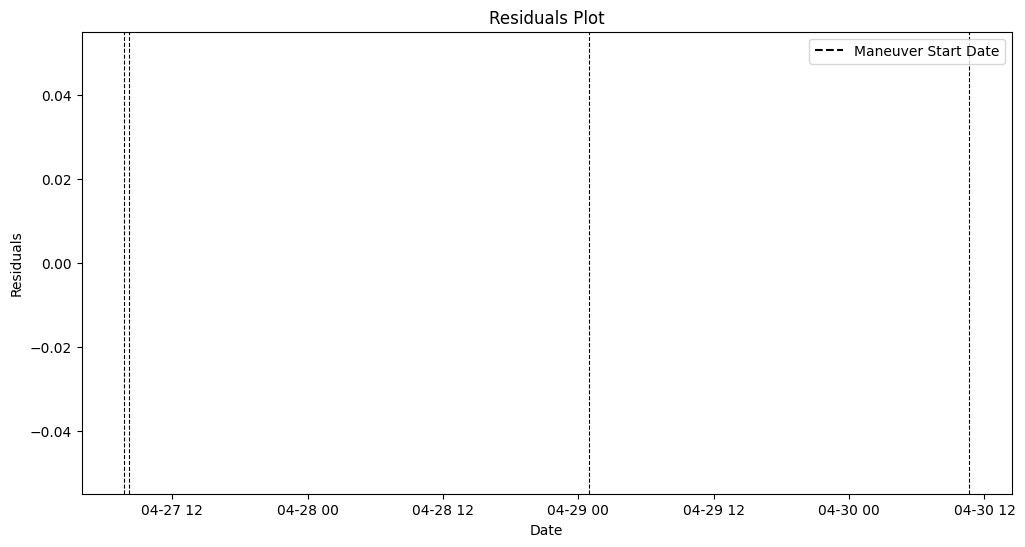

In [ ]:
s6a_bmm_xgb, s6a_bmm_xgb_y_test, s6a_bmm_xgb_y_pred, s6a_bmm_xgb_residuals, s6a_bmm_xgb_anomaly_indices = xgboost_with_grid_search(
    data = s6a_tle,
    target_column='brouwer_mean_motion',
    lag = 3
)

plot_xgboost_residuals(s6a_bmm_xgb_y_test, s6a_bmm_xgb_y_pred, s6aman, '2021-04-01', '2021-07-01')

Precision at Best F1: 0.8947368421052632
Recall at Best F1: 0.6296296296296297
Best F1 Score: 0.739130434734121


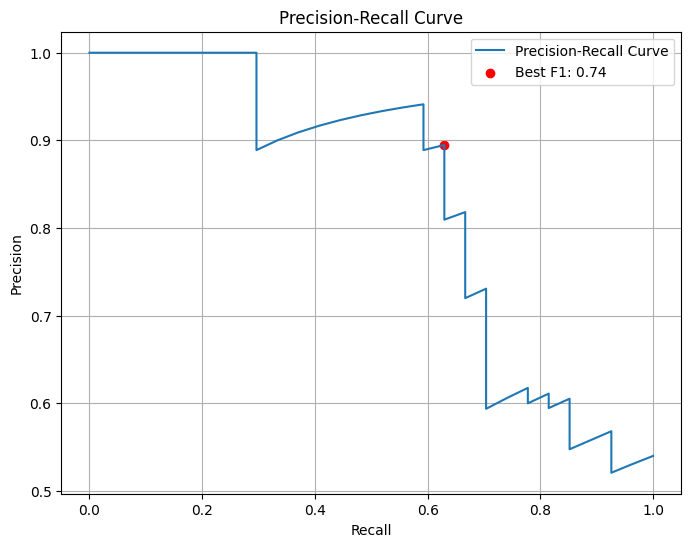

In [ ]:
# Filtered residuals and maneuver timestamps
s6a_xgb_bmm_predictions_series = pd.Series(
    s6a_bmm_xgb_y_pred,
    index=s6a_bmm_xgb_y_test.index  # Using the same index as the ground truth for alignment
)

# Define parameters for evaluate_model_performance
float_matching_max_days = 5  # set the max days to match predictions to ground truth
float_threshold = 0.001        # set a threshold for considering anomalies

# Calculate precision and recall
precision, recall = evaluate_model_performance(
    float_matching_max_days,
    float_threshold,
    s6aman,
    s6a_xgb_bmm_predictions_series
)

plot_precision_recall_curve_from_model(
    float_matching_max_days=5,
    pd_series_ground_truth_manoeuvre_timestamps=cs2man_filtered,
    pd_series_predictions=xgb_bmm_predictions_series
)

## CatBoost

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'depth': 4, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.2}


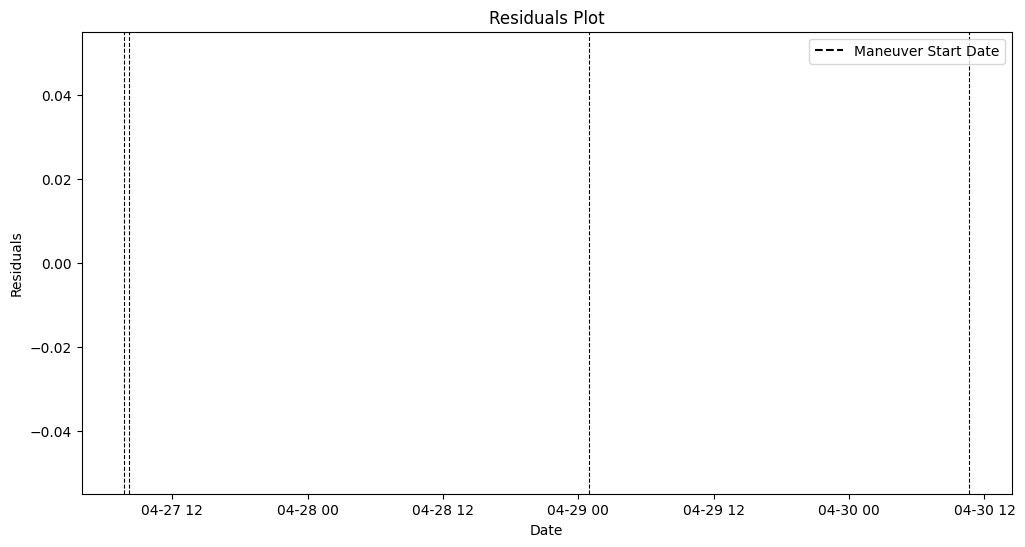

In [ ]:
s6a_bmm_cab, s6a_bmm_cab_y_test, s6a_bmm_cab_y_pred, s6a_bmm_cab_residuals, s6a_bmm_cab_anomaly_indices = catboost_with_grid_search(
    data = s6a_tle,
    target_column='brouwer_mean_motion',
    lag = 3
)

plot_xgboost_residuals(s6a_bmm_cab_y_test, s6a_bmm_cab_y_pred, s6aman, '2021-04-01', '2021-07-01')

In [ ]:
# Filtered residuals and maneuver timestamps
cab_bmm_predictions_series = pd.Series(
    cs2_bmm_cab_y_pred,
    index=cs2_bmm_cab_y_test.index  # Using the same index as the ground truth for alignment
)

# Define parameters for evaluate_model_performance
float_matching_max_days = 5  # set the max days to match predictions to ground truth
float_threshold = 0.00000000000000000000000001        # set a threshold for considering anomalies

# Calculate precision and recall
precision, recall = evaluate_model_performance(
    float_matching_max_days,
    float_threshold,
    cs2man_filtered,
    cab_bmm_predictions_series
)

plot_precision_recall_curve_from_model(
    float_matching_max_days=5,
    pd_series_ground_truth_manoeuvre_timestamps=cs2man_filtered,
    pd_series_predictions=xgb_bmm_predictions_series
)

## VARIMA

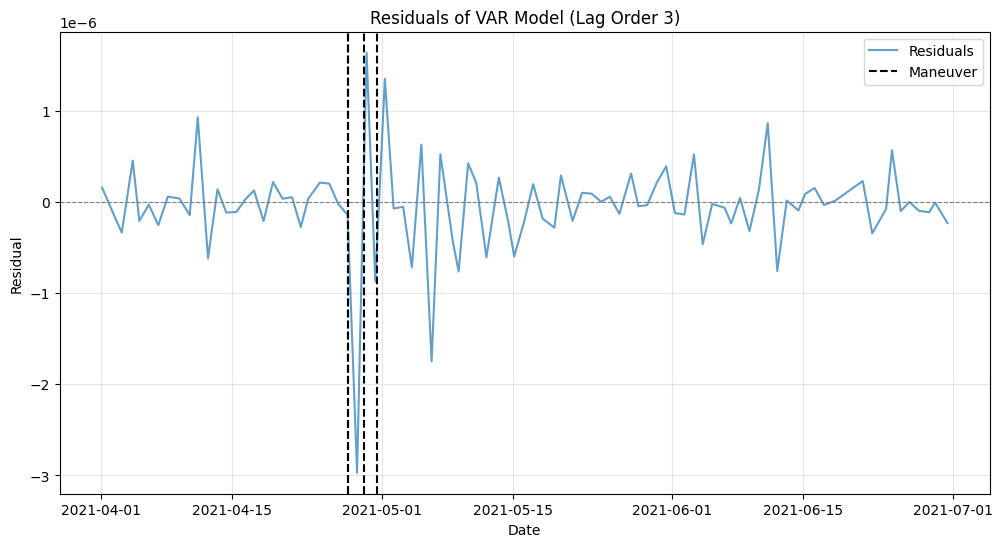

Best VAR lag order: 3 with MSE: 1.2130452860125722e-11


In [ ]:
s6a_best_model, best_lag_order = best_var_fit(s6a_tle, target_variable='brouwer_mean_motion', maneuver_dates = s6aman['start_date'], max_lag = 3, start_date = '2021-04-01', end_date = '2021-07-01')

Precision at Best F1: 0.8461538461538461
Recall at Best F1: 0.7857142857142857
Best F1 Score: 0.8148148147648834


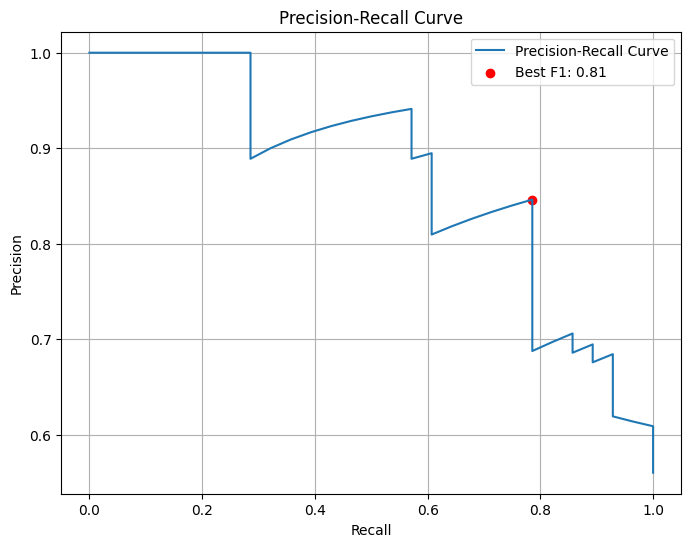

In [ ]:
# Filtered residuals and maneuver timestamps,
arima_bmm_filtered_pred = cs2bmm_best_model.fittedvalues[(cs2bmm_best_model.resid.index >= pd.Timestamp('2022-01-01')) &
                                      (cs2bmm_best_model.resid.index < pd.Timestamp('2022-06-01'))]

# Define parameters for evaluate_model_performance
float_matching_max_days = 5 # set the max days to match predictions to ground truth
float_threshold = 0.001        # set a threshold for considering anomalies

# Calculate precision and recall
cs2_ar_precision, cs2_ar_recall = evaluate_model_performance(
    float_matching_max_days,
    float_threshold,
    cs2man_filtered,
    arima_bmm_filtered_pred
)

plot_precision_recall_curve_from_model(
    float_matching_max_days=5,
    pd_series_ground_truth_manoeuvre_timestamps=cs2man_filtered,
    pd_series_predictions=xgb_bmm_predictions_series
)

# SARAL

## Importing Datasets

In [ ]:
srl_tle = read_satellite_data('unpropagated_elements_SARAL.csv')
srl_tle.head()

eccentricity  argument of perigee  inclination  \
2013-03-10 13:13:33.964320      0.000129             3.342279     1.719596   
2013-03-11 22:45:10.058975      0.000130             3.291112     1.719589   
2013-03-13 01:34:26.835167      0.000151             3.208097     1.719577   
2013-03-14 02:43:30.192095      0.000527             1.514363     1.719552   
2013-03-15 18:57:49.375584      0.000076             2.181199     1.719575   

                            mean anomaly  Brouwer mean motion  right ascension  
2013-03-10 13:13:33.964320     -3.340260             0.062543         4.532454  
2013-03-11 22:45:10.058975     -3.289068             0.062543         4.556435  
2013-03-13 01:34:26.835167     -3.206336             0.062543         4.575627  
2013-03-14 02:43:30.192095     -1.510258             0.062525         4.593694  
2013-03-15 18:57:49.375584     -2.179016             0.062531         4.622396

In [ ]:
srlman = extract_start_end_dates('srlman.txt')
srlman.head()

start_date            end_date
0 2013-02-27 13:14:00 2013-02-27 13:19:00
1 2013-02-27 14:58:00 2013-02-27 15:04:00
2 2013-03-01 15:51:00 2013-03-01 15:53:00
3 2013-03-02 06:03:00 2013-03-02 06:05:00
4 2013-03-03 02:10:00 2013-03-03 02:12:00

## Formatting the Columns

In [ ]:
format_cols(srl_tle)
srl_tle.head()

eccentricity  argument_of_perigee  inclination  \
2013-03-10 13:13:33.964320      0.000129             3.342279     1.719596   
2013-03-11 22:45:10.058975      0.000130             3.291112     1.719589   
2013-03-13 01:34:26.835167      0.000151             3.208097     1.719577   
2013-03-14 02:43:30.192095      0.000527             1.514363     1.719552   
2013-03-15 18:57:49.375584      0.000076             2.181199     1.719575   

                            mean_anomaly  brouwer_mean_motion  right_ascension  
2013-03-10 13:13:33.964320     -3.340260             0.062543         4.532454  
2013-03-11 22:45:10.058975     -3.289068             0.062543         4.556435  
2013-03-13 01:34:26.835167     -3.206336             0.062543         4.575627  
2013-03-14 02:43:30.192095     -1.510258             0.062525         4.593694  
2013-03-15 18:57:49.375584     -2.179016             0.062531         4.622396

## Checking for Duplicates

In [ ]:
check_duplicates(srl_tle)

No duplicates


## Missing Values

In [ ]:
missing_values(srl_tle)

Percentage of missing value in entire dataset is: 0.0%


## ACF and PACF Plots

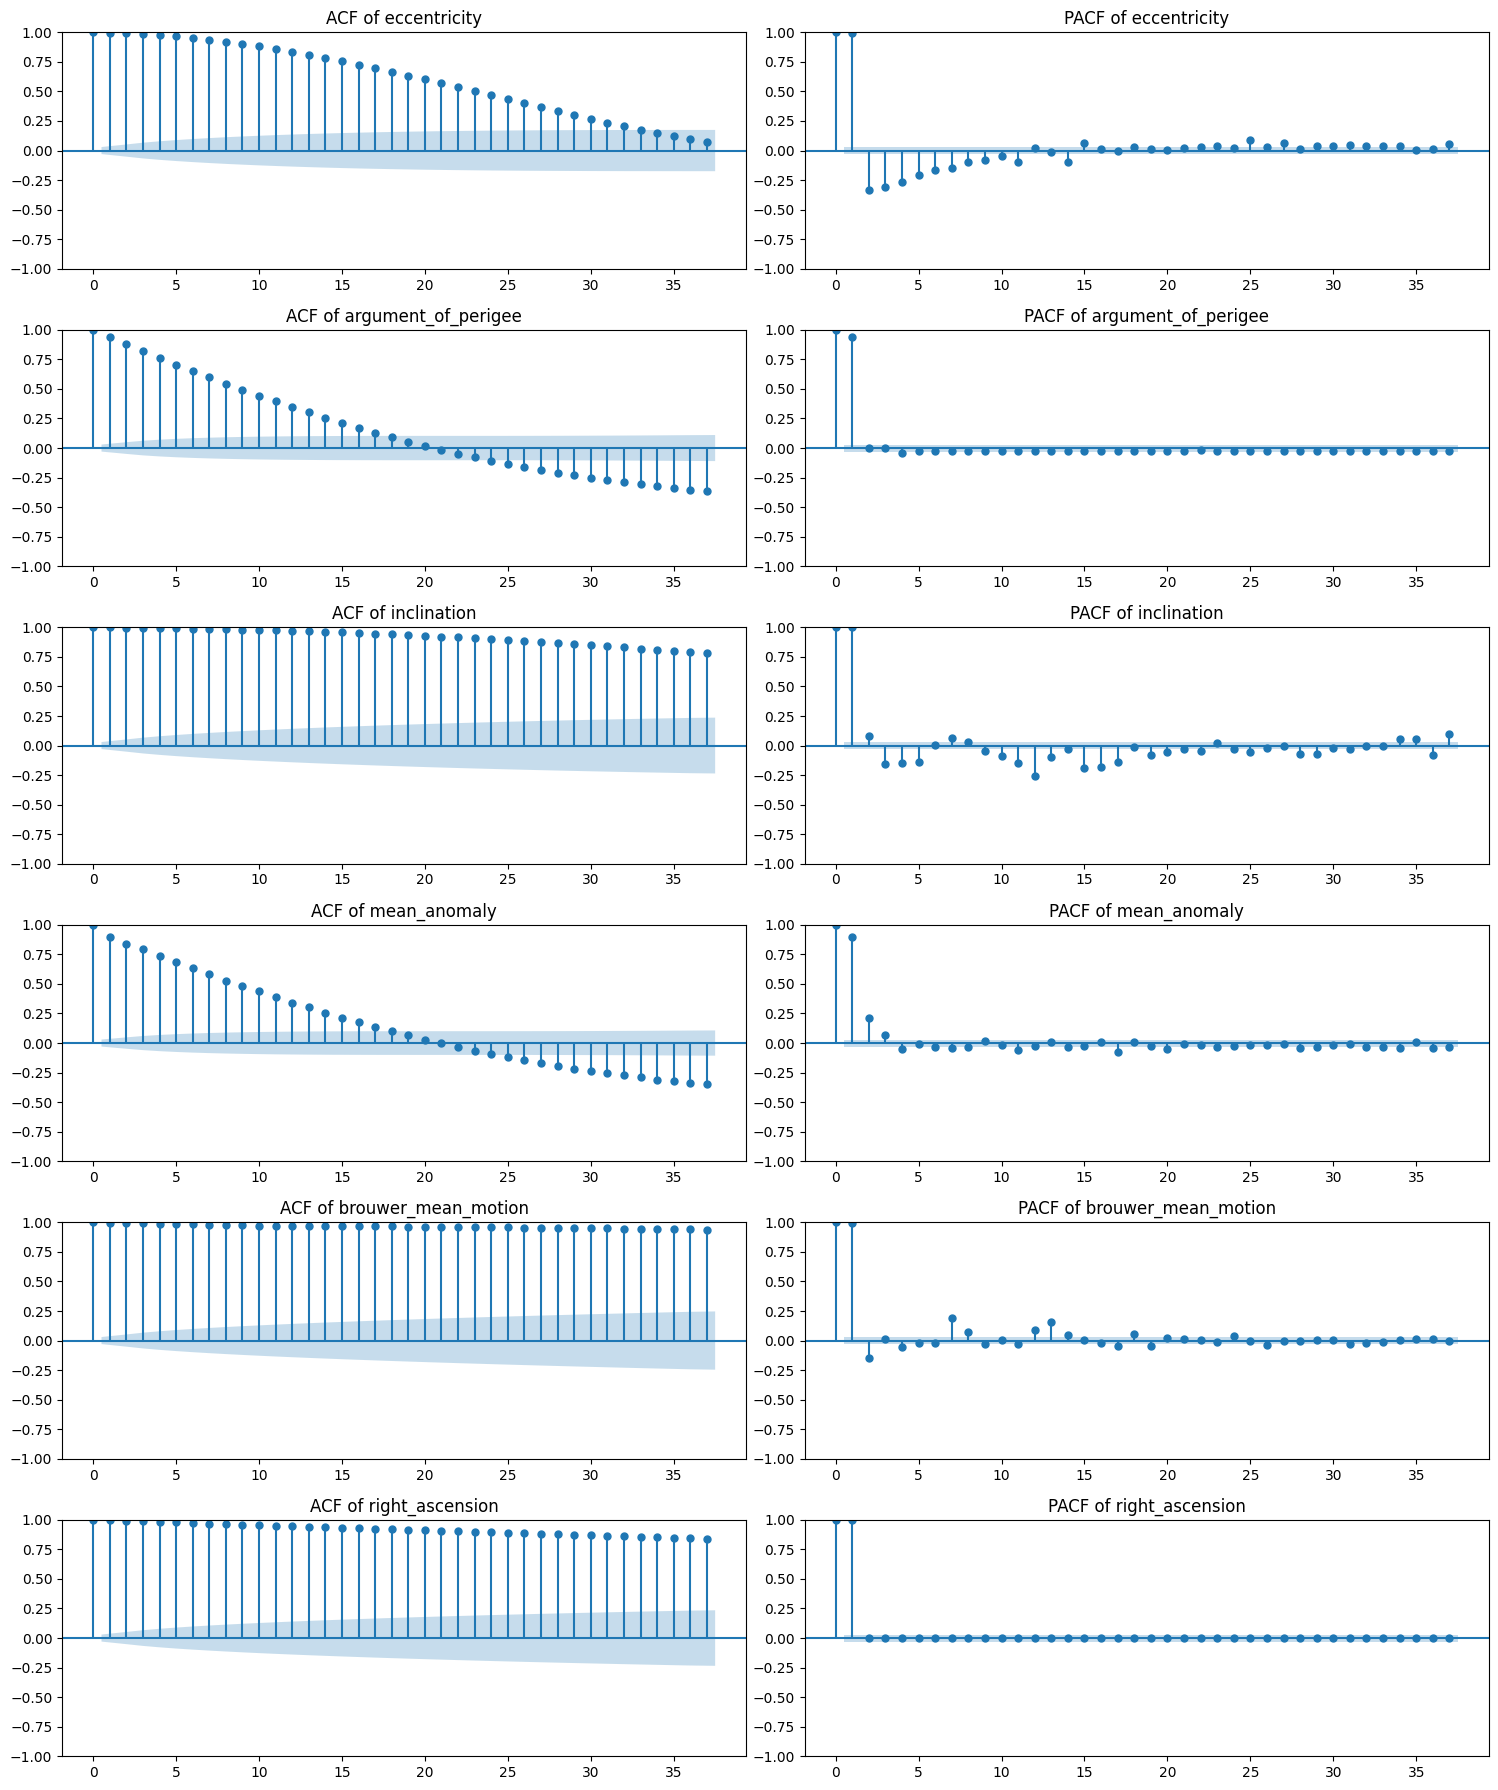

In [ ]:
acf_pacf(srl_tle)

## Stationary Test: ADF Test

In [ ]:
adf_test(srl_tle)

Augmented Dickey-Fuller Test: eccentricity
ADF Test Statistic            -1.272019e+01
p-value                        9.865744e-24
#Lags Used                     2.500000e+01
Number of Observations Used    3.264000e+03
Critical Value (1%)           -3.432355e+00
Critical Value (5%)           -2.862426e+00
Critical Value (10%)          -2.567242e+00

Augmented Dickey-Fuller Test: argument_of_perigee
ADF Test Statistic            -1.088801e+01
p-value                        1.245687e-19
#Lags Used                     2.500000e+01
Number of Observations Used    3.264000e+03
Critical Value (1%)           -3.432355e+00
Critical Value (5%)           -2.862426e+00
Critical Value (10%)          -2.567242e+00

Augmented Dickey-Fuller Test: inclination
ADF Test Statistic               -5.535019
p-value                           0.000002
#Lags Used                       29.000000
Number of Observations Used    3260.000000
Critical Value (1%)              -3.432358
Critical Value (5%)             

## Exploratory Data Analysis

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3290 entries, 2013-03-10 13:13:33.964320 to 2022-09-14 04:39:56.791584
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   eccentricity         3290 non-null   float64
 1   argument_of_perigee  3290 non-null   float64
 2   inclination          3290 non-null   float64
 3   mean_anomaly         3290 non-null   float64
 4   brouwer_mean_motion  3290 non-null   float64
 5   right_ascension      3290 non-null   float64
dtypes: float64(6)
memory usage: 179.9 KB
None
       eccentricity  argument_of_perigee  inclination  mean_anomaly  \
count   3290.000000          3290.000000  3290.000000   3290.000000   
mean       0.000143             1.555963     1.719883     -1.553658   
std        0.000064             0.667961     0.000082      0.667959   
min        0.000002             0.157865     1.719540     -4.476841   
25%        0.000092             0.997294  

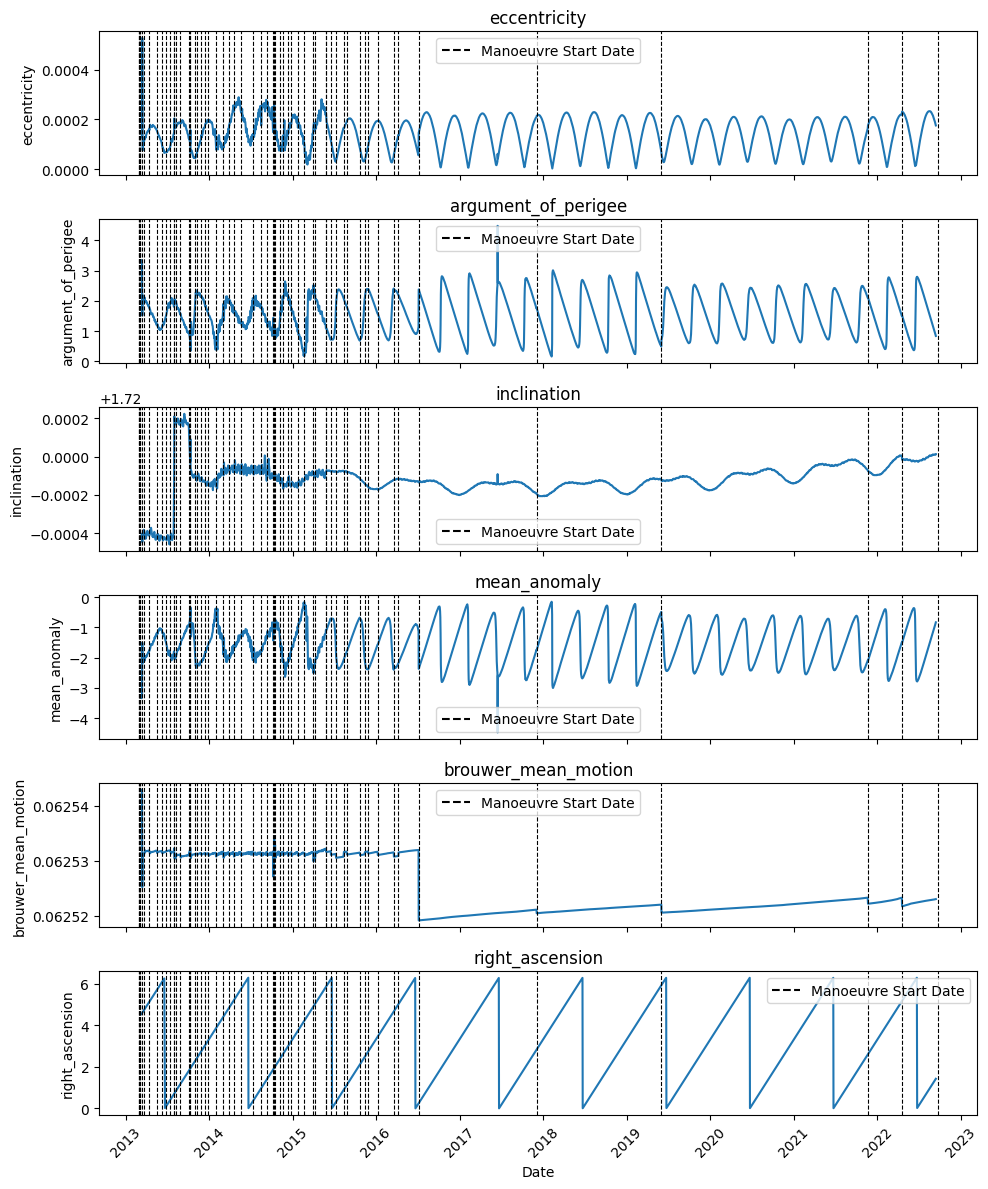

In [ ]:
eda(srl_tle, srlman)

## Exploratory Data Analysis Filtered

In [ ]:
srlman_filtered = srlman[(srlman['start_date'] >= pd.Timestamp('2014-10-01')) &
                                   (srlman['start_date'] < pd.Timestamp('2015-07-01'))]['start_date']

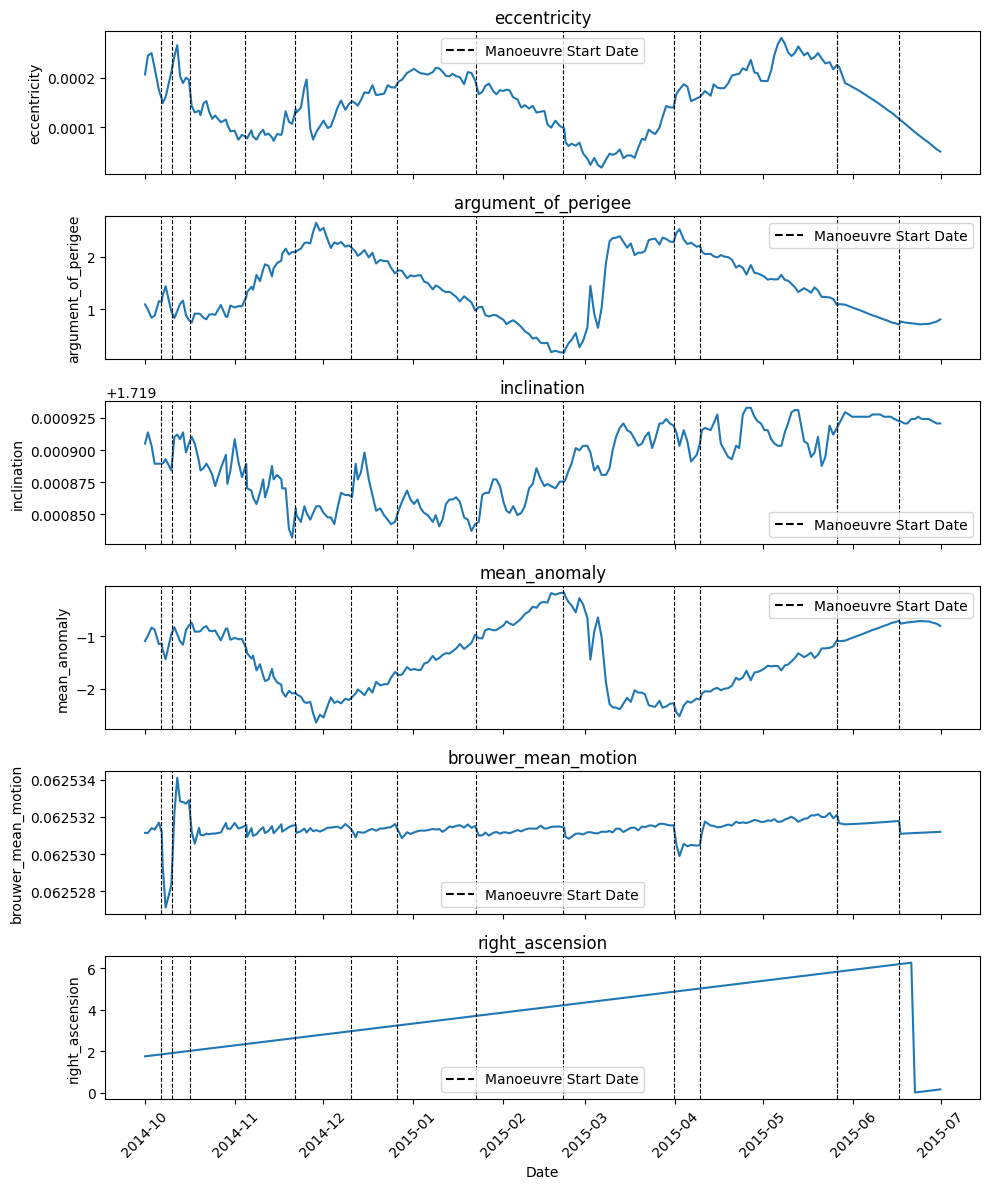

In [ ]:
eda_filtered(srl_tle, srlman, '2014-10-01', '2015-07-01')

## ARIMA Model and Plotting Residuals

### Eccentricity

Best ARIMA order: (1, 0, 0) with MSE: 2.441570770948574e-08


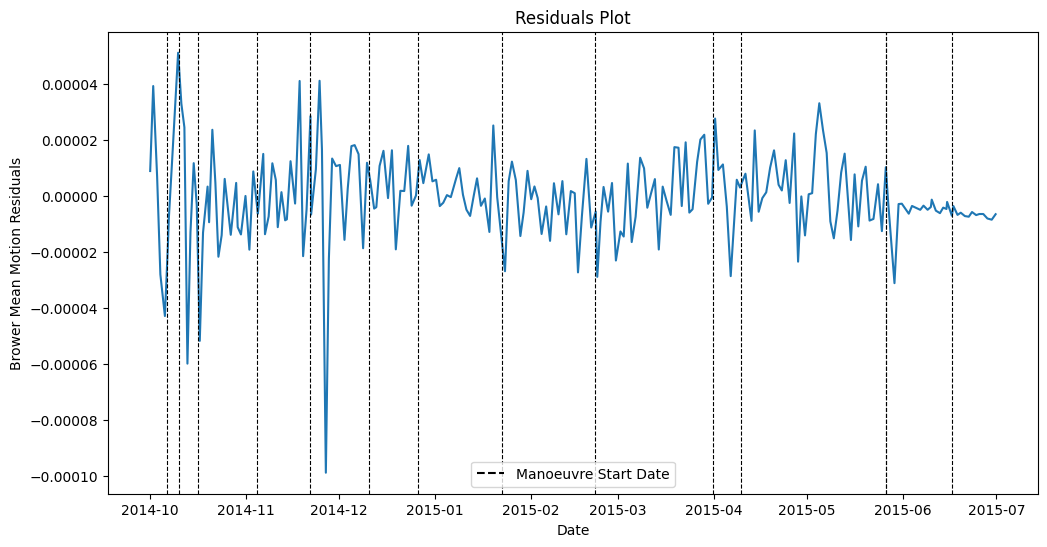

In [ ]:
srlecc_best_model = best_arima_fit(srl_tle['eccentricity'])

plot_residuals(srlecc_best_model,srlman, '2014-10-01', '2015-07-01')

### Argument of Perigee

Best ARIMA order: (1, 0, 0) with MSE: 2.8526444434611102


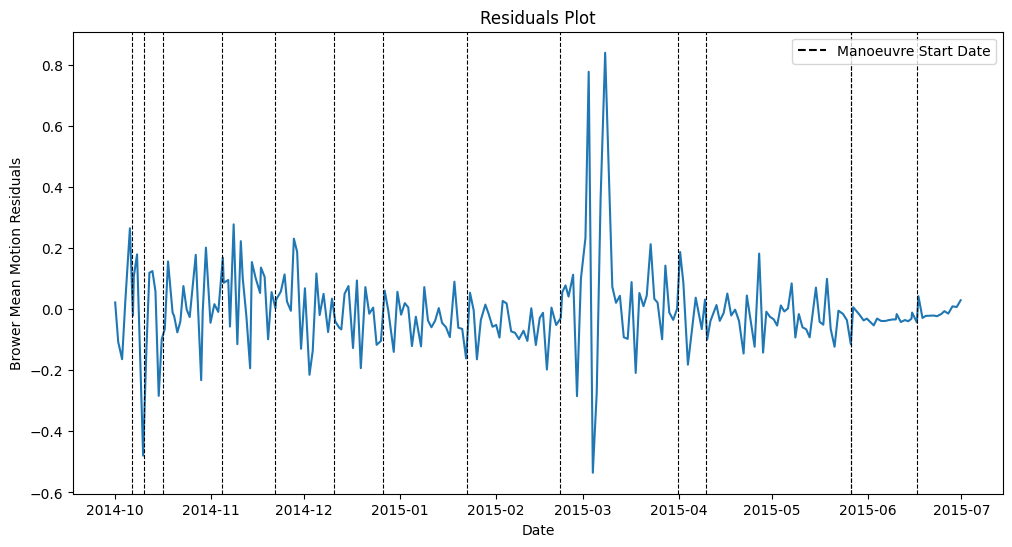

In [ ]:
srlaop_best_model = best_arima_fit(srl_tle['argument_of_perigee'])

plot_residuals(srlaop_best_model,srlman, '2014-10-01', '2015-07-01')

### Inclination


Best ARIMA order: (1, 0, 0) with MSE: 2.9579982312929536


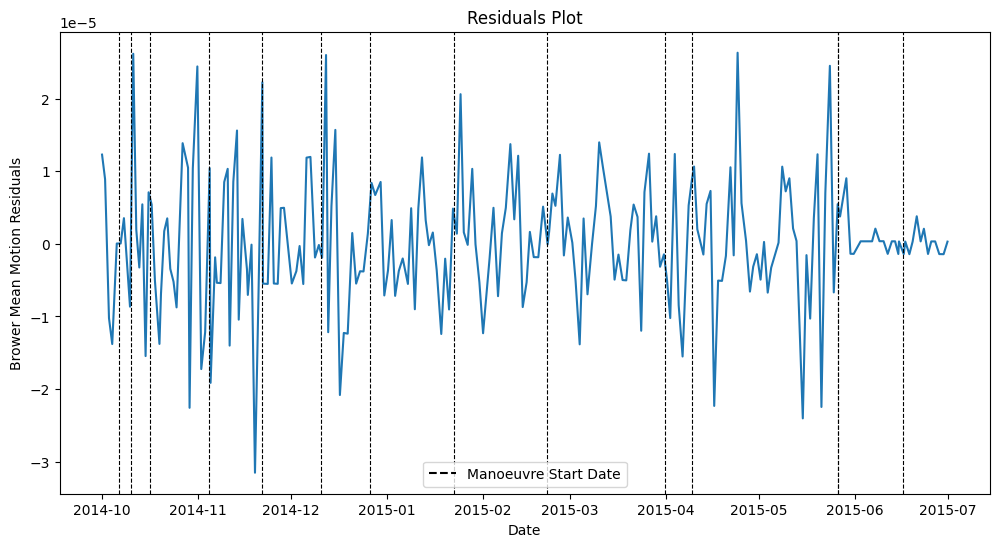

In [ ]:
srlinc_best_model = best_arima_fit(srl_tle['inclination'])

plot_residuals(srlinc_best_model,srlman, '2014-10-01', '2015-07-01')

### Mean Anomaly


Best ARIMA order: (2, 0, 1) with MSE: 2.840008771327166


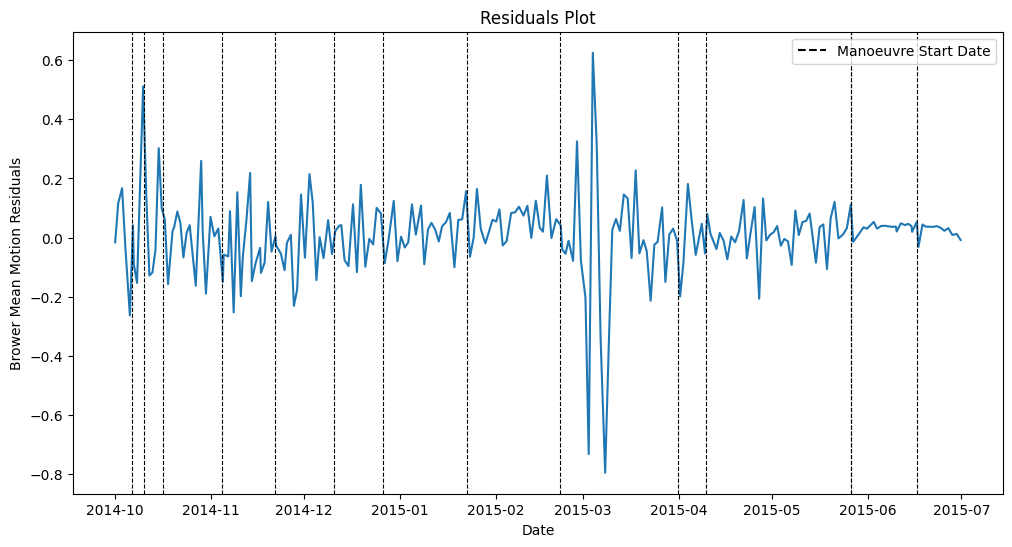

In [ ]:
srlma_best_model = best_arima_fit(srl_tle['mean_anomaly'])

plot_residuals(srlma_best_model,srlman, '2014-10-01', '2015-07-01')

### Brouwer Mean Motion


Best ARIMA order: (1, 2, 2) with MSE: 0.0039093218714396525


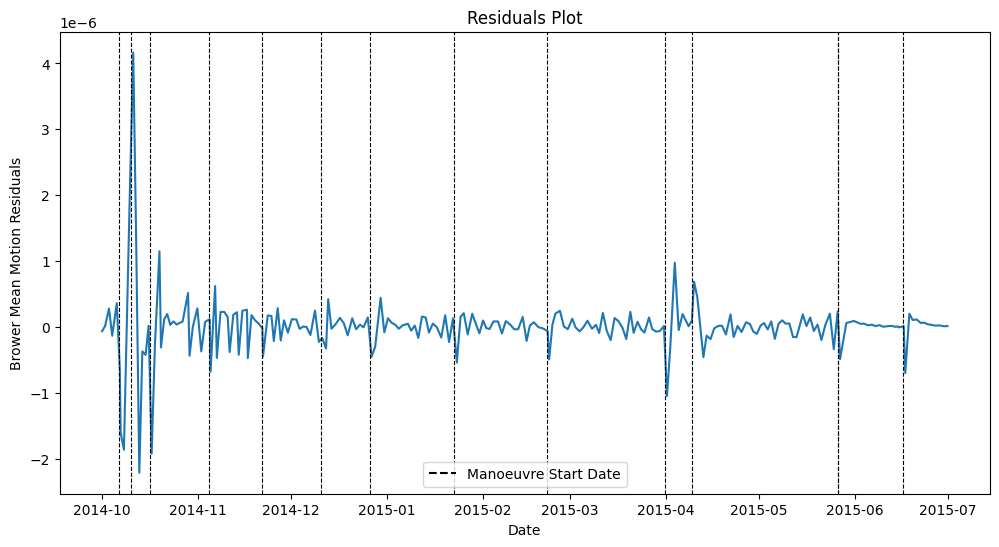

In [ ]:
srlbmm_best_model = best_arima_fit(srl_tle['brouwer_mean_motion'])

plot_residuals(srlbmm_best_model,srlman, '2014-10-01', '2015-07-01')

### Right Ascension

Best ARIMA order: (2, 0, 2) with MSE: 13.158461952900806


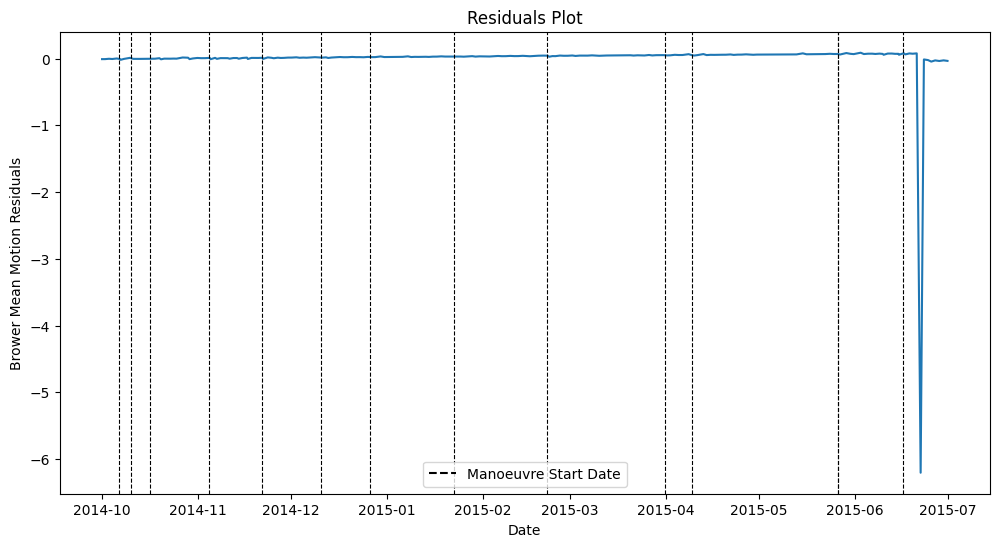

In [ ]:
srlra_best_model = best_arima_fit(srl_tle['right_ascension'])

plot_residuals(srlra_best_model,srlman, '2014-10-01', '2015-07-01')

### ARIMA PR Curve

Precision at Best F1: 0.9473684210526315
Recall at Best F1: 0.6428571428571429
Best F1 Score: 0.765957446760344


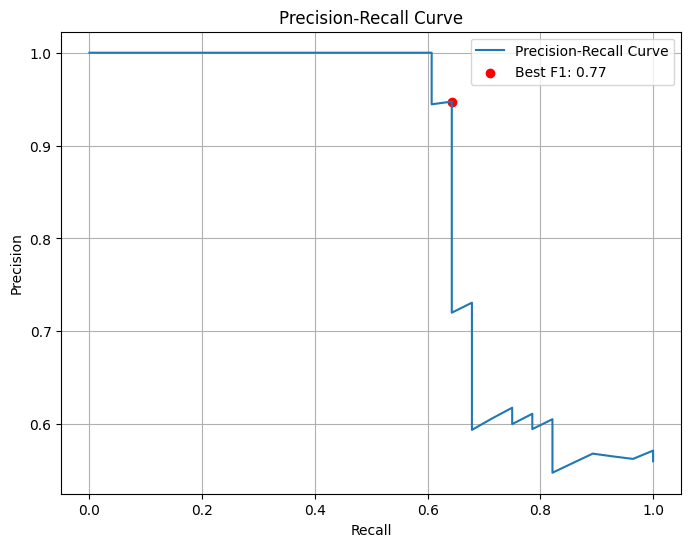

In [ ]:
# Filtered residuals and maneuver timestamps,
srlarima_bmm_filtered_pred = srlbmm_best_model.fittedvalues[(srlbmm_best_model.resid.index >= pd.Timestamp('2022-01-01')) &
                                      (srlbmm_best_model.resid.index < pd.Timestamp('2022-06-01'))]

# Define parameters for evaluate_model_performance
float_matching_max_days = 5 # set the max days to match predictions to ground truth
float_threshold = 0.001        # set a threshold for considering anomalies

# Calculate precision and recall
srl_ar_precision, srl_ar_recall = evaluate_model_performance(
    float_matching_max_days,
    float_threshold,
    srlman,
    srlarima_bmm_filtered_pred
)

plot_precision_recall_curve_from_model(
    float_matching_max_days=5,
    pd_series_ground_truth_manoeuvre_timestamps=cs2man_filtered,
    pd_series_predictions=xgb_bmm_predictions_series
)

## XGBoost

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


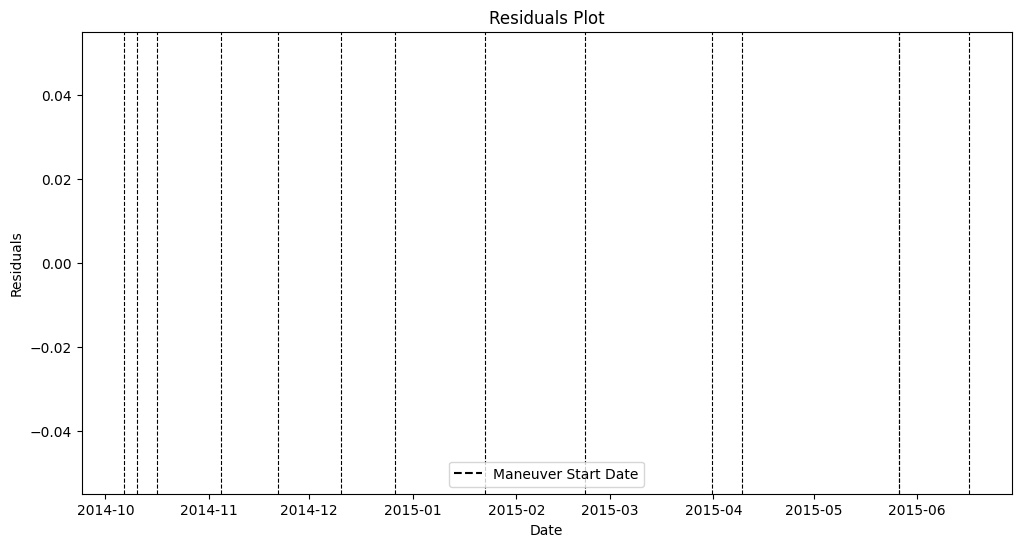

In [ ]:
srl_bmm_xgb, srl_bmm_xgb_y_test, srl_bmm_xgb_y_pred, srl_bmm_xgb_residuals, srl_bmm_xgb_anomaly_indices = xgboost_with_grid_search(
    data = srl_tle,
    target_column='brouwer_mean_motion',
    lag = 3
)

plot_xgboost_residuals(srl_bmm_xgb_y_test, srl_bmm_xgb_y_pred, srlman, '2014-10-01', '2015-07-01')

Precision at Best F1: 0.8461538461538461
Recall at Best F1: 0.7333333333333333
Best F1 Score: 0.7857142856645407


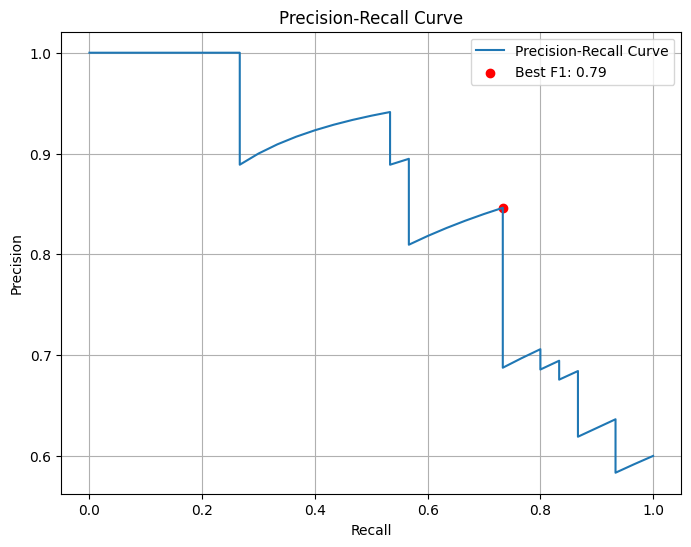

In [ ]:
# Filtered residuals and maneuver timestamps
srl_xgb_bmm_predictions_series = pd.Series(
    srlman_bmm_xgb_y_pred,
    index=srl_bmm_xgb_y_test.index  # Using the same index as the ground truth for alignment
)

# Define parameters for evaluate_model_performance
float_matching_max_days = 5  # set the max days to match predictions to ground truth
float_threshold = 0.001        # set a threshold for considering anomalies

# Calculate precision and recall
precision, recall = evaluate_model_performance(
    float_matching_max_days,
    float_threshold,
    srlman,
    srl_xgb_bmm_predictions_series
)

plot_precision_recall_curve_from_model(
    float_matching_max_days=5,
    pd_series_ground_truth_manoeuvre_timestamps=cs2man_filtered,
    pd_series_predictions=xgb_bmm_predictions_series
)

## CatBoost

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 5, 'learning_rate': 0.2}


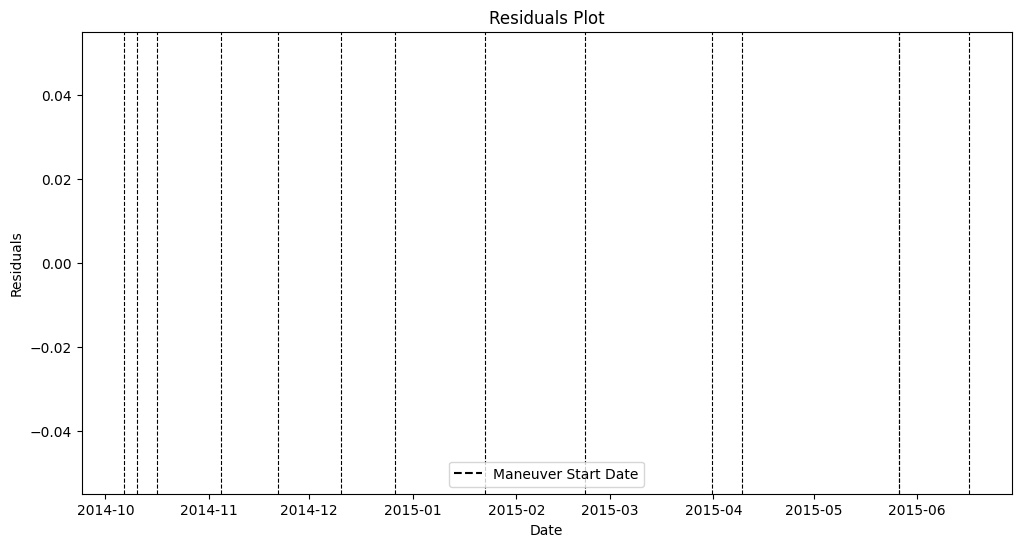

In [ ]:
srl_bmm_cab, srl_bmm_cab_y_test, srl_bmm_cab_y_pred, srl_bmm_cab_residuals, srl_bmm_cab_anomaly_indices = catboost_with_grid_search(
    data = srl_tle,
    target_column='brouwer_mean_motion',
    lag = 3
)

plot_xgboost_residuals(srl_bmm_cab_y_test, srl_bmm_cab_y_pred, srlman, '2014-10-01', '2015-07-01')

In [ ]:
# Filtered residuals and maneuver timestamps
srl_cab_bmm_predictions_series = pd.Series(
    srl_bmm_cab_y_pred,
    index=srl_bmm_cab_y_test.index  # Using the same index as the ground truth for alignment
)

# Define parameters for evaluate_model_performance
float_matching_max_days = 5  # set the max days to match predictions to ground truth
float_threshold = 0.001        # set a threshold for considering anomalies

# Calculate precision and recall
precision, recall = evaluate_model_performance(
    float_matching_max_days,
    float_threshold,
    srlman,
    srl_cab_bmm_predictions_series
)

plot_precision_recall_curve_from_model(
    float_matching_max_days=5,
    pd_series_ground_truth_manoeuvre_timestamps=cs2man_filtered,
    pd_series_predictions=xgb_bmm_predictions_series
)

## VARIMA

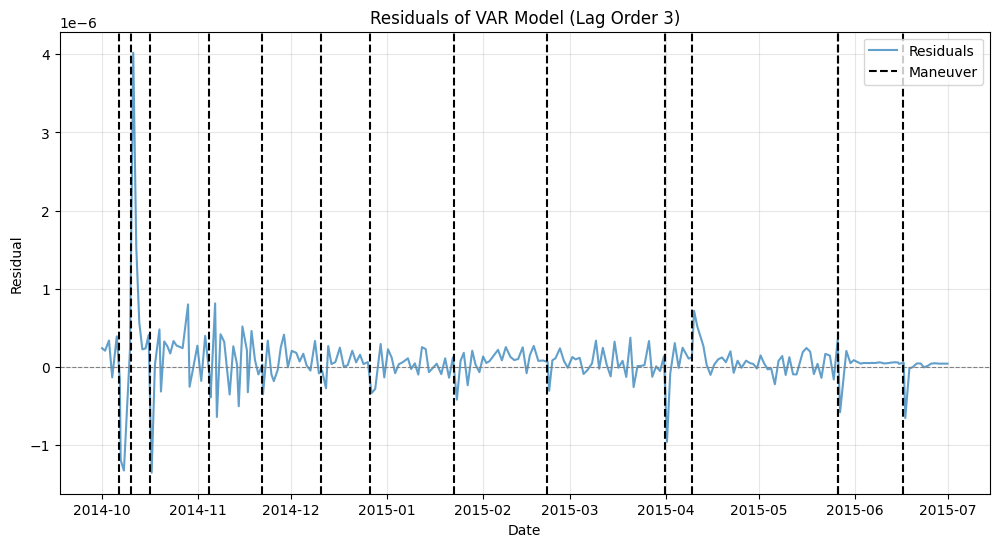

Best VAR lag order: 3 with MSE: 1.6122729610581169e-13


In [ ]:
srl_best_model, best_lag_order = best_var_fit(srl_tle, target_variable='brouwer_mean_motion', maneuver_dates = srlman['start_date'], max_lag = 3, start_date = '2014-10-01', end_date = '2015-07-01')

Precision at Best F1: 0.8461538461538461
Recall at Best F1: 0.8148148148148148
Best F1 Score: 0.8301886791953007


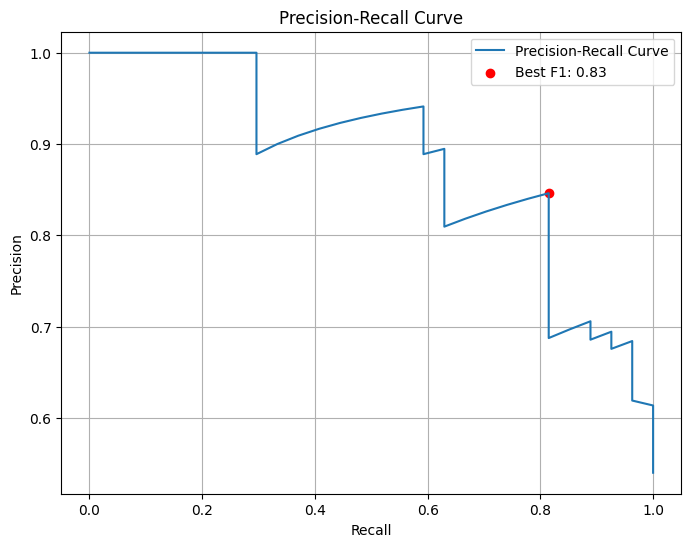

In [ ]:
# Filtered residuals and maneuver timestamps,
arima_bmm_filtered_pred = cs2bmm_best_model.fittedvalues[(cs2bmm_best_model.resid.index >= pd.Timestamp('2022-01-01')) &
                                      (cs2bmm_best_model.resid.index < pd.Timestamp('2022-06-01'))]

# Define parameters for evaluate_model_performance
float_matching_max_days = 5 # set the max days to match predictions to ground truth
float_threshold = 0.001        # set a threshold for considering anomalies

# Calculate precision and recall
cs2_ar_precision, cs2_ar_recall = evaluate_model_performance(
    float_matching_max_days,
    float_threshold,
    cs2man_filtered,
    arima_bmm_filtered_pred
)

plot_precision_recall_curve_from_model(
    float_matching_max_days=5,
    pd_series_ground_truth_manoeuvre_timestamps=cs2man_filtered,
    pd_series_predictions=xgb_bmm_predictions_series
)